In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
from IPython import get_ipython
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# To print all the output in cells (Deactivate if not necesssary. This is to avoid print() statements in cells)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

# Resources: 
#
# Efficient Back Propogation - Yann Lecun et al.
# http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf
#
# Sentiment analysis on Twitter using word2vec and Keras - Ahmed BESBES
# https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html


# Load the challenge
#from ouroath.oathml.challenge import *
import pandas as pd

import gensim
from gensim.models.word2vec import Word2Vec # the word2vec model gensim class
LabeledSentence = gensim.models.doc2vec.LabeledSentence # we'll talk about this down below
TaggedDocument = gensim.models.doc2vec.TaggedDocument

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook as tqdm
from sklearn import model_selection
import scipy
# import tensorflow as tf
# from tensorflow.python import keras
# from tensorflow.python.keras import regularizers
# from tensorflow.python.keras.callbacks import Callback
# from tensorflow.python.keras.layers import Dense, Activation,Input
# from tensorflow.python.keras.optimizers import SGD,Adam
# from tensorflow.python.keras.utils.generic_utils import get_custom_objects
# from tensorflow.python.keras.layers import Activation, Add, Concatenate, concatenate, LSTM
# from tensorflow.python.keras.constraints import max_norm
# from tensorflow.python.keras import initializers

import matplotlib.pyplot as plt
import re
import os
import json
import numpy as np

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import fbeta_score

/Users/brentweiliu/anaconda3/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [3]:
train_data_file = "data/train_data.txt"
valid_data_file = "data/validation_data.txt"
valid_labels = "data/ground_truth.txt"
trainDataPD = pd.read_csv(train_data_file, sep = "\t", header=None)
validDataPD = pd.read_csv(valid_data_file, sep = "\t", header=None)

In [4]:
! head -2 data/ground_truth.txt
trainDataPD[:2]

0
1


0  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                                   1  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                   2    3  
0  Michelle Obama is furious after finding out ab...  yes  
1  Bill and Melinda Gates explain to Yahoo Global...   no

In [5]:
trainDataPD.columns = ['url', 'title', 'body', 'label']
validDataPD.columns = ['url', 'title', 'body']

In [6]:
! head -5 data/ground_truth.txt
validation_labels = np.loadtxt(valid_labels, dtype=np.int32)
validation_labels.shape

0
1
1
1
0


(1073,)

In [7]:
def create_stetson_docs(df, out_dir, df_identifier):
    url2id = {}
    id2url = {}
    if not os.path.exists(out_dir + "/" + df_identifier):
        os.makedirs(out_dir + "/" + df_identifier)
    for i, row in df.iterrows():
        #print(row)
        with open(out_dir + "/" +  df_identifier + "/"+ str(i) + ".html", "w") as f_w:
            f_w.write("<html>\n")
            f_w.write("<head>\n")
            f_w.write("<title>" + row.title + "</title>\n")
            f_w.write("</head>\n")
            if str(row.body) == "nan":
                row.body = ""
            f_w.write("<body>" + row.body + "</body>\n")
            f_w.write("</html>")
        url2id[row.url] = i
        id2url[i] = row.url
    json.dump(url2id, open(out_dir + "/" + df_identifier+"_url2id.json", "w"))
    json.dump(id2url, open(out_dir + "/" + df_identifier+"_id2url.json", "w"))
    

#create_stetson_docs(validDataPD, "cap_input", "eval")

In [8]:
def read_tokens(json_file_dir):
    num_files = len(os.listdir(json_file_dir))
    tokenized = []
    for i in range(num_files):
        d = json.load(open(json_file_dir + "/" + str(i) + ".html.out"))
        title = d['entities']['capStreams'][0]
        title = [(x['text'], x['pos']) for x in title['tokens']]
        body = d['entities']['capStreams'][1]
        body = [(x['text'], x['pos']) for x in body['tokens']]
        tokenized.append((title, body))
    return tokenized
        

train_tokenized = read_tokens("cap_input/train_out/")
eval_tokenized = read_tokens("cap_input/eval_out/")

In [9]:
print(train_tokenized[0])

#print(eval_tokenized[0])

([('New', 'ADJECTIVE'), ('Clues', 'NOUN'), ('in', 'PREPOSITION'), ('Robin', 'PROPER_NOUN'), ('Williams', 'PROPER_NOUN'), ('Final', 'ADJECTIVE'), ('Hours', 'NOUN')], [('New', 'ADJECTIVE'), ('Clues', 'NOUN'), ('in', 'PREPOSITION'), ('Robin', 'PROPER_NOUN'), ('Williams', 'PROPER_NOUN'), ('Final', 'ADJECTIVE'), ('Hours', 'NOUN'), ('Bill', 'PROPER_NOUN'), ('and', 'CONJUNCTION'), ('Melinda', 'PROPER_NOUN'), ('Gates', 'PROPER_NOUN'), ('explain', 'VERB'), ('to', 'PREPOSITION'), ('Yahoo', 'NOUN'), ('Global', 'ADJECTIVE'), ('News', 'PROPER_NOUN'), ('Anchor', 'PROPER_NOUN'), ('Katie', 'PROPER_NOUN'), ('Couric', 'PROPER_NOUN'), ('how', 'ADVERB'), ('they', 'PRONOUN'), ('believe', 'VERB'), ('philanthropy', 'NOUN'), ('can', 'AUXILIARY'), ('make', 'VERB'), ('a', 'DETERMINER'), ('difference', 'NOUN'), ('globally', 'ADVERB'), ('in', 'PREPOSITION'), ('uplifting', 'PARTICLE'), ('the', 'DETERMINER'), ('poor', 'NOUN'), ('by', 'PREPOSITION'), ('shedding', 'PARTICLE'), ('a', 'DETERMINER'), ('light', 'NOUN'), 

In [10]:
! ls cap_input/eval_out
! cat cap_input/eval_out/1.html.out

0.html.out    226.html.out  42.html.out   613.html.out  807.html.out
1.html.out    227.html.out  420.html.out  614.html.out  808.html.out
10.html.out   228.html.out  421.html.out  615.html.out  809.html.out
100.html.out  229.html.out  422.html.out  616.html.out  81.html.out
1000.html.out 23.html.out   423.html.out  617.html.out  810.html.out
1001.html.out 230.html.out  424.html.out  618.html.out  811.html.out
1002.html.out 231.html.out  425.html.out  619.html.out  812.html.out
1003.html.out 232.html.out  426.html.out  62.html.out   813.html.out
1004.html.out 233.html.out  427.html.out  620.html.out  814.html.out
1005.html.out 234.html.out  428.html.out  621.html.out  815.html.out
1006.html.out 235.html.out  429.html.out  622.html.out  816.html.out
1007.html.out 236.html.out  43.html.out   623.html.out  817.html.out
1008.html.out 237.html.out  430.html.out  624.html.out  818.html.out
1009.html.out 238.html.out  431.html.out  625.html.out  819.html.out
101.html.out  239.html.out  432.htm

{
  "meta" : {
    "canonUrl" : "http://sbs.yahoo.com/1.html",
    "origUrl" : "http://sbs.yahoo.com/1.html",
    "language" : "en",
    "charset" : "UTF-8"
  },
  "shingles" : {
    "shingles_filtered" : "155A8D 314F74 3C55A0 5058DD 854405 F76F39 119A42B 142DA6F "
  },
  "docInvert" : {
    "words" : [ {
      "word" : "jim",
      "position" : [ 1, 13, 99, 337, 931, 958 ],
      "weight" : 1.886056,
      "meta" : "EXACTLOWER",
      "encoded_weight" : 78
    }, {
      "word" : "harbaugh",
      "position" : [ 2, 14, 100, 127, 171, 185, 206, 268, 299, 338, 365, 391, 453, 553, 594, 609, 630, 651, 755, 766, 782, 792, 800, 830, 841, 854, 857, 880, 932, 959 ],
      "weight" : 2.1378543,
      "meta" : "EXACTLOWER",
      "encoded_weight" : 89
    }, {
      "word" : "goes",
      "position" : [ 3 ],
      "weight" : 1.8245493,
      "meta" : "EXACTLOWER",
      "encoded_weight" : 76
    }, {
      "word" : "go",
      "position" : [ 3, 507, 760, 783, 801, 831 ],
      "weight" : 1.8860

        "pos" : "CONJUNCTION"
      }, {
        "text" : "her",
        "freq" : 1,
        "stem" : "she",
        "pos" : "DETERMINER"
      }, {
        "text" : "description",
        "freq" : 1,
        "stem" : "description",
        "pos" : "NOUN"
      }, {
        "text" : "is",
        "freq" : 1,
        "stem" : "be",
        "pos" : "VERB"
      }, {
        "text" : "perfect",
        "freq" : 1,
        "stem" : "perfect",
        "pos" : "ADJECTIVE"
      }, {
        "text" : "It",
        "freq" : 1,
        "stem" : "it",
        "pos" : "PRONOUN"
      }, {
        "text" : "doesn",
        "freq" : 1,
        "stem" : "doesn",
        "pos" : "ADJECTIVE"
      }, {
        "text" : "t",
        "freq" : 1,
        "stem" : "t",
        "pos" : "PROPER_NOUN"
      }, {
        "text" : "matter",
        "freq" : 1,
        "stem" : "matter",
        "pos" : "NOUN"
      }, {
        "text" : "if",
        "freq" : 1,
        "stem" : "if",
        "pos" : "CONJUNCT

In [11]:
len(train_tokenized), len(eval_tokenized)

(3000, 1073)

In [12]:
print(pd.Series([title for title, body in train_tokenized]).values)

[list([('New', 'ADJECTIVE'), ('Clues', 'NOUN'), ('in', 'PREPOSITION'), ('Robin', 'PROPER_NOUN'), ('Williams', 'PROPER_NOUN'), ('Final', 'ADJECTIVE'), ('Hours', 'NOUN')])
 list([('Ex', 'PROPER_NOUN'), ('player', 'NOUN'), ('lawsuit', 'NOUN'), ('UNC', 'PROPER_NOUN'), ('failed', 'VERB'), ('to', 'VERB'), ('educate', 'VERB')])
 list([('Exclusive', 'ADJECTIVE'), ('Republicans', 'NOUN'), ('prepare', 'VERB'), ('2015', 'NUMERAL'), ('immigration', 'NOUN'), ('legislation', 'NOUN')])
 ...
 list([('Bob', 'PROPER_NOUN'), ('Arum', 'NOUN'), ('demolished', 'VERB'), ('Floyd', 'PROPER_NOUN'), ('Mayweather', 'PROPER_NOUN'), ('vs', 'PREPOSITION'), ('Manny', 'PROPER_NOUN'), ('Pacquiao', 'PROPER_NOUN'), ('mega', 'ADJECTIVE'), ('fight', 'NOUN')])
 list([('World', 'PROPER_NOUN'), ('War', 'PROPER_NOUN'), ('3', 'NUMERAL'), ('Russia', 'PROPER_NOUN'), ('Sends', 'VERB'), ('Warships', 'NOUN'), ('Near', 'PREPOSITION'), ('Australia', 'PROPER_NOUN'), ('and', 'CONJUNCTION'), ('Troops', 'NOUN'), ('to', 'PREPOSITION'), ('U

In [13]:
trainDataPD["title_tokenized"] = pd.Series([title for title, body in train_tokenized]).values
trainDataPD["body_tokenized"]  = pd.Series([body  for title, body in train_tokenized]).values
print(trainDataPD["title_tokenized"])

print(trainDataPD["label"])
trainDataPD["label"] = trainDataPD["label"].apply(lambda x: 1 if x=="yes" else 0)
print(trainDataPD["label"])

validDataPD["title_tokenized"] = pd.Series([x[0] for x in eval_tokenized]).values
validDataPD["body_tokenized"] = pd.Series([x[1] for x in eval_tokenized]).values
validDataPD["label"] = validation_labels

0       [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...
1       [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...
2       [(Exclusive, ADJECTIVE), (Republicans, NOUN), ...
3       [(Massive, ADJECTIVE), (lake, NOUN), (effect, ...
4       [(Ford, PROPER_NOUN), (s, PROPER_NOUN), (F, PR...
5       [(US, PROPER_NOUN), (Negotiator, NOUN), (Cites...
6       [(Obama, PROPER_NOUN), (Rumors, NOUN), (Michel...
7       [(Mom, PROPER_NOUN), (of, PREPOSITION), (man, ...
8       [(Study, NOUN), (finds, VERB), (the, DETERMINE...
9       [(15, NUMERAL), (Sports, PROPER_NOUN), (Stars,...
10      [(Talladega, PROPER_NOUN), (s, PROPER_NOUN), (...
11      [(Here, ADVERB), (s, PROPER_NOUN), (Why, ADVER...
12      [(What, PRONOUN), (s, PROPER_NOUN), (wrong, AD...
13      [(Explosions, NOUN), (lead, NOUN), (to, PREPOS...
14      [(Bears, PROPER_NOUN), (Coach, NOUN), (Makes, ...
15      [(Analysts, NOUN), (Islamic, ADJECTIVE), (Stat...
16      [(Cinderella, PROPER_NOUN), (s, PROPER_NOUN), ...
17      [(Surp

In [14]:
trainDataPD = trainDataPD.fillna(value='null')
validDataPD = validDataPD.fillna(value='null')

In [15]:
trainDataPD.head(2)

url  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                               title  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                body  label  \
0  Michelle Obama is furious after finding out ab...      1   
1  Bill and Melinda Gates explain to Yahoo Global...      0   

                                     title_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                                      body_tokenized  
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...  
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...

In [16]:
validDataPD.head(2)

url  \
0  http://www.cbsnews.com/news/militarys-darpa-la...   
1  http://online.wsj.com/articles/jim-harbaugh-go...   

                                               title  \
0  Military's DARPA lab creates wearable robot to...   
1                    ‘Jim Harbaugh’ Goes to Michigan   

                                                body  \
0  This piece originally aired on November 11, 20...   
1  WSJ’s Jason Gay dresses up like Jim Harbaugh a...   

                                     title_tokenized  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...   

                                      body_tokenized  label  
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...      0  
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...      1

In [17]:
trainDataPD[trainDataPD.label == 1].head(5)

url  \
0   http://nworeport.me/2014/12/16/obama-rumors-mi...   
11  http://wallstcheatsheet.com/technology/heres-w...   
12  http://www.express.co.uk/news/uk/534506/Carol-...   
13  http://www.aol.com/article/2014/11/14/explosio...   
17  http://www.huffingtonpost.com/entry/germany-is...   

                                                title  \
0   Obama Rumors: Michelle Obama Furious Over Bara...   
11          Here’s Why ‘Pokémon’ Is Not Just for Kids   
12  What's wrong with your EYE? BBC Breakfast's Ca...   
13  Explosions lead to stunning Italian fireworks ...   
17  Surprise! Germany Has Tons Of Islands And They...   

                                                 body  label  \
0   Michelle Obama is furious after finding out ab...      1   
11  Source: Pokemon.comThe new Pokémon games start...      1   
12  BBCPopular Met Office forecaster Carol Kirkwoo...      1   
13  The best fireworks display you'll ever see was...      1   
17  While you might not think of sandy dunes and o...      1   

                                      title_tokenized  \
0   [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
11  [(Here, ADVERB), (s, PROPER_NOUN), (Why, ADVER...   
12  [(What, PRONOUN), (s, PROPER_NOUN), (wrong, AD...   
13  [(Explosions, NOUN), (lead, NOUN), (to, PREPOS...   
17  [(Surprise, NOUN), (Germany, PROPER_NOUN), (Ha...   

                                       body_tokenized  
0   [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...  
11  [(Here, ADVERB), (s, PROPER_NOUN), (Why, ADVER...  
12  [(What, PRONOUN), (s, PROPER_NOUN), (wrong, AD...  
13  [(Explosions, NOUN), (lead, NOUN), (to, PREPOS...  
17  [(Surprise, NOUN), (Germany, PROPER_NOUN), (Ha...

In [18]:
len(trainDataPD), len(validDataPD)

(3000, 1073)

In [19]:
filtered_df = trainDataPD[trainDataPD.label == 1].sample(n=100)
n = 2
filtered_df[:n]
[x[1] for x in filtered_df.title_tokenized[:2]]

labels = [l[1] for x in filtered_df.title_tokenized for l in x]
from collections import Counter
cnt_labels = Counter(labels)
cnt_labels

url  \
2115  http://kotaku.com/seven-minutes-of-excellent-c...   
2426  http://www.inquisitr.com/1647902/charles-barkl...   

                                                  title  \
2115  ​Seven Minutes Of Excellent Cosplay From This ...   
2426  Charles Barkley: Ferguson Rioters Are Scumbags...   

                                                   body  label  \
2115  There are a lot of people in costumes having f...      1   
2426  Charles Barkley, the former NBA star, weighed ...      1   

                                        title_tokenized  \
2115  [(Seven, NUMERAL), (Minutes, NOUN), (Of, PREPO...   
2426  [(Charles, PROPER_NOUN), (Barkley, PROPER_NOUN...   

                                         body_tokenized  
2115  [(Seven, NUMERAL), (Minutes, NOUN), (Of, PREPO...  
2426  [(Charles, PROPER_NOUN), (Barkley, PROPER_NOUN...

[('Minutes', 'NOUN'), ('Barkley', 'PROPER_NOUN')]

Counter({'NUMERAL': 26,
         'NOUN': 265,
         'PREPOSITION': 98,
         'ADJECTIVE': 81,
         'DETERMINER': 91,
         'PROPER_NOUN': 255,
         'VERB': 144,
         'PARTICLE': 15,
         'PRONOUN': 55,
         'CONJUNCTION': 23,
         'AUXILIARY': 10,
         'ADVERB': 58,
         'QUANTIFIER': 10})

In [20]:
MAX_WORDS_SIMILARITY_COMPUTE = 50

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS 

bad_words_file = "data/bad_words.txt"

def get_bad_words(fp):
    words = open(fp).readlines()
    return set([word.strip() for word in words if len(word.strip())>0])

BAD_WORDS = get_bad_words(bad_words_file)

def tokenize_content(x):
    return x

def combine_two_lists(x, y):
    return x + y

def get_uppercased(title_tokens, acronym=False):
    title = [x[0] for x in title_tokens]
    num_acronyms = len([word for word in title if word.isupper() and len(word)<=5])
    num_uppercased = len([word for word in title if word.isupper()])
    if acronym:
        return num_acronyms
    else:
        return num_uppercased-num_acronyms

def compute_formality_measure(tokens):
    list_pos = [x[1] for x in tokens]
    cnt_labels = Counter(list_pos)
    score = 0.
    return 0.5*(cnt_labels['NOUN'] + cnt_labels['ADJECTIVE'] + cnt_labels['PREPOSITION'] + 
               cnt_labels['DETERMINER'] - cnt_labels['PRONOUN'] - cnt_labels['VERB'] - cnt_labels['ADVERB'] + 100)
    
    
def count_superlatives(title_tokens):
    title_pos = [x[1] for x in title_tokens]
    return title_pos.count('ADJECTIVE') + title_pos.count('ADVERB')
   
def count_bad_words(tokens):
    bd = [x[0] for x in tokens if x[0].lower() in BAD_WORDS]
    return len(bd)

def featurize_df(df, top_words=list(range(10, MAX_WORDS_SIMILARITY_COMPUTE + 10, 10))):
    
    df = df.copy()
    df["title_tokens_only"] = df.title_tokenized.apply(lambda x: [t[0].lower() for t in x
                                                                  if t[0].lower() not in STOP_WORDS])
    df["body_tokens_only"] = df.body_tokenized.apply(lambda x: [t[0].lower() for t in x
                                                                if t[0].lower() not in STOP_WORDS])
    df["title_body_combined_tokens"] = df.apply(lambda x: 
                                                combine_two_lists(x['title_tokens_only'], x['body_tokens_only']),
                                                axis=1)
    
    for num_top_word in top_words:
        df["body_top_" + str(num_top_word) +"_tokens_only"] = df.body_tokens_only.apply(lambda x: x[:num_top_word])
        
    df["feat_t_words"] = df.title_tokenized.apply(lambda x: len(x))
    df["feat_b_words"] = df.body_tokenized.apply(lambda x: len(x))
    df["feat_t_acronym"] = df.title_tokenized.apply(lambda x: get_uppercased(x, acronym=True))
    df["feat_upper_non_acronyms"] = df.title_tokenized.apply(lambda x: get_uppercased(x, acronym=False))
    df["feat_bin_excl"] = df.title.apply(lambda x: 1 if "!" in set(x) else 0)
    df["feat_num_excl"] = df.title.apply(lambda x: x.count("!"))
    df["feat_bin_ques"] = df.title.apply(lambda x: 1 if "?" in set(x) else 0)
    df["feat_num_ques"] = df.title.apply(lambda x: x.count("?"))
    df["feat_title_starts_num"] = df.title.apply(lambda x: 1 if x[0].isdigit() else 0)
    df["feat_num_superlatives"] = df.title_tokenized.apply(lambda x: count_superlatives(x))
    df["feat_bin_quotes"] = df.title.apply(lambda x: 1 if len(set(["\"\"", "\'"]).intersection(set(x)))>0 else 0)
    df["feat_bin_start5w1h"] = df.title_tokenized.apply(lambda x: 1 
                                                        if x[0][0].lower()
                                                        in set(['what', 'when', 'who', 'why', 'which', 'how']) 
                                                        else 0)
    
    df["feat_has_parenthesis"] = df.title.apply(lambda x: 1 if ('(' in set(x) or ')' in set(x)) else 0)
    df["feat_has_moneymarker"] = df.title.apply(lambda x: 1 if ('$' in set(x) or '£' in set(x)) else 0)
    df["feat_url_freq_dash"] = df.url.apply(lambda x: x.count('-'))
    df["feat_url_depth"] = df.url.apply(lambda x: x.count("/"))
    df["feat_formality_title"] = df.title_tokenized.apply(lambda x: compute_formality_measure(x))
    df["feat_formality_body"] = df.body_tokenized.apply(lambda x: compute_formality_measure(x))
    df["feat_numslangs_title"] = df.title_tokenized.apply(lambda x: count_bad_words(x))
    df["feat_numslangs_body"] = df.body_tokenized.apply(lambda x: count_bad_words(x))
    df["feat_title_starts_adverb"] = df.title_tokenized.apply(lambda x: 1 if (len(x)>0 and x[0][1] == "ADVERB") else 0)
    df["feat_title_has_demonstratives"] = df.title_tokens_only.apply(lambda x: 1 if any(l in x for l in ['this', 'that', 'those', 'these'])
                                                                 else 0)
    df["feat_title_has_personal_pronouns"] = df.title_tokens_only.apply(lambda x: 1 if any(l in x for l in ['he', 'she', 'his', 'her', 'him'])
                                                                 else 0)
    
    
    return df
    

In [22]:
train_feat_df = featurize_df(trainDataPD)
valid_feat_df = featurize_df(validDataPD)
train_feat_df.head(2)    
valid_feat_df.head(2)

url  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                               title  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                body  label  \
0  Michelle Obama is furious after finding out ab...      1   
1  Bill and Melinda Gates explain to Yahoo Global...      0   

                                     title_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                                      body_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                             title_tokens_only  \
0  [new, clues, robin, williams, final, hours]   
1  [ex, player, lawsuit, unc, failed, educate]   

                                    body_tokens_only  \
0  [new, clues, robin, williams, final, hours, bi...   
1  [ex, player, lawsuit, unc, failed, educate, ch...   

                          title_body_combined_tokens  \
0  [new, clues, robin, williams, final, hours, ne...   
1  [ex, player, lawsuit, unc, failed, educate, ex...   

                             body_top_10_tokens_only  \
0  [new, clues, robin, williams, final, hours, bi...   
1  [ex, player, lawsuit, unc, failed, educate, ch...   

                 ...                feat_has_moneymarker feat_url_freq_dash  \
0                ...                                   0                 10   
1                ...                                   0                  5   

  feat_url_depth feat_formality_title  feat_formality_body  \
0              7                 52.5                 60.0   
1              4                 49.5                136.5   

   feat_numslangs_title  feat_numslangs_body  feat_title_starts_adverb  \
0                     0                    2                         0   
1                     1                   10                         0   

   feat_title_has_demonstratives  feat_title_has_personal_pronouns  
0                              0                                 0  
1                              0                                 0  

[2 rows x 37 columns]

url  \
0  http://www.cbsnews.com/news/militarys-darpa-la...   
1  http://online.wsj.com/articles/jim-harbaugh-go...   

                                               title  \
0  Military's DARPA lab creates wearable robot to...   
1                    ‘Jim Harbaugh’ Goes to Michigan   

                                                body  \
0  This piece originally aired on November 11, 20...   
1  WSJ’s Jason Gay dresses up like Jim Harbaugh a...   

                                     title_tokenized  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...   

                                      body_tokenized  label  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...      0   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...      1   

                                   title_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1                    [jim, harbaugh, goes, michigan]   

                                    body_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...   

                          title_body_combined_tokens  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, jim, harbaugh,...   

                             body_top_10_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...   

                 ...                feat_has_moneymarker feat_url_freq_dash  \
0                ...                                   0                 10   
1                ...                                   0                  5   

  feat_url_depth feat_formality_title  feat_formality_body  \
0              5                 50.0                147.5   
1              4                 50.0                143.5   

   feat_numslangs_title  feat_numslangs_body  feat_title_starts_adverb  \
0                     0                    7                         0   
1                     0                    5                         0   

   feat_title_has_demonstratives  feat_title_has_personal_pronouns  
0                              0                                 0  
1                              0                                 0  

[2 rows x 37 columns]

In [23]:
trainDataPD.head(2)
def test(x):
    print(x)
    print(x[0], x[1])
    return 1 if (len(x)>0 and x[0][1] == "ADVERB") else 0
trainDataPD[:2].title_tokenized.apply(test)

url  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                               title  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                body  label  \
0  Michelle Obama is furious after finding out ab...      1   
1  Bill and Melinda Gates explain to Yahoo Global...      0   

                                     title_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                                      body_tokenized  
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...  
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...

[('New', 'ADJECTIVE'), ('Clues', 'NOUN'), ('in', 'PREPOSITION'), ('Robin', 'PROPER_NOUN'), ('Williams', 'PROPER_NOUN'), ('Final', 'ADJECTIVE'), ('Hours', 'NOUN')]
('New', 'ADJECTIVE') ('Clues', 'NOUN')
[('Ex', 'PROPER_NOUN'), ('player', 'NOUN'), ('lawsuit', 'NOUN'), ('UNC', 'PROPER_NOUN'), ('failed', 'VERB'), ('to', 'VERB'), ('educate', 'VERB')]
('Ex', 'PROPER_NOUN') ('player', 'NOUN')


0    0
1    0
Name: title_tokenized, dtype: int64

In [24]:
train_feat_df.iloc[0]

url                                 http://nworeport.me/2014/12/16/obama-rumors-mi...
title                               Obama Rumors: Michelle Obama Furious Over Bara...
body                                Michelle Obama is furious after finding out ab...
label                                                                               1
title_tokenized                     [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...
body_tokenized                      [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...
title_tokens_only                         [new, clues, robin, williams, final, hours]
body_tokens_only                    [new, clues, robin, williams, final, hours, bi...
title_body_combined_tokens          [new, clues, robin, williams, final, hours, ne...
body_top_10_tokens_only             [new, clues, robin, williams, final, hours, bi...
body_top_20_tokens_only             [new, clues, robin, williams, final, hours, bi...
body_top_30_tokens_only             [new, clues, robin

In [25]:
train_feat_df.iloc[0]["title"]
train_feat_df.iloc[0]["title_tokenized"]

"Obama Rumors: Michelle Obama Furious Over Barack Obama's Secret Love Nest"

[('New', 'ADJECTIVE'),
 ('Clues', 'NOUN'),
 ('in', 'PREPOSITION'),
 ('Robin', 'PROPER_NOUN'),
 ('Williams', 'PROPER_NOUN'),
 ('Final', 'ADJECTIVE'),
 ('Hours', 'NOUN')]

In [26]:
# Bad words
[word for word, _ in train_feat_df.iloc[0]["body_tokenized"] if word.lower() in BAD_WORDS]

['fire', 'Israeli']

In [27]:
train_feat_df.iloc[0]["body_top_40_tokens_only"]

['new',
 'clues',
 'robin',
 'williams',
 'final',
 'hours',
 'bill',
 'melinda',
 'gates',
 'explain',
 'yahoo',
 'global',
 'news',
 'anchor',
 'katie',
 'couric',
 'believe',
 'philanthropy',
 'difference',
 'globally',
 'uplifting',
 'poor',
 'shedding',
 'light',
 'issues',
 'funding',
 'innovations',
 'overlooked',
 'government',
 'president',
 'obama',
 'threatening',
 'veto',
 'bill',
 'congress',
 'impose',
 'new',
 'sanctions',
 'iran',
 'obama']

In [28]:
train_feat_df.iloc[0]["title_body_combined_tokens"]

['new',
 'clues',
 'robin',
 'williams',
 'final',
 'hours',
 'new',
 'clues',
 'robin',
 'williams',
 'final',
 'hours',
 'bill',
 'melinda',
 'gates',
 'explain',
 'yahoo',
 'global',
 'news',
 'anchor',
 'katie',
 'couric',
 'believe',
 'philanthropy',
 'difference',
 'globally',
 'uplifting',
 'poor',
 'shedding',
 'light',
 'issues',
 'funding',
 'innovations',
 'overlooked',
 'government',
 'president',
 'obama',
 'threatening',
 'veto',
 'bill',
 'congress',
 'impose',
 'new',
 'sanctions',
 'iran',
 'obama',
 'says',
 'threaten',
 'nuclear',
 'talks',
 'speaker',
 'john',
 'boehner',
 'fire',
 'personally',
 'inviting',
 'israeli',
 'prime',
 'minister',
 'benjamin',
 'netanyahu',
 'address',
 'congress',
 'month',
 'margaret',
 'brennan',
 'reports',
 'washington']

In [29]:
from sklearn.preprocessing import normalize

def create_vectorizer(df, top_words = list(range(10, MAX_WORDS_SIMILARITY_COMPUTE+10, 10)), vectorizers=None):
    
#     if vectorizers is None:
#         vectorizers = []
#         vectorizer1 = CountVectorizer(tokenizer=tokenize_content,
#                                  max_df=0.95, min_df=2, 
#                                  stop_words=None, lowercase=False)
#         vectorizer1.fit(df['title_tokens_only'])
        
#         vectorizer2 = CountVectorizer(tokenizer=tokenize_content,
#                                  max_df=0.85, min_df=3, 
#                                  stop_words=None, lowercase=False)
#         vectorizer2.fit(df['body_tokens_only'])
        
#         vectorizers.append(vectorizer1)
#         vectorizers.append(vectorizer2)
        
    if vectorizers is None:
        vectorizers = [] 
        vectorizer = CountVectorizer(tokenizer=tokenize_content,
                                 max_df=0.95, min_df=2, 
                                 stop_words=None, lowercase=False)
        vectorizer.fit(df['title_body_combined_tokens'])
        vectorizers.append(vectorizer)
    
        
    title_vecs = vectorizers[0].transform(df['title_tokens_only'].tolist())

    body_vecs = vectorizers[0].transform(df['body_tokens_only'].tolist())
    body_top_vecs = []
    for i in top_words:
         body_top_vecs.append(vectorizers[0].transform(df['body_top_'+str(i)+'_tokens_only'].tolist()))
            
    return vectorizers, title_vecs, body_vecs, body_top_vecs
    
vectorizers, title_vecs, body_vecs, body_top_vecs = create_vectorizer(train_feat_df)
_, eval_title_vecs, eval_body_vecs, eval_body_top_vecs = create_vectorizer(valid_feat_df, vectorizers=vectorizers)

In [30]:
train_feat_df['title_tokens_only'].tolist()[:2]
title_vecs.shape
body_vecs.shape
len(body_top_vecs)
len(vectorizers[0].vocabulary_)
#vectorizers[0].vocabulary_['new']

'''
import csv
with open('vocabulary.tsv', 'w', newline='') as tsvfile:
    fnames = ['word', 'index']
    writer = csv.DictWriter(tsvfile, fieldnames=fnames,delimiter='\t')    
    writer.writeheader()
    for word, index in sorted(vectorizers[0].vocabulary_.items(), key=lambda kv: kv[1]):
        #print("%s\t\"%s\"" % (index, word))
        writer.writerow({'word': word, 'index' : index})
'''

[['new', 'clues', 'robin', 'williams', 'final', 'hours'],
 ['ex', 'player', 'lawsuit', 'unc', 'failed', 'educate']]

(3000, 24820)

(3000, 24820)

5

24820

'\nimport csv\nwith open(\'vocabulary.tsv\', \'w\', newline=\'\') as tsvfile:\n    fnames = [\'word\', \'index\']\n    writer = csv.DictWriter(tsvfile, fieldnames=fnames,delimiter=\'\t\')    \n    writer.writeheader()\n    for word, index in sorted(vectorizers[0].vocabulary_.items(), key=lambda kv: kv[1]):\n        #print("%s\t"%s"" % (index, word))\n        writer.writerow({\'word\': word, \'index\' : index})\n'

In [31]:
title_vecs.shape
print(title_vecs[0])

(3000, 24820)

  (0, 4637)	1
  (0, 8783)	1
  (0, 10956)	1
  (0, 15044)	1
  (0, 18967)	1
  (0, 24385)	1


In [32]:
body_vecs.shape
print(body_vecs[0])

(3000, 24820)

  (0, 914)	1
  (0, 1464)	1
  (0, 2609)	1
  (0, 2661)	1
  (0, 2765)	2
  (0, 3003)	1
  (0, 3283)	1
  (0, 4637)	1
  (0, 5154)	2
  (0, 5569)	1
  (0, 6679)	1
  (0, 8314)	1
  (0, 8783)	1
  (0, 8833)	1
  (0, 9407)	1
  (0, 9539)	1
  (0, 9769)	1
  (0, 9770)	1
  (0, 9882)	1
  (0, 10956)	1
  (0, 11311)	1
  (0, 11631)	1
  (0, 11937)	1
  (0, 11965)	1
  (0, 12035)	1
  :	:
  (0, 15020)	1
  (0, 15044)	2
  (0, 15060)	1
  (0, 15270)	1
  (0, 15329)	2
  (0, 15802)	1
  (0, 16382)	1
  (0, 16458)	1
  (0, 16853)	1
  (0, 17147)	1
  (0, 17218)	1
  (0, 18506)	1
  (0, 18967)	1
  (0, 19339)	1
  (0, 19432)	1
  (0, 19996)	1
  (0, 20819)	1
  (0, 22029)	1
  (0, 22438)	1
  (0, 22440)	1
  (0, 23530)	1
  (0, 23793)	1
  (0, 24137)	1
  (0, 24385)	1
  (0, 24662)	1


In [33]:
print(body_top_vecs[3][0])

  (0, 1464)	1
  (0, 2609)	1
  (0, 2765)	2
  (0, 4637)	1
  (0, 5154)	1
  (0, 5569)	1
  (0, 6679)	1
  (0, 8314)	1
  (0, 8783)	1
  (0, 9407)	1
  (0, 9539)	1
  (0, 9769)	1
  (0, 9770)	1
  (0, 9882)	1
  (0, 10956)	1
  (0, 11311)	1
  (0, 11631)	1
  (0, 11965)	1
  (0, 12042)	1
  (0, 12430)	1
  (0, 13133)	1
  (0, 14057)	1
  (0, 15044)	2
  (0, 15060)	1
  (0, 15329)	2
  (0, 15802)	1
  (0, 16458)	1
  (0, 16853)	1
  (0, 17147)	1
  (0, 18967)	1
  (0, 19339)	1
  (0, 19996)	1
  (0, 22440)	1
  (0, 23530)	1
  (0, 23793)	1
  (0, 24385)	1
  (0, 24662)	1


In [34]:
from sklearn.metrics.pairwise import cosine_similarity

def get_sim_title_body_top(title_vecs, body_top_vecs):
    cosine_sim_topk = []
    for body_top_vec in body_top_vecs:
        sim = cosine_similarity(title_vecs, body_top_vec, dense_output=True)
        cosine_sim_title_body = sim[[i for i in range(title_vecs.shape[0])], [i for i in range(title_vecs.shape[0])]]
        cosine_sim_topk.append(cosine_sim_title_body)
        print(cosine_sim_title_body[0])
    return cosine_sim_topk

train_cosine_sim_t_b = get_sim_title_body_top(title_vecs, body_top_vecs)
eval_cosine_sim_t_b = get_sim_title_body_top(eval_title_vecs, eval_body_top_vecs)

0.7745966692414835
0.5477225575051662
0.4472135954999579
0.4213504858001923
0.3818813079129867
0.9534625892455926
0.800094691365663
0.8004987358916189
0.7248824356090755
0.6617241025372945


In [35]:
for i, top_k in enumerate(range(10, MAX_WORDS_SIMILARITY_COMPUTE+10, 10)):
    train_feat_df["feat_cos_sim_t_b_" + str(top_k)] = pd.Series(train_cosine_sim_t_b[i]).values
    valid_feat_df["feat_cos_sim_t_b_" + str(top_k)] = pd.Series(eval_cosine_sim_t_b[i]).values

In [36]:
train_feat_df.head(2)
valid_feat_df.head(2)

url  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                               title  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                body  label  \
0  Michelle Obama is furious after finding out ab...      1   
1  Bill and Melinda Gates explain to Yahoo Global...      0   

                                     title_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                                      body_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                             title_tokens_only  \
0  [new, clues, robin, williams, final, hours]   
1  [ex, player, lawsuit, unc, failed, educate]   

                                    body_tokens_only  \
0  [new, clues, robin, williams, final, hours, bi...   
1  [ex, player, lawsuit, unc, failed, educate, ch...   

                          title_body_combined_tokens  \
0  [new, clues, robin, williams, final, hours, ne...   
1  [ex, player, lawsuit, unc, failed, educate, ex...   

                             body_top_10_tokens_only         ...           \
0  [new, clues, robin, williams, final, hours, bi...         ...            
1  [ex, player, lawsuit, unc, failed, educate, ch...         ...            

  feat_numslangs_title feat_numslangs_body feat_title_starts_adverb  \
0                    0                   2                        0   
1                    1                  10                        0   

  feat_title_has_demonstratives  feat_title_has_personal_pronouns  \
0                             0                                 0   
1                             0                                 0   

   feat_cos_sim_t_b_10  feat_cos_sim_t_b_20  feat_cos_sim_t_b_30  \
0             0.774597             0.547723             0.447214   
1             0.745356             0.667424             0.613572   

   feat_cos_sim_t_b_40  feat_cos_sim_t_b_50  
0              0.42135             0.381881  
1              0.56921             0.530745  

[2 rows x 42 columns]

url  \
0  http://www.cbsnews.com/news/militarys-darpa-la...   
1  http://online.wsj.com/articles/jim-harbaugh-go...   

                                               title  \
0  Military's DARPA lab creates wearable robot to...   
1                    ‘Jim Harbaugh’ Goes to Michigan   

                                                body  \
0  This piece originally aired on November 11, 20...   
1  WSJ’s Jason Gay dresses up like Jim Harbaugh a...   

                                     title_tokenized  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...   

                                      body_tokenized  label  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...      0   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...      1   

                                   title_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1                    [jim, harbaugh, goes, michigan]   

                                    body_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...   

                          title_body_combined_tokens  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, jim, harbaugh,...   

                             body_top_10_tokens_only         ...           \
0  [military, s, darpa, lab, creates, wearable, r...         ...            
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...         ...            

  feat_numslangs_title feat_numslangs_body feat_title_starts_adverb  \
0                    0                   7                        0   
1                    0                   5                        0   

  feat_title_has_demonstratives  feat_title_has_personal_pronouns  \
0                             0                                 0   
1                             0                                 0   

   feat_cos_sim_t_b_10  feat_cos_sim_t_b_20  feat_cos_sim_t_b_30  \
0             0.953463             0.800095             0.800499   
1             0.632456             0.625543             0.507093   

   feat_cos_sim_t_b_40  feat_cos_sim_t_b_50  
0             0.724882             0.661724  
1             0.442326             0.400892  

[2 rows x 42 columns]

In [37]:
def read_word_vectors(fp):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr[:300], dtype='float32')

    embeddings_index = dict(get_coefs(*o.split()) for o in tqdm(open(fp)) if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    return embeddings_index, emb_mean, emb_std, embed_size
    
#embeddings_index, emb_mean, emb_std, embed_size = read_word_vectors("data/glove.6B.300d.txt")

# data/word_vector.tsv
# data/glove.6B.300d.txt

In [38]:
t_b_vocab = set(vectorizers[0].get_feature_names()) #.union(set(vectorizers[1].get_feature_names()))
t_b_vocab = sorted(list(t_b_vocab))
t_b_vocab2idx = dict((c, i) for i, c in enumerate(t_b_vocab))
t_b_idx2vocab = dict((i, c) for i, c in enumerate(t_b_vocab))

# embeddings_matrix = np.zeros((len(t_b_vocab), embed_size))
# for word in t_b_vocab:
#     if word in embeddings_index:
#         embeddings_matrix[t_b_vocab2idx[word]] = embeddings_index[word]

# embeddings_matrix.shape

In [39]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / ((norm_a * norm_b) + 0.0001)

#cos_sim(embeddings_index['amazing'], embeddings_index['incredible'])
def embed_docs(tokens, embedding_matrix, w2idx):
    token_indices = [w2idx[x] for x in tokens if x in w2idx]
    word_2d = embedding_matrix[token_indices]
    if word_2d.size == 0:
        return np.zeros(embedding_matrix.shape[1])
    return np.mean(word_2d, axis=0)

#vectorize_doc_embedding(["military", "s", "darpa", "lab", "creates"], embeddings_matrix, t_b_vocab2idx)

In [40]:
train_feat_df.head(2)
valid_feat_df.head(2)

url  \
0  http://nworeport.me/2014/12/16/obama-rumors-mi...   
1  http://news.yahoo.com/video/clues-robin-willia...   

                                               title  \
0  Obama Rumors: Michelle Obama Furious Over Bara...   
1           New Clues in Robin Williams' Final Hours   

                                                body  label  \
0  Michelle Obama is furious after finding out ab...      1   
1  Bill and Melinda Gates explain to Yahoo Global...      0   

                                     title_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                                      body_tokenized  \
0  [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...   
1  [(Ex, PROPER_NOUN), (player, NOUN), (lawsuit, ...   

                             title_tokens_only  \
0  [new, clues, robin, williams, final, hours]   
1  [ex, player, lawsuit, unc, failed, educate]   

                                    body_tokens_only  \
0  [new, clues, robin, williams, final, hours, bi...   
1  [ex, player, lawsuit, unc, failed, educate, ch...   

                          title_body_combined_tokens  \
0  [new, clues, robin, williams, final, hours, ne...   
1  [ex, player, lawsuit, unc, failed, educate, ex...   

                             body_top_10_tokens_only         ...           \
0  [new, clues, robin, williams, final, hours, bi...         ...            
1  [ex, player, lawsuit, unc, failed, educate, ch...         ...            

  feat_numslangs_title feat_numslangs_body feat_title_starts_adverb  \
0                    0                   2                        0   
1                    1                  10                        0   

  feat_title_has_demonstratives  feat_title_has_personal_pronouns  \
0                             0                                 0   
1                             0                                 0   

   feat_cos_sim_t_b_10  feat_cos_sim_t_b_20  feat_cos_sim_t_b_30  \
0             0.774597             0.547723             0.447214   
1             0.745356             0.667424             0.613572   

   feat_cos_sim_t_b_40  feat_cos_sim_t_b_50  
0              0.42135             0.381881  
1              0.56921             0.530745  

[2 rows x 42 columns]

url  \
0  http://www.cbsnews.com/news/militarys-darpa-la...   
1  http://online.wsj.com/articles/jim-harbaugh-go...   

                                               title  \
0  Military's DARPA lab creates wearable robot to...   
1                    ‘Jim Harbaugh’ Goes to Michigan   

                                                body  \
0  This piece originally aired on November 11, 20...   
1  WSJ’s Jason Gay dresses up like Jim Harbaugh a...   

                                     title_tokenized  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...   

                                      body_tokenized  label  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...      0   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...      1   

                                   title_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1                    [jim, harbaugh, goes, michigan]   

                                    body_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...   

                          title_body_combined_tokens  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, jim, harbaugh,...   

                             body_top_10_tokens_only         ...           \
0  [military, s, darpa, lab, creates, wearable, r...         ...            
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...         ...            

  feat_numslangs_title feat_numslangs_body feat_title_starts_adverb  \
0                    0                   7                        0   
1                    0                   5                        0   

  feat_title_has_demonstratives  feat_title_has_personal_pronouns  \
0                             0                                 0   
1                             0                                 0   

   feat_cos_sim_t_b_10  feat_cos_sim_t_b_20  feat_cos_sim_t_b_30  \
0             0.953463             0.800095             0.800499   
1             0.632456             0.625543             0.507093   

   feat_cos_sim_t_b_40  feat_cos_sim_t_b_50  
0             0.724882             0.661724  
1             0.442326             0.400892  

[2 rows x 42 columns]

In [41]:
# train_feat_df["w2v_t"] = train_feat_df.title_tokens_only.apply(lambda x: embed_docs(x, embeddings_matrix, t_b_vocab2idx))

# valid_feat_df["w2v_t"] = valid_feat_df.title_tokens_only.apply(lambda x: embed_docs(x, embeddings_matrix, t_b_vocab2idx))

# for i, top_k in enumerate(range(10, MAX_WORDS_SIMILARITY_COMPUTE+10, 10)):
#     train_feat_df["w2v_b" + str(top_k)] = train_feat_df["body_top_" + str(top_k) +"_tokens_only"].apply(lambda x: embed_docs(x, embeddings_matrix, t_b_vocab2idx))
#     valid_feat_df["w2v_b" + str(top_k)] = valid_feat_df["body_top_" + str(top_k) +"_tokens_only"].apply(lambda x: embed_docs(x, embeddings_matrix, t_b_vocab2idx))
    


In [42]:
# for i, top_k in enumerate(range(10, MAX_WORDS_SIMILARITY_COMPUTE+10, 10)):
#     train_feat_df["feat_w2v_t_b" + str(top_k)] = train_feat_df.apply(lambda x: 
#                                                                      cos_sim(x["w2v_t"], x["w2v_b" +str(top_k)])
#                                                                      , axis=1)
#     valid_feat_df["feat_w2v_t_b" + str(top_k)] = valid_feat_df.apply(lambda x: 
#                                                                      cos_sim(x["w2v_t"], x["w2v_b" +str(top_k)])
#                                                                      , axis=1)

In [43]:
train_feat_df.iloc[0]

url                                 http://nworeport.me/2014/12/16/obama-rumors-mi...
title                               Obama Rumors: Michelle Obama Furious Over Bara...
body                                Michelle Obama is furious after finding out ab...
label                                                                               1
title_tokenized                     [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...
body_tokenized                      [(New, ADJECTIVE), (Clues, NOUN), (in, PREPOSI...
title_tokens_only                         [new, clues, robin, williams, final, hours]
body_tokens_only                    [new, clues, robin, williams, final, hours, bi...
title_body_combined_tokens          [new, clues, robin, williams, final, hours, ne...
body_top_10_tokens_only             [new, clues, robin, williams, final, hours, bi...
body_top_20_tokens_only             [new, clues, robin, williams, final, hours, bi...
body_top_30_tokens_only             [new, clues, robin

In [44]:
# get the feature columns from both dataframes
feature_cols = [x for x in train_feat_df.columns if x[:4]=="feat"]
#feature_cols = [x for x in feature_cols if not x.startswith("feat_cos_sim")]
#feature_cols = [x for x in feature_cols if not x.startswith("feat_w2v_t_b")]
feature_cols, len(feature_cols)

(['feat_t_words',
  'feat_b_words',
  'feat_t_acronym',
  'feat_upper_non_acronyms',
  'feat_bin_excl',
  'feat_num_excl',
  'feat_bin_ques',
  'feat_num_ques',
  'feat_title_starts_num',
  'feat_num_superlatives',
  'feat_bin_quotes',
  'feat_bin_start5w1h',
  'feat_has_parenthesis',
  'feat_has_moneymarker',
  'feat_url_freq_dash',
  'feat_url_depth',
  'feat_formality_title',
  'feat_formality_body',
  'feat_numslangs_title',
  'feat_numslangs_body',
  'feat_title_starts_adverb',
  'feat_title_has_demonstratives',
  'feat_title_has_personal_pronouns',
  'feat_cos_sim_t_b_10',
  'feat_cos_sim_t_b_20',
  'feat_cos_sim_t_b_30',
  'feat_cos_sim_t_b_40',
  'feat_cos_sim_t_b_50'],
 28)

In [45]:
train_feats = train_feat_df[feature_cols]
eval_feats = valid_feat_df[feature_cols]

In [46]:
train_feats.shape, eval_feats.shape

title_vecs

((3000, 28), (1073, 28))

<3000x24820 sparse matrix of type '<class 'numpy.int64'>'
	with 20631 stored elements in Compressed Sparse Row format>

In [47]:
X_train_feats = scipy.sparse.hstack([train_feats, title_vecs, body_vecs])
#X_train_feats = train_feats.copy()
#X_eval_feats = eval_feats.copy()
X_eval_feats = scipy.sparse.hstack([eval_feats, eval_title_vecs, eval_body_vecs])
Y_train = train_feat_df.label.tolist()
Y_eval = valid_feat_df.label.tolist()
X_train_feats.shape, train_feats.shape, title_vecs.shape, body_vecs.shape
X_eval_feats.shape, eval_feats.shape, eval_title_vecs.shape, eval_body_vecs.shape

((3000, 49668), (3000, 28), (3000, 24820), (3000, 24820))

((1073, 49668), (1073, 28), (1073, 24820), (1073, 24820))

In [48]:
X_train_feats.tocsr()[9, 4]

0.0

In [49]:
#X_train_feats[0].max()
X_train_feats.shape
X_train_feats_csr = X_train_feats.tocsr()
X_train_feats_csr.shape
#X_train_feats_csr[49667]
def write_feta_max():
    with open('feature_max_value.tsv', 'w') as f:
        row, col = X_train_feats_csr.shape
        for i in range(col):
            maxAbs = np.absolute(X_train_feats_csr[:,i]).max()
            if maxAbs == 0: 
                f.write('%d\t%0.1f\n'%(i, 0.0))
            else:
                f.write('%d\t%0.5f\n'%(i, 1/maxAbs))
    #f.flush()
    
write_feta_max()

(3000, 49668)

(3000, 49668)

In [50]:
X_train_feats_csr.shape
print(X_train_feats_csr[0])

(3000, 49668)

  (0, 0)	7.0
  (0, 1)	96.0
  (0, 9)	2.0
  (0, 10)	1.0
  (0, 14)	10.0
  (0, 15)	7.0
  (0, 16)	52.5
  (0, 17)	60.0
  (0, 19)	2.0
  (0, 23)	0.7745966692414835
  (0, 24)	0.5477225575051662
  (0, 25)	0.4472135954999579
  (0, 26)	0.4213504858001923
  (0, 27)	0.3818813079129867
  (0, 4665)	1.0
  (0, 8811)	1.0
  (0, 10984)	1.0
  (0, 15072)	1.0
  (0, 18995)	1.0
  (0, 24413)	1.0
  (0, 25762)	1.0
  (0, 26312)	1.0
  (0, 27457)	1.0
  (0, 27509)	1.0
  (0, 27613)	2.0
  :	:
  (0, 39868)	1.0
  (0, 39892)	2.0
  (0, 39908)	1.0
  (0, 40118)	1.0
  (0, 40177)	2.0
  (0, 40650)	1.0
  (0, 41230)	1.0
  (0, 41306)	1.0
  (0, 41701)	1.0
  (0, 41995)	1.0
  (0, 42066)	1.0
  (0, 43354)	1.0
  (0, 43815)	1.0
  (0, 44187)	1.0
  (0, 44280)	1.0
  (0, 44844)	1.0
  (0, 45667)	1.0
  (0, 46877)	1.0
  (0, 47286)	1.0
  (0, 47288)	1.0
  (0, 48378)	1.0
  (0, 48641)	1.0
  (0, 48985)	1.0
  (0, 49233)	1.0
  (0, 49510)	1.0


In [51]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

sc = MaxAbsScaler()
#sc = StandardScaler(with_mean=False)
X_train_feats = sc.fit_transform(X_train_feats)
X_eval_feats = sc.transform(X_eval_feats)

In [52]:
sc.max_abs_.shape

(49668,)

In [53]:
X_train_feats_csr = X_train_feats.tocsr()
X_train_feats_csr.shape
print(X_train_feats_csr[0])

(3000, 49668)

  (0, 0)	0.2692307692307693
  (0, 1)	0.011714460036607689
  (0, 9)	0.2857142857142857
  (0, 10)	1.0
  (0, 14)	0.4
  (0, 15)	0.5384615384615385
  (0, 16)	0.9292035398230089
  (0, 17)	0.07168458781362007
  (0, 19)	0.021052631578947368
  (0, 23)	0.7745966692414833
  (0, 24)	0.5477225575051661
  (0, 25)	0.4472135954999578
  (0, 26)	0.4213504858001922
  (0, 27)	0.3818813079129866
  (0, 4665)	1.0
  (0, 8811)	1.0
  (0, 10984)	1.0
  (0, 15072)	0.5
  (0, 18995)	0.5
  (0, 24413)	1.0
  (0, 25762)	0.25
  (0, 26312)	0.5
  (0, 27457)	0.2
  (0, 27509)	0.2
  (0, 27613)	0.1
  :	:
  (0, 39868)	0.5
  (0, 39892)	0.125
  (0, 39908)	0.07142857142857142
  (0, 40118)	0.045454545454545456
  (0, 40177)	0.07692307692307693
  (0, 40650)	1.0
  (0, 41230)	1.0
  (0, 41306)	0.5
  (0, 41701)	0.04
  (0, 41995)	0.03571428571428571
  (0, 42066)	0.06666666666666667
  (0, 43354)	0.14285714285714285
  (0, 43815)	0.09090909090909091
  (0, 44187)	0.1111111111111111
  (0, 44280)	0.05
  (0, 44844)	0.5
  (0, 45667)	0.2
  (0, 468

In [54]:
RANDOM_SEED = 75

def select_binary_model(x, y, classifier, optimized_params,
                        scoring=make_scorer(fbeta_score, beta=1., average='binary'),
                        prediction_method='decision_function', num_folds=10):
    kf = StratifiedKFold(n_splits=num_folds, random_state=RANDOM_SEED)
    grid_search = GridSearchCV(classifier, optimized_params, cv=kf, n_jobs=-1, verbose=1, scoring=scoring)
    grid_search.fit(x, y)
    best_model = grid_search.best_estimator_
    y_pred = cross_val_predict(best_model, x, y, cv=kf, method=prediction_method)
    ## TODO Explain why the following comparision
    if y_pred.ndim == 2:
        y_pred = y_pred[:, 1]
    return grid_search.best_estimator_, grid_search.best_params_, y_pred


In [55]:
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.metrics import fbeta_score

# # clf = LogisticRegressionCV(cv=3, random_state=0, multi_class='ovr', max_iter=100, class_weight = 'balanced', 
# #                             scoring='f1', verbose=1, n_jobs=1)

# clf = LinearSVC(max_iter=2000, class_weight='balanced')
# clf.fit(X_train_feats, Y_train)

In [56]:
def fbeta_score_pr(beta, precision, recall):
    beta2 = beta ** 2
    denominator = beta2 * precision + recall
    f_score = 0. if denominator == 0. else (1 + beta2) * precision * recall / denominator
    return f_score

def evaluate_binary_model(y, y_pred):
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    f1_measure = [fbeta_score_pr(1, p, r) for p, r in zip(precision, recall)]
    metrics_curve = np.array(list(zip(thresholds, precision, recall, f1_measure)))
    optimal_index = np.argmax(metrics_curve[:, 3])
    #print(optimal_index)
    optimal_metrics = metrics_curve[optimal_index, :]
    return optimal_metrics, metrics_curve, optimal_index

In [57]:
clf = LogisticRegression(multi_class='ovr')
#clf = LinearSVC()
optimized_params = { 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0], 'class_weight': [None, "balanced"]}
model, best_params, y_pred = select_binary_model(X_train_feats, Y_train, clf, 
                                                 optimized_params, prediction_method='predict_proba', num_folds=5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.2s finished
/Users/brentweiliu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/brentweiliu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [58]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [59]:
best_params

{'C': 0.01, 'class_weight': 'balanced'}

In [60]:
optimal_metrics, metrics_curve, optimal_index = evaluate_binary_model(Y_train, y_pred)

In [61]:
optimal_metrics, optimal_index, metrics_curve[optimal_index]

(array([0.49211732, 0.58789861, 0.73819302, 0.6545289 ]),
 1745,
 array([0.49211732, 0.58789861, 0.73819302, 0.6545289 ]))

In [62]:
preds = model.predict_proba(X_eval_feats)[:, 1]
#preds
#preds = model.predict(X_eval_feats)[:, 1]
preds = np.where(preds>optimal_metrics[0], 1, 0)

In [63]:
#preds = clf.predict(X_eval_feats)
fbeta_score(Y_eval[:200], preds[:200], beta=1., average=None)

"F1_score:", fbeta_score(Y_eval, preds, beta=1., average='binary')
fbeta_score(Y_eval, preds, beta=1., pos_label=0, average='binary')
fbeta_score(Y_eval, preds, beta=1., average='weighted')

array([0.79487179, 0.71084337])

('F1_score:', 0.6778443113772455)

0.7948131197559115

0.7539339928761355

In [65]:
model.coef_.shape, model.intercept_
type(model.coef_[0])
EPSILON = 10e-8
import csv
with open('clickbait_liner_model.tsv', 'w', newline='') as tsvfile:
    fnames = ['index', 'coef']
    writer = csv.DictWriter(tsvfile, fieldnames=fnames,delimiter='\t')    
    writer.writeheader()
    for index, coef in enumerate(model.coef_[0]):
        #print("%s\t\"%s\"" % (index, word))
        if abs(coef - 0.0) > EPSILON:
            writer.writerow({'coef': coef, 'index' : index})
        

((1, 49668), array([0.03322715]))

numpy.ndarray

23

24

24

23

21

23

21

22

24

23

24

24

24

26

22

25

26

25

25

26

24

26

25

24

25

25

26

25

26

26

24

25

27

26

26

25

27

25

27

25

25

25

27

27

27

28

27

27

28

27

27

26

27

28

28

27

28

25

26

27

26

28

26

28

27

28

27

27

27

28

28

28

27

27

26

27

27

28

27

27

28

26

28

28

26

26

28

27

26

27

27

27

25

26

27

28

26

27

26

28

27

28

27

27

28

27

27

26

28

26

26

28

27

27

27

27

26

27

26

28

27

27

28

28

27

26

27

27

27

27

27

28

26

27

26

27

28

27

26

28

27

26

27

27

27

26

27

27

26

27

28

26

27

28

28

26

27

28

27

26

27

27

26

27

28

27

27

26

27

28

26

28

27

27

27

28

26

27

26

28

28

28

27

28

28

26

26

26

27

27

28

28

26

28

25

28

27

26

27

26

26

27

26

28

26

27

27

27

26

27

27

27

27

27

28

27

27

27

27

27

27

26

26

28

26

24

27

29

26

26

27

27

26

26

27

28

27

28

26

26

25

28

26

27

28

27

28

28

27

27

29

27

27

28

28

29

29

28

29

29

29

29

27

28

29

26

27

28

28

28

29

27

28

28

27

28

29

27

28

28

29

28

27

28

27

28

29

27

28

27

27

27

27

27

28

27

28

27

29

28

29

28

28

28

28

28

26

28

28

29

28

27

28

29

28

28

27

29

28

28

29

27

27

27

29

27

27

28

27

28

29

28

28

29

27

27

27

28

29

27

27

27

27

27

28

28

29

28

28

27

27

27

28

29

28

28

28

27

29

27

28

28

28

29

29

28

28

28

27

27

28

26

28

26

29

28

28

27

28

27

28

28

29

28

28

27

28

26

28

28

27

28

29

28

29

29

29

28

28

28

28

27

27

27

29

28

29

27

28

28

27

28

28

28

27

29

28

27

27

27

28

27

27

27

27

26

26

28

27

28

28

27

29

28

28

29

29

27

27

27

29

28

27

28

29

28

29

27

29

27

28

27

28

29

29

27

26

27

28

30

28

29

29

29

27

27

28

29

27

28

27

27

29

29

29

28

28

27

27

28

28

28

27

27

27

28

28

29

28

27

27

29

28

28

27

29

29

28

28

28

28

29

28

28

27

28

29

27

29

29

29

28

29

29

27

27

26

29

27

29

27

28

29

28

29

27

27

28

29

27

27

29

27

28

28

28

29

27

28

28

28

28

28

27

27

27

28

27

26

27

27

27

29

28

29

28

28

29

27

27

29

27

28

26

28

28

28

28

29

27

28

28

28

28

27

28

28

29

29

28

28

28

29

28

28

27

29

28

29

26

28

27

27

27

26

29

26

27

26

28

27

29

27

28

28

29

28

28

28

28

29

27

27

27

28

28

27

28

27

29

28

29

28

27

29

29

28

28

28

27

28

27

28

27

29

29

29

27

28

27

29

27

27

27

28

26

28

29

29

29

27

26

27

28

27

27

27

29

28

27

29

27

28

28

28

26

28

28

26

28

26

26

27

26

29

27

27

29

27

27

27

27

29

28

27

27

29

29

28

28

28

29

28

29

29

27

28

29

25

28

27

27

26

28

26

26

29

29

28

27

26

29

29

29

29

28

27

27

26

26

28

27

27

28

28

27

28

28

28

28

29

25

27

26

27

28

27

28

28

28

28

29

29

27

27

29

28

26

27

29

29

28

28

27

27

27

27

29

28

28

26

27

29

28

27

27

29

29

28

28

29

28

26

27

26

29

27

28

27

27

29

28

28

29

28

27

28

27

29

27

27

28

28

28

29

27

28

26

27

27

28

28

28

29

29

28

28

28

29

28

29

28

29

28

28

28

27

27

28

28

27

28

27

29

28

28

28

29

29

28

29

28

27

29

28

29

28

28

29

28

27

28

28

26

28

26

28

29

29

28

27

27

29

27

28

27

28

28

27

27

27

28

29

28

27

29

28

28

28

27

29

27

27

29

27

25

27

28

29

28

27

27

27

29

26

29

28

27

29

28

28

27

27

28

29

29

27

27

28

29

28

28

28

29

28

29

28

27

29

27

29

27

29

28

27

29

28

28

29

28

29

27

27

29

28

27

29

29

28

28

29

29

28

29

28

29

28

29

28

28

26

27

27

28

27

29

27

28

27

27

28

27

27

26

29

29

28

29

28

26

27

28

27

28

27

29

27

27

27

28

28

27

27

29

27

28

27

27

27

29

27

27

27

29

27

27

28

28

28

27

28

27

28

27

27

27

26

27

28

27

28

29

28

27

29

27

27

28

27

26

27

29

27

28

27

27

29

28

29

27

27

28

27

28

27

27

26

27

27

28

27

29

28

28

29

29

29

29

29

27

28

28

27

28

28

28

28

28

27

29

28

28

29

29

28

27

29

25

29

28

29

28

28

28

29

27

26

27

28

28

29

27

29

28

28

29

28

28

28

28

27

29

28

27

28

24

28

27

26

27

29

29

28

28

28

28

29

28

29

28

28

29

28

29

29

27

28

28

28

27

28

28

29

28

27

29

28

28

27

29

27

29

28

29

28

29

27

28

29

29

28

27

26

27

27

28

29

27

27

28

28

30

29

29

28

27

28

28

29

29

28

28

28

29

28

28

27

27

29

26

27

27

26

27

26

27

28

28

27

28

27

26

28

29

29

28

27

28

27

26

29

28

29

27

27

27

27

29

28

28

27

28

28

29

28

27

27

28

27

28

28

28

28

29

28

27

29

26

28

27

26

26

26

28

28

27

28

29

28

28

28

27

27

27

28

26

28

26

26

29

29

29

28

28

29

29

29

29

27

27

29

27

27

28

26

28

29

27

28

27

27

27

27

28

28

29

29

28

27

28

29

28

28

27

27

28

27

28

28

28

28

27

26

28

27

28

27

27

27

28

26

27

26

28

29

28

29

29

27

29

29

27

28

29

29

28

27

27

29

26

26

29

27

28

28

29

29

28

29

28

28

28

28

28

27

28

29

29

27

27

28

29

29

28

28

28

27

27

28

28

29

28

27

27

28

29

29

26

28

28

28

27

28

28

26

29

27

29

27

28

29

29

27

29

29

28

27

29

29

26

28

28

27

27

27

28

28

26

29

29

27

29

29

29

28

29

27

28

27

29

28

28

28

29

27

28

28

29

29

28

29

29

28

28

29

28

27

28

27

27

28

27

27

29

27

29

28

28

28

28

29

28

27

28

28

28

29

28

29

28

28

29

29

28

29

28

27

29

29

28

27

26

27

29

26

29

27

29

27

27

29

29

29

27

28

28

27

26

28

28

27

27

28

27

28

27

28

29

28

27

28

29

29

27

28

29

28

26

28

28

29

27

29

29

29

28

29

26

27

28

27

28

26

28

27

29

26

28

28

28

28

29

26

29

27

28

27

29

27

27

28

27

29

27

28

29

27

28

25

29

27

27

29

27

28

29

27

28

28

27

27

28

27

29

28

27

27

26

29

29

29

29

28

27

27

29

27

28

28

29

28

27

28

27

27

29

27

27

28

28

29

28

28

28

29

27

28

29

29

28

27

27

28

27

29

29

28

27

27

27

27

26

26

29

28

29

27

28

27

27

29

28

28

27

27

28

27

28

27

27

27

28

29

29

27

29

28

28

28

28

28

28

27

29

28

28

27

28

27

28

27

28

28

28

28

27

28

27

27

28

28

28

28

29

28

27

27

28

28

26

28

28

27

26

28

27

28

28

27

27

27

28

29

27

29

29

28

27

28

26

28

27

29

29

28

29

28

26

28

28

28

28

28

27

28

29

29

29

27

28

29

28

27

29

28

29

29

27

29

26

25

27

29

29

27

29

27

28

28

27

29

28

29

28

28

27

29

27

28

28

28

28

28

27

28

27

29

29

29

29

28

28

27

27

27

29

29

29

27

27

29

28

28

27

29

29

29

29

28

28

28

29

29

29

28

27

28

29

28

28

29

27

25

28

29

28

29

29

28

29

28

29

28

27

27

27

29

27

27

28

27

29

28

28

29

27

28

29

29

27

29

27

27

28

28

29

27

29

28

29

28

29

27

29

27

27

29

27

28

27

27

28

26

28

27

28

29

27

27

28

29

29

28

27

28

29

28

29

28

28

29

27

27

29

28

28

28

29

27

27

28

29

29

28

29

28

27

27

27

28

28

29

28

28

28

28

29

27

29

28

28

29

27

27

28

27

27

27

25

28

28

29

29

27

28

27

28

29

27

27

28

28

28

28

28

27

27

28

28

29

28

28

29

29

28

27

27

27

28

29

28

29

28

28

27

29

27

28

27

29

28

27

28

26

29

28

29

29

28

27

27

27

28

29

28

27

28

29

28

28

28

27

28

29

28

28

30

29

28

27

27

29

27

28

28

28

28

27

27

27

29

27

28

27

29

28

28

29

28

27

28

29

28

29

29

27

27

28

28

28

29

28

28

28

28

29

27

28

27

27

27

29

28

27

25

29

28

28

29

27

27

27

27

27

27

29

28

29

27

28

28

28

27

29

28

29

28

28

28

27

28

28

27

27

28

29

27

27

28

29

29

28

27

29

28

29

28

27

26

26

29

29

26

26

27

27

28

27

27

27

29

29

27

29

28

26

28

27

29

28

28

29

28

27

29

29

29

29

28

28

28

29

28

29

28

29

26

27

27

29

29

28

29

28

27

28

27

28

29

27

27

27

28

27

29

28

28

27

27

28

27

28

29

27

28

29

29

28

28

26

29

28

27

28

28

29

28

27

27

28

29

27

28

28

29

29

29

27

29

28

27

28

29

29

28

29

27

27

28

27

29

29

27

28

26

28

28

29

26

28

27

27

29

28

29

27

27

29

27

27

29

27

27

29

27

29

29

28

28

28

28

28

29

29

28

28

28

29

28

27

29

29

28

29

27

29

27

29

29

27

25

27

29

29

27

28

27

28

28

29

28

29

29

29

28

29

27

28

29

29

27

28

27

28

28

29

28

28

29

28

28

28

28

29

29

28

28

27

27

27

26

27

27

27

27

29

29

27

29

27

29

26

28

27

27

27

28

28

27

27

26

28

28

29

27

26

28

28

27

27

27

27

28

26

29

28

29

28

26

28

29

27

27

27

29

29

29

28

27

28

28

27

28

28

29

27

27

29

28

25

28

27

28

27

29

27

26

28

28

28

27

28

28

28

27

29

29

28

28

27

29

26

29

28

29

29

27

29

27

29

28

30

28

28

29

26

28

28

28

28

28

28

28

29

27

27

27

28

28

27

26

28

28

28

28

27

27

27

29

27

29

29

27

28

27

28

27

28

28

27

28

28

27

28

27

28

29

27

28

28

29

29

28

27

29

28

27

29

28

27

27

29

27

28

27

28

29

28

28

29

27

29

25

28

29

27

28

29

27

28

29

29

28

29

28

28

28

27

26

28

28

27

26

26

28

29

28

28

28

28

28

28

28

27

27

28

28

29

28

28

26

28

29

28

28

28

28

29

28

29

29

28

29

29

29

27

28

28

29

26

29

29

27

28

28

29

29

28

28

28

29

28

28

29

27

29

28

26

28

28

29

27

28

28

28

28

28

27

29

29

29

27

29

27

27

27

27

27

28

29

28

27

27

26

28

27

29

29

28

28

29

28

29

28

27

28

29

29

26

28

28

28

29

29

29

27

27

28

29

28

28

28

27

29

27

28

28

28

28

28

28

29

28

28

29

29

28

29

29

28

28

29

29

27

27

28

29

27

29

27

28

29

27

28

29

27

28

28

28

29

28

27

27

29

28

29

29

26

29

27

29

29

27

28

27

27

26

28

28

28

27

27

28

27

29

28

29

28

27

28

28

27

28

27

29

27

28

27

28

28

27

28

28

26

28

29

28

27

29

29

26

29

28

27

27

27

27

27

28

28

28

27

27

28

29

28

27

27

26

28

29

29

27

27

27

28

28

29

27

27

28

27

28

28

27

28

29

29

29

28

27

28

26

29

27

27

28

28

27

27

26

28

28

29

28

26

28

28

26

28

28

28

27

28

28

27

27

27

28

28

28

28

27

28

28

28

28

28

29

28

27

28

27

28

26

27

28

27

27

28

28

29

29

30

28

29

28

28

27

29

28

28

27

30

29

29

28

29

30

30

29

29

28

30

30

29

29

29

28

30

30

29

27

29

29

30

29

31

29

29

30

30

30

29

30

30

28

28

28

29

28

29

28

30

28

29

28

29

29

28

29

29

28

30

29

27

29

28

28

28

28

28

28

30

29

30

30

28

26

30

29

29

28

28

29

29

30

28

30

30

30

30

28

27

30

30

29

28

28

28

28

29

28

29

29

29

30

28

29

29

29

29

29

25

29

30

29

30

28

28

28

28

28

30

29

28

29

28

26

27

29

29

27

26

28

28

28

30

29

30

28

28

29

28

30

29

29

29

28

28

27

28

30

30

28

30

28

27

26

28

27

30

30

30

30

29

28

28

29

30

30

28

29

29

29

29

28

28

29

30

29

29

29

29

28

30

30

30

30

30

28

29

30

30

28

28

28

28

30

29

30

30

30

29

29

29

28

29

30

28

30

27

30

28

28

28

30

28

27

29

30

28

28

28

30

28

28

29

28

29

30

30

29

29

30

28

29

28

30

28

30

30

28

28

30

28

29

30

27

29

30

29

30

29

28

29

30

29

28

29

28

28

29

29

30

30

29

29

30

29

29

28

29

30

28

28

29

28

29

29

27

30

28

29

29

29

28

28

30

29

28

29

27

29

29

30

30

30

28

29

29

29

30

29

29

28

30

27

30

30

28

27

28

28

30

30

29

27

28

29

29

28

29

30

28

30

29

27

29

28

30

28

27

30

28

29

29

29

26

28

30

30

27

29

28

27

30

29

29

28

28

28

29

30

30

28

28

30

28

29

28

28

27

29

28

28

29

29

30

29

29

29

29

30

29

29

30

29

28

28

28

29

29

28

29

30

29

29

29

28

27

29

29

28

29

29

30

30

30

30

29

29

30

30

28

28

29

29

29

28

29

30

30

30

30

28

30

30

30

29

28

29

30

30

29

29

30

29

30

29

29

30

30

29

28

30

28

28

28

29

27

30

27

30

30

28

28

28

29

29

26

27

29

29

30

29

30

29

30

29

29

29

28

30

30

28

30

28

29

27

29

28

28

29

30

29

28

29

30

29

28

29

28

29

28

30

28

29

30

28

28

30

30

29

28

28

27

29

29

29

28

29

30

28

29

29

30

28

29

29

30

30

29

29

29

27

28

28

28

29

29

29

29

28

28

28

29

30

29

28

30

29

30

29

30

29

29

30

29

29

30

28

29

29

28

30

29

27

29

29

29

29

27

30

30

28

30

29

28

29

30

28

26

28

27

29

28

28

28

29

28

30

29

28

28

30

28

30

30

29

30

28

29

30

28

28

29

27

30

27

30

29

28

28

28

29

29

29

29

28

29

30

28

30

30

28

29

29

29

29

30

29

29

29

29

28

29

29

30

28

30

30

27

28

30

29

29

30

30

27

28

30

28

29

30

27

28

30

29

29

29

29

28

29

29

28

29

28

30

29

29

28

28

28

30

28

27

29

28

29

29

29

28

28

27

28

28

28

28

28

29

29

29

29

30

29

28

29

30

29

28

29

27

30

30

28

28

29

30

28

29

29

30

29

30

29

30

28

28

29

30

30

29

30

27

30

29

28

29

29

28

28

28

28

29

28

29

28

29

28

30

29

29

30

30

28

30

29

29

28

28

30

29

29

28

28

29

30

28

30

30

27

29

28

28

28

28

29

29

29

29

30

28

31

30

30

28

28

30

28

29

28

30

29

24

29

29

30

27

30

30

29

29

28

29

29

29

30

30

29

30

30

28

30

29

28

30

30

30

28

28

28

29

29

29

30

29

29

28

30

28

28

29

30

30

30

29

29

28

27

30

29

29

29

30

30

30

29

29

28

27

29

29

29

29

29

30

29

29

28

29

28

29

27

28

28

29

29

27

29

28

28

29

30

29

28

29

28

27

30

29

30

29

30

29

30

30

28

29

29

28

28

29

30

30

30

29

28

29

29

29

29

30

27

28

30

27

29

28

28

29

29

30

29

29

30

29

28

29

30

28

29

28

29

29

30

28

28

30

28

28

28

28

29

29

28

27

29

29

29

29

29

28

30

28

29

28

28

30

28

28

28

28

30

30

28

28

28

30

29

29

30

28

28

29

28

26

28

29

29

30

30

29

30

27

29

29

29

29

27

28

30

29

29

30

27

29

29

28

27

29

30

30

29

29

30

29

29

28

29

28

30

26

29

28

29

29

28

30

29

29

29

29

28

30

28

29

27

28

29

30

29

30

29

29

29

30

29

29

30

30

28

28

28

29

29

29

29

28

30

30

29

28

27

30

29

30

28

29

29

30

29

30

29

30

27

29

29

27

28

29

30

28

30

29

29

29

28

28

29

29

28

29

29

28

28

28

28

29

30

30

28

30

29

29

29

29

28

28

29

29

28

28

30

29

29

29

29

28

29

29

30

28

29

30

28

29

28

29

30

29

29

28

28

28

28

28

28

30

28

27

30

28

28

29

29

29

30

29

28

30

29

29

28

29

28

28

29

30

30

29

28

28

29

28

29

28

28

28

29

28

27

29

29

28

29

30

29

27

28

30

29

29

29

30

30

28

30

28

28

29

29

29

28

28

28

28

30

30

30

28

29

27

30

30

30

29

29

29

29

29

29

29

28

27

27

29

30

29

29

28

29

30

29

28

28

30

30

29

30

29

28

29

30

30

30

29

30

29

29

28

29

28

29

29

29

27

29

29

30

30

29

27

28

29

30

28

29

30

28

28

29

30

29

28

28

30

28

30

29

30

29

28

30

30

29

29

29

28

28

28

29

30

30

28

29

28

27

28

29

28

28

29

27

30

28

28

29

28

29

29

28

30

28

30

28

27

29

28

29

29

30

30

29

28

30

30

28

29

28

28

28

28

29

28

29

28

29

28

29

28

29

28

28

29

28

30

30

29

29

28

28

29

30

28

27

28

30

28

30

28

30

27

29

28

28

29

30

29

29

28

29

28

30

30

29

29

30

29

28

28

29

28

28

29

28

28

30

30

30

29

30

29

30

28

30

29

29

29

30

29

29

29

30

28

28

28

29

28

29

29

30

30

29

30

29

28

28

30

28

29

28

30

29

30

28

29

28

28

27

28

30

28

28

28

28

29

29

28

29

28

30

27

28

29

30

29

29

28

26

29

30

30

29

29

29

28

30

30

28

29

28

30

29

28

29

29

30

30

30

29

29

29

30

29

29

27

29

30

29

27

27

30

29

28

27

30

28

29

29

28

28

28

27

29

30

29

28

29

28

29

29

30

29

29

28

29

30

28

30

30

30

27

29

29

30

27

28

28

29

28

29

28

29

28

28

28

28

28

29

29

29

30

28

30

29

29

29

28

29

28

30

29

29

30

29

29

30

30

30

28

29

29

29

29

29

28

28

30

29

28

27

29

30

28

29

29

28

29

29

30

30

29

29

29

29

31

30

28

29

29

29

29

27

28

28

29

30

29

29

28

28

30

29

28

29

28

29

28

30

29

28

30

30

29

30

28

30

30

28

30

28

29

29

29

29

28

29

30

29

29

29

28

29

29

28

29

30

30

28

29

30

30

30

30

30

29

30

29

28

30

30

29

28

28

30

30

30

28

30

28

30

29

29

30

28

27

29

27

30

28

28

30

29

30

28

28

30

29

30

28

28

28

30

30

28

29

28

29

30

29

29

30

30

28

29

28

30

29

30

29

28

28

27

30

30

29

29

29

28

30

28

28

30

29

30

27

30

30

28

30

29

30

27

30

29

29

30

30

30

28

28

27

30

29

29

28

29

29

28

28

28

29

30

28

28

29

27

28

28

30

28

29

30

28

30

28

29

30

30

30

28

29

29

28

28

29

29

28

28

29

29

29

29

30

29

30

29

27

30

30

30

28

28

29

28

28

28

30

28

30

28

30

28

30

30

30

28

28

28

30

29

29

29

28

28

28

28

28

28

29

29

26

29

30

28

28

29

29

29

30

30

30

29

29

28

28

28

29

30

29

29

29

29

30

29

29

29

27

29

28

30

28

28

28

29

28

28

31

28

29

30

30

28

28

29

30

29

28

28

28

29

28

28

30

28

28

29

28

29

28

30

30

29

29

29

29

30

29

29

30

28

28

29

30

30

29

29

30

29

29

29

31

29

27

29

29

29

28

29

29

27

30

29

29

29

29

28

28

28

30

29

30

29

28

30

30

30

29

30

29

29

28

29

30

28

28

28

29

30

28

29

28

29

29

29

30

28

28

29

29

30

29

30

28

29

30

28

28

30

29

30

28

29

29

28

28

28

30

30

29

29

30

29

30

28

29

28

29

28

29

29

30

30

30

30

29

29

29

28

30

28

29

29

27

30

29

30

29

30

30

31

30

28

29

28

29

29

28

29

28

29

28

30

29

27

29

28

28

29

29

28

29

29

30

29

29

29

30

29

29

29

29

28

28

29

28

28

29

30

28

30

30

29

29

29

29

28

30

30

30

28

28

29

30

28

28

28

28

28

28

29

30

29

29

29

29

28

28

29

30

29

28

30

29

30

30

28

28

30

29

29

30

29

30

28

28

30

29

30

28

30

30

28

29

30

30

29

28

28

30

29

28

29

30

29

30

30

29

29

29

29

29

29

30

27

30

27

28

29

28

28

28

29

28

30

28

28

28

28

29

28

28

29

29

28

29

28

30

27

29

27

28

29

28

29

29

29

30

29

28

28

30

28

29

30

28

28

30

28

29

30

28

29

30

28

30

29

29

29

30

29

27

29

30

29

29

28

28

29

29

28

28

29

28

30

28

30

30

29

29

29

28

29

28

29

29

28

29

29

29

29

28

29

30

28

29

29

29

28

29

30

27

29

29

27

30

28

30

28

29

30

28

30

29

30

27

28

28

28

30

30

30

30

30

30

29

29

29

28

30

29

29

29

29

29

29

29

28

29

29

29

28

28

28

27

29

28

29

29

27

29

28

28

30

30

30

29

27

29

28

30

28

29

28

28

30

30

28

29

29

30

28

30

28

29

30

29

30

29

29

28

28

28

28

30

30

28

28

30

28

30

29

29

30

28

30

28

28

28

28

28

28

28

30

29

30

29

28

30

28

29

30

29

30

28

30

30

30

28

30

29

30

28

30

30

28

28

29

29

28

29

29

30

30

30

30

30

29

30

29

29

30

30

28

28

30

28

30

28

28

30

29

29

28

28

28

28

29

30

30

29

28

28

29

28

30

29

29

28

28

29

28

30

28

29

30

29

28

29

28

30

28

28

28

30

29

30

29

29

28

29

28

28

29

29

29

29

30

28

29

28

28

28

29

30

27

28

30

30

30

30

30

28

28

30

28

28

30

30

28

30

29

29

29

27

29

29

29

29

29

27

27

28

29

29

29

28

30

27

27

29

28

28

30

29

28

29

30

31

29

29

29

28

28

29

28

28

29

30

30

27

28

29

29

30

28

27

28

30

28

29

28

29

29

28

28

29

30

28

29

28

28

28

29

29

29

30

29

29

29

28

30

30

29

30

29

28

28

29

27

29

30

29

29

30

29

29

29

28

28

29

29

31

29

28

28

28

28

29

28

27

29

27

28

30

30

29

29

28

29

28

28

28

29

29

30

28

29

30

28

27

28

29

29

29

30

30

29

30

28

28

29

28

28

28

28

28

30

28

29

28

29

30

28

27

30

28

29

28

30

28

29

30

30

26

29

30

28

29

30

30

29

29

29

29

28

29

30

29

30

29

28

30

30

28

29

30

29

28

29

30

29

29

28

30

29

29

30

29

30

29

29

30

30

30

29

28

28

28

28

28

28

28

28

28

29

30

29

30

30

29

29

29

28

29

28

29

30

30

30

29

29

29

28

27

28

29

28

30

29

28

29

30

29

29

28

29

29

29

29

28

29

29

28

29

29

28

28

29

29

28

28

30

30

28

29

28

27

28

28

29

29

30

30

30

28

29

28

29

29

31

28

29

28

30

29

30

29

28

29

29

28

30

27

30

29

28

28

28

29

29

29

30

28

30

29

29

28

29

30

28

30

27

28

28

28

29

29

29

29

29

28

28

30

28

29

28

29

28

29

28

29

28

30

30

29

30

29

28

29

30

28

31

28

30

29

30

29

30

28

28

29

28

30

29

28

28

29

28

28

28

28

29

29

27

29

30

30

30

28

28

29

29

30

29

30

30

28

27

29

28

30

29

29

28

28

30

29

28

28

29

30

29

28

29

29

30

28

28

28

29

29

29

29

29

29

30

28

30

29

30

30

29

29

29

29

29

28

28

29

29

28

27

29

28

27

28

28

28

28

28

27

29

29

28

29

30

31

26

28

29

28

30

29

29

30

27

30

29

28

29

29

29

27

27

29

30

28

29

28

29

30

30

29

30

30

29

30

28

29

28

29

28

28

29

28

29

28

29

29

30

30

29

29

28

29

28

28

30

30

27

28

28

30

29

30

30

30

27

28

28

30

29

28

28

31

29

28

30

28

28

30

29

28

29

29

29

30

30

28

28

29

30

30

29

28

29

29

29

29

28

30

28

29

30

29

28

30

29

28

29

29

29

28

30

30

29

29

28

30

28

28

29

29

29

29

28

28

29

28

29

30

28

29

30

28

30

30

28

29

29

30

28

29

28

30

28

28

28

29

29

29

29

29

28

28

29

29

30

30

27

30

30

29

29

30

29

29

27

29

29

28

29

28

29

29

26

28

28

29

28

28

28

28

29

27

28

30

29

29

28

28

29

30

29

27

29

30

29

30

29

29

29

30

30

29

29

29

28

27

29

30

28

28

29

29

30

29

30

29

29

28

28

29

28

29

28

29

28

28

28

28

28

29

30

28

28

28

29

28

28

28

29

28

28

28

29

28

28

28

30

30

30

30

30

28

29

28

29

27

28

30

28

28

30

29

29

30

29

29

29

28

28

29

28

30

30

30

28

27

30

29

28

28

29

29

28

28

29

28

27

29

28

29

28

30

30

29

29

30

28

30

28

29

28

29

28

29

29

28

30

29

29

28

28

28

27

30

30

29

28

29

30

28

29

30

27

30

29

30

28

27

28

29

29

30

28

30

27

28

29

30

28

30

30

27

29

28

30

27

29

30

29

28

30

28

29

27

29

29

28

30

30

30

29

30

30

29

30

28

29

30

28

26

28

29

29

29

30

29

29

30

28

29

29

30

28

28

28

30

30

30

29

28

28

30

29

29

29

28

29

30

30

30

27

28

30

29

30

29

29

28

29

29

29

29

30

29

28

29

28

29

26

29

30

29

29

29

29

28

27

29

28

29

30

29

30

30

28

30

29

30

29

30

29

30

30

29

29

28

30

30

27

28

30

27

30

29

28

28

28

30

28

28

29

29

30

29

29

28

30

30

29

28

30

29

30

26

30

30

30

29

28

29

28

30

30

28

28

28

28

27

30

28

30

29

28

29

28

29

29

30

30

29

29

30

30

27

28

30

28

29

28

29

29

29

30

30

27

28

29

28

30

30

28

29

30

27

29

28

29

29

29

28

29

30

28

29

29

29

27

30

29

28

28

28

29

28

29

28

29

30

27

28

30

28

29

29

29

27

30

29

30

29

28

29

29

28

29

30

28

28

30

30

30

29

28

30

29

28

27

29

29

29

28

28

30

27

30

27

30

28

26

30

28

29

29

30

29

30

29

30

28

29

30

30

30

29

29

30

29

28

29

28

30

27

29

29

30

28

29

30

29

29

29

29

30

29

28

28

29

29

29

29

29

29

29

29

28

30

30

28

27

28

27

29

26

29

30

29

28

29

28

28

28

30

29

30

29

29

28

30

30

30

28

29

28

29

29

27

29

29

29

29

30

29

29

29

28

29

28

27

29

28

28

29

28

28

29

29

30

29

30

29

30

29

29

29

30

28

30

29

27

29

29

28

28

28

29

28

28

29

28

29

29

29

28

30

29

28

29

30

30

29

30

28

30

29

30

28

29

29

28

30

29

30

29

30

30

29

28

29

30

27

29

29

27

29

28

28

29

30

29

30

29

27

28

30

28

29

28

28

29

28

29

29

27

28

30

27

28

29

30

29

29

30

28

30

28

28

28

31

30

30

30

28

28

29

30

30

29

29

30

29

29

29

28

27

28

28

28

28

27

30

29

28

28

30

27

28

27

30

29

29

29

28

27

30

28

28

29

28

30

29

28

29

29

30

28

28

29

29

30

30

29

29

29

29

28

28

29

29

29

30

30

30

29

28

29

28

29

28

29

28

29

28

29

30

28

28

29

29

29

29

27

30

28

28

28

28

29

29

30

28

30

30

28

30

29

30

29

29

29

30

29

30

28

28

29

29

28

30

30

29

29

30

30

27

30

29

29

30

29

30

29

31

29

30

28

30

29

30

28

30

29

28

30

29

30

29

29

28

30

27

30

30

30

29

29

29

29

29

29

28

29

28

29

30

30

27

30

30

29

30

29

30

29

28

30

29

30

28

29

29

28

30

29

29

29

27

30

29

28

30

28

30

28

29

29

28

30

29

27

29

30

29

28

26

28

30

29

30

29

29

28

30

29

26

28

28

29

29

30

29

29

29

28

28

28

27

30

29

29

29

30

28

30

29

30

30

29

28

29

30

29

29

30

27

29

30

29

28

27

29

30

29

29

28

29

30

29

30

29

30

28

29

30

30

29

29

29

30

28

30

28

29

28

30

30

29

30

30

30

28

28

29

29

28

28

29

29

29

29

30

29

28

30

30

29

30

29

28

29

28

29

28

30

28

28

29

29

30

30

28

28

29

27

29

29

29

29

30

27

29

28

29

29

29

28

31

29

29

28

27

29

30

28

30

30

29

29

28

28

30

28

29

30

30

29

29

30

27

27

28

28

29

29

29

28

27

28

28

29

29

29

30

29

30

28

29

26

27

30

28

29

28

30

29

29

30

29

29

28

28

29

29

29

30

27

29

28

28

29

29

30

30

30

29

28

29

28

28

30

28

30

29

28

30

30

29

29

29

29

28

28

29

29

28

29

30

27

30

29

29

29

29

30

29

28

29

30

29

30

29

29

29

30

30

29

28

29

29

29

26

30

30

29

29

28

29

28

28

29

30

29

29

30

28

28

26

27

29

28

29

28

29

28

28

29

29

29

28

28

29

29

28

29

30

28

28

25

29

27

28

29

30

30

30

28

29

29

29

29

30

30

30

28

30

30

29

30

28

30

28

28

30

29

29

29

29

29

30

29

29

30

30

28

30

29

28

30

30

28

29

28

28

29

28

29

30

29

28

28

30

28

28

28

29

30

30

31

28

29

29

30

30

29

29

30

30

29

28

28

30

30

29

30

27

29

29

27

28

27

28

29

29

28

29

28

29

29

28

29

28

28

29

28

29

30

28

29

28

28

28

30

29

30

29

30

30

29

30

28

29

28

28

30

29

28

29

30

28

30

29

28

30

29

30

28

29

29

28

29

28

30

29

26

29

29

28

30

29

29

29

29

30

28

29

28

29

28

29

29

29

28

28

29

30

30

29

28

29

29

29

29

28

29

28

29

29

28

28

30

28

27

29

28

29

29

28

29

29

29

29

28

29

29

29

29

29

29

30

28

29

29

30

29

30

29

28

29

28

29

29

29

30

30

28

29

29

29

28

28

31

29

28

29

30

29

29

29

28

28

28

28

29

29

29

29

28

29

29

28

30

30

30

30

27

29

29

29

29

28

29

29

28

29

29

28

29

28

29

30

28

29

29

30

29

27

28

29

29

29

30

28

28

30

29

29

29

29

29

29

30

29

30

29

30

30

29

29

29

29

30

27

28

29

27

28

29

29

28

30

29

29

29

28

29

29

30

28

30

29

29

30

29

28

28

30

29

29

28

29

30

29

29

29

29

30

30

29

27

29

29

29

30

29

28

28

30

29

28

28

29

29

29

29

30

29

29

28

30

28

29

30

28

29

28

29

28

28

27

28

29

28

29

29

30

28

29

30

29

28

29

29

28

30

29

29

30

29

29

29

29

29

29

27

29

31

29

28

29

28

27

28

27

28

29

29

28

29

29

28

29

28

29

28

29

28

29

30

29

28

29

29

29

29

29

29

28

26

29

29

30

29

28

29

29

30

28

29

29

29

29

29

30

29

29

28

30

29

29

30

29

29

29

30

28

27

29

28

28

29

29

29

29

29

29

29

28

29

29

28

29

29

30

30

29

30

29

28

30

28

29

29

28

29

28

29

29

28

28

27

28

30

29

30

29

27

29

29

29

30

29

30

30

28

29

30

28

29

29

28

29

29

30

29

29

28

29

27

29

29

29

29

27

30

28

30

29

30

29

29

28

28

28

28

27

29

28

29

30

29

29

30

28

29

29

29

29

28

29

27

29

29

28

29

29

29

29

30

28

29

30

28

28

28

30

29

29

28

29

28

30

29

29

28

30

29

30

29

28

30

28

28

29

29

29

28

29

28

29

30

29

28

30

29

30

29

29

29

29

29

28

29

29

30

29

29

30

29

29

30

28

28

28

29

29

29

29

30

29

28

30

28

28

30

29

28

28

30

29

29

28

28

28

28

29

29

29

29

29

30

27

28

29

29

29

28

29

29

28

30

29

27

29

29

26

29

29

29

29

29

28

29

29

29

29

29

29

29

28

30

30

29

29

29

27

29

29

28

29

29

29

29

28

28

28

28

29

29

29

27

27

28

29

30

29

29

29

30

29

29

29

26

29

29

29

29

29

29

29

29

30

29

29

29

29

28

28

29

29

29

29

27

28

29

27

27

29

29

28

28

28

29

28

27

29

29

29

29

28

29

31

29

28

27

27

29

30

29

29

30

29

28

28

29

28

29

29

31

29

28

29

28

28

29

30

29

28

28

30

29

28

30

29

28

29

29

29

30

30

28

30

29

29

29

30

28

28

30

29

30

29

29

28

28

29

28

28

28

28

29

28

28

28

30

29

29

28

29

30

29

28

29

30

29

28

28

27

28

29

30

29

28

29

28

28

27

29

29

30

29

29

29

29

28

28

29

27

29

28

30

29

29

28

29

29

29

28

29

29

28

28

28

28

28

30

29

29

29

29

29

28

29

28

28

28

28

28

28

29

29

29

30

29

29

30

29

28

29

29

29

27

29

28

28

30

28

29

29

29

29

29

28

29

28

29

29

28

28

30

28

27

28

28

28

28

29

29

27

29

29

29

29

29

29

29

29

29

28

29

28

30

29

29

29

30

28

30

28

30

29

29

30

29

28

30

29

29

29

28

29

30

30

29

28

31

30

29

29

29

30

29

29

29

29

29

29

28

29

29

28

29

30

29

28

29

29

29

29

30

28

27

28

26

29

28

27

29

29

28

30

30

29

28

29

30

29

28

29

29

29

28

31

29

30

30

29

29

29

28

28

29

29

28

29

29

27

29

28

29

30

29

30

28

30

30

30

29

28

29

29

28

28

29

29

29

29

29

30

28

29

30

30

29

30

28

30

29

28

29

30

29

29

29

29

29

28

28

28

29

28

27

28

29

30

30

29

29

30

28

28

28

29

29

29

28

29

29

28

31

28

27

28

28

30

28

28

29

29

28

28

29

28

27

29

29

30

29

29

29

29

28

28

29

29

29

29

29

29

30

29

28

28

30

30

29

28

29

29

28

30

29

29

29

27

29

28

30

30

28

29

29

29

29

27

29

29

29

29

28

27

29

29

30

27

31

30

29

28

29

28

29

29

27

29

27

29

29

29

30

30

28

29

29

30

29

28

28

29

28

29

28

28

29

29

29

29

28

28

30

30

29

28

28

28

29

29

28

29

29

29

28

27

30

29

29

28

28

30

29

29

28

29

28

28

29

29

29

29

29

29

29

29

30

29

31

29

28

29

29

29

28

28

28

26

28

29

30

29

28

28

29

29

29

28

27

29

28

29

29

29

29

28

29

31

30

29

29

30

29

29

28

28

29

29

29

27

29

29

30

29

29

28

30

29

29

29

27

29

29

28

29

29

29

29

29

29

29

29

28

29

29

28

28

28

29

29

29

28

29

29

29

29

30

29

28

29

28

30

28

28

30

29

28

29

29

29

29

29

28

29

28

30

29

29

28

29

28

28

29

29

30

30

29

29

29

29

28

30

28

29

29

30

29

29

30

30

29

29

28

30

29

29

31

29

30

28

28

27

28

29

27

28

28

29

28

28

29

30

28

30

29

29

28

28

30

29

29

29

29

27

29

28

29

29

27

27

28

29

29

28

28

30

29

28

29

27

29

28

29

29

28

29

29

29

27

28

29

28

29

29

29

30

29

28

28

29

28

28

30

29

28

28

28

29

30

29

28

28

28

29

29

29

29

28

29

31

29

28

28

28

29

30

29

27

29

29

28

29

30

29

29

28

25

28

30

28

30

29

27

29

30

28

28

28

30

30

29

29

30

29

29

29

30

29

28

27

28

30

28

29

29

28

27

27

30

30

29

27

29

29

29

29

29

30

28

28

29

29

29

28

26

28

31

30

29

28

29

28

28

28

29

29

29

29

29

30

28

29

29

29

28

30

29

29

29

29

27

28

28

28

28

26

29

29

28

30

29

29

29

29

29

29

27

29

29

28

28

29

28

29

28

28

29

28

27

30

29

29

28

29

28

29

29

29

28

29

29

28

29

29

29

29

29

28

29

29

29

29

30

28

30

29

29

28

29

28

29

29

29

27

29

29

29

28

29

29

28

29

29

27

30

28

28

28

28

29

29

30

29

28

29

28

28

28

29

28

30

30

28

29

28

30

29

28

30

29

30

29

28

29

28

28

28

29

28

29

29

29

29

28

28

28

29

30

28

30

29

28

30

28

29

29

29

28

29

27

27

29

27

29

29

28

28

29

29

28

28

29

27

29

29

29

28

28

30

28

26

29

28

28

28

28

28

29

28

28

30

30

31

29

28

30

29

29

29

28

28

29

29

29

28

29

29

29

29

29

29

28

29

29

29

27

28

29

28

29

28

28

28

25

27

29

29

29

28

28

30

30

28

28

28

30

28

29

30

30

30

28

28

28

28

29

30

28

29

28

28

29

28

30

30

29

29

30

26

28

29

29

30

29

25

28

30

29

28

29

29

28

29

28

27

28

28

29

28

29

29

28

28

27

27

29

29

29

29

31

30

29

29

29

28

28

29

29

30

29

30

28

28

28

29

29

29

28

30

29

29

29

28

29

28

27

29

30

27

29

29

29

28

29

29

29

28

29

29

29

29

29

28

30

27

28

28

30

30

29

29

28

30

28

29

29

28

29

29

29

29

29

30

30

29

30

29

29

29

28

28

29

28

29

28

29

29

30

27

28

29

28

28

28

29

27

30

29

29

29

29

28

28

31

28

31

28

28

29

28

29

28

29

30

29

29

29

28

29

29

28

29

28

29

27

29

30

28

30

28

29

29

28

28

28

30

29

30

29

28

28

28

30

28

29

29

28

29

29

28

29

30

28

28

29

29

29

29

29

29

30

29

29

29

28

29

28

29

29

29

30

28

29

28

30

29

30

29

28

28

29

28

29

29

31

28

29

29

29

30

29

29

29

25

28

29

30

31

29

28

29

28

29

29

30

29

29

27

29

29

28

28

29

29

28

29

29

29

28

28

28

28

27

28

29

27

29

29

30

29

30

27

29

27

29

29

29

29

29

29

30

29

29

29

28

30

29

29

29

29

29

29

28

29

29

28

28

29

29

28

30

30

28

30

28

29

29

28

28

29

28

28

29

29

30

28

29

29

29

29

29

30

30

29

29

28

30

29

28

28

28

28

29

28

28

29

27

29

30

28

29

29

29

30

29

28

30

28

28

28

29

29

29

30

28

30

28

28

29

28

29

28

27

29

27

29

29

29

30

29

29

29

28

29

29

30

29

29

27

29

29

27

30

29

28

28

28

28

27

29

28

29

29

29

28

29

29

29

27

29

29

29

28

30

28

29

28

29

28

29

29

29

28

28

29

28

30

29

28

29

28

27

29

28

29

28

28

29

28

30

28

29

29

29

28

29

29

29

28

29

30

29

29

29

29

29

30

30

29

27

30

30

27

29

28

28

29

30

29

30

28

28

28

29

29

28

29

30

28

28

29

28

29

29

28

29

28

28

27

28

28

29

29

28

29

29

29

28

28

28

28

29

30

29

30

29

29

28

29

29

29

29

29

28

28

29

28

30

28

30

29

29

29

27

29

29

30

30

28

29

29

28

29

30

27

29

30

28

30

29

28

28

29

29

29

28

29

30

28

28

30

29

29

30

27

29

29

29

29

29

29

29

30

29

28

28

28

29

29

28

29

28

28

29

29

28

27

29

30

27

29

28

29

29

28

28

30

29

29

29

27

28

30

30

29

29

30

29

29

31

29

30

29

27

28

28

29

29

28

28

29

30

27

28

29

29

28

29

29

29

29

29

30

29

29

29

29

28

30

30

29

28

29

29

28

30

29

29

27

29

27

26

28

29

28

28

28

29

29

30

29

30

28

29

29

28

28

29

29

28

28

29

30

29

29

30

29

28

29

28

29

29

29

29

30

29

29

28

28

29

29

28

30

30

27

29

28

29

27

29

27

29

29

29

29

29

28

30

29

29

29

27

28

28

30

29

29

29

29

29

28

29

29

29

29

30

29

28

31

29

28

28

29

29

28

30

29

29

29

29

28

30

28

29

29

30

29

30

29

27

29

29

30

29

29

29

30

30

28

30

28

29

29

29

29

28

29

29

29

29

28

29

29

28

30

29

30

29

29

28

29

29

29

28

29

28

28

29

26

28

30

30

28

30

28

29

29

28

29

28

29

29

28

29

28

28

28

29

27

29

29

30

28

28

30

28

29

29

29

28

30

29

28

28

29

28

29

28

30

29

30

29

30

29

29

29

28

28

29

29

29

29

28

29

30

28

29

28

29

29

28

29

29

27

30

30

29

29

28

29

30

30

30

30

29

29

29

29

29

28

28

29

30

28

29

30

29

30

29

29

28

30

29

30

29

29

29

29

30

30

29

29

29

29

28

30

28

26

29

29

30

28

29

29

28

28

28

29

30

29

30

28

29

28

29

28

29

28

28

29

28

29

28

29

28

30

28

28

29

28

30

29

28

27

27

26

29

31

29

27

28

30

29

27

28

29

30

31

30

29

29

29

29

28

29

29

28

29

29

28

29

28

29

29

29

28

29

29

27

29

29

28

29

29

28

28

29

29

29

28

27

28

29

28

30

29

28

28

29

28

29

28

30

27

30

29

29

28

29

29

29

28

28

30

30

28

28

30

28

28

29

29

29

28

29

29

29

29

29

28

29

29

29

30

28

28

30

28

30

28

28

30

30

29

29

30

28

27

28

28

28

30

29

29

28

28

29

27

29

29

29

30

29

28

28

29

28

26

30

29

28

29

30

30

29

29

28

30

29

29

28

29

29

28

29

29

29

30

29

28

30

29

28

29

28

29

30

28

27

29

29

28

30

29

28

29

28

29

28

29

28

29

27

28

29

29

29

28

29

29

28

28

28

29

28

30

29

28

28

28

29

28

29

28

30

30

29

27

28

29

29

29

29

29

28

28

29

29

28

29

28

27

28

27

29

29

28

30

29

30

29

28

29

28

28

29

29

29

29

29

28

29

29

28

30

29

28

29

29

29

28

29

30

28

30

28

30

30

29

29

29

29

29

28

28

28

28

29

29

30

31

28

28

29

29

29

30

30

29

28

28

29

28

28

28

26

28

30

29

28

29

28

29

29

29

30

28

28

28

28

30

29

28

28

28

28

28

30

29

30

29

28

29

28

29

28

29

28

29

29

28

30

29

30

29

29

28

30

29

29

29

29

30

28

29

29

29

27

30

29

29

29

28

27

28

28

28

28

28

28

30

28

29

29

28

30

29

29

27

29

28

27

28

29

29

29

28

29

29

29

30

29

29

29

28

29

29

29

29

30

28

27

30

29

29

30

27

29

29

28

28

29

29

30

29

29

28

28

29

29

30

28

30

28

29

28

27

28

29

27

30

30

29

28

29

27

29

29

28

28

30

28

27

29

28

28

29

30

31

29

28

28

29

29

28

28

28

31

29

28

28

30

29

29

28

30

29

29

30

29

28

28

29

29

28

28

28

29

28

29

30

30

30

30

28

28

29

29

28

28

27

30

29

28

30

30

28

30

29

29

29

30

28

28

30

28

28

29

28

29

28

29

29

29

28

29

28

29

30

28

30

29

27

28

29

28

29

28

29

29

29

29

29

29

29

29

29

29

28

28

29

30

29

28

29

30

29

28

29

29

30

28

29

29

29

29

28

29

28

30

29

28

29

29

29

29

28

30

28

31

29

27

30

30

28

29

29

28

29

30

29

28

28

30

28

28

28

28

29

28

28

29

30

29

28

29

28

29

29

31

27

30

29

29

28

29

28

29

29

29

30

29

28

29

30

27

28

29

30

29

30

28

28

28

28

28

28

28

29

28

29

28

30

29

30

29

29

29

29

27

30

28

28

29

28

30

30

30

28

28

28

29

28

30

29

29

28

29

29

28

29

29

28

29

28

28

28

30

29

29

30

29

29

28

28

29

27

29

30

28

29

29

30

27

29

29

30

30

29

28

28

28

29

30

28

28

28

29

28

28

29

29

29

29

28

28

28

30

28

26

28

29

29

29

29

28

29

29

30

29

28

29

30

29

29

29

27

30

29

30

30

29

28

28

29

28

29

30

29

28

27

29

30

30

27

31

29

29

29

29

28

29

28

30

30

28

29

30

29

29

28

28

28

30

28

28

29

26

28

29

28

29

29

27

29

29

30

30

29

28

29

29

30

29

30

29

29

29

29

29

29

28

29

28

29

29

30

28

29

29

28

29

29

29

29

29

29

28

29

29

29

29

29

30

29

27

28

28

29

29

28

28

28

29

29

29

28

30

29

30

29

29

29

29

29

28

29

29

29

30

29

29

29

29

28

30

28

29

29

28

28

29

30

30

30

30

29

27

28

29

29

29

28

28

27

29

28

29

28

30

29

29

30

30

30

28

30

28

29

29

28

29

28

28

29

29

27

28

29

29

29

28

29

29

29

29

30

30

29

28

29

29

28

29

27

28

29

29

28

29

28

29

30

29

29

29

29

30

30

30

29

29

29

29

29

28

28

28

29

29

28

29

28

28

29

28

29

27

29

27

29

28

28

28

28

29

30

28

29

28

28

29

29

29

27

28

30

29

28

29

29

28

28

29

29

27

29

28

30

29

29

28

29

29

29

29

29

30

29

29

29

29

30

30

29

28

28

29

29

29

30

30

28

28

28

28

27

29

29

28

30

27

27

28

28

28

30

29

29

28

28

28

29

29

27

28

29

30

27

28

29

28

30

29

31

30

28

28

29

29

29

30

27

28

28

30

29

29

29

30

29

29

28

30

30

29

28

29

30

30

29

29

30

29

30

29

28

27

29

30

28

30

29

28

29

29

29

29

29

29

28

29

27

29

28

29

30

28

30

28

29

29

29

28

28

30

28

29

28

29

29

28

28

29

28

29

27

29

31

30

28

28

27

30

29

27

29

29

29

28

28

29

29

29

29

29

29

28

28

28

29

30

28

28

29

29

29

29

29

29

30

30

30

29

29

28

28

28

30

30

27

28

29

29

30

29

29

26

29

28

28

28

30

29

28

27

29

28

30

29

30

30

29

29

28

28

30

29

29

29

29

29

28

29

28

29

30

27

28

29

28

29

28

29

29

29

29

29

29

30

28

28

28

28

30

29

29

30

30

29

29

29

28

28

27

30

29

29

29

29

28

29

28

29

28

26

29

30

30

28

27

30

29

28

29

29

29

30

29

30

28

27

29

28

29

30

29

30

29

29

30

28

29

30

28

28

28

29

28

28

31

29

29

30

29

28

29

29

27

30

29

28

28

29

29

29

29

29

28

28

28

29

29

28

29

28

29

28

29

29

28

29

29

30

30

27

27

29

28

29

29

29

28

28

28

29

29

29

29

29

28

27

30

27

28

29

29

28

28

28

28

29

27

30

29

30

29

29

29

30

29

28

29

29

27

30

27

28

28

29

29

29

28

29

29

28

28

28

30

28

29

29

29

29

28

29

28

29

28

29

29

28

28

30

29

29

29

28

29

28

28

30

29

28

29

28

30

28

30

29

29

30

29

29

28

29

29

29

28

29

30

29

29

28

28

30

28

28

29

29

27

30

28

29

29

29

29

29

27

30

29

29

29

29

27

29

29

28

29

30

29

30

30

28

30

28

29

28

27

29

29

28

28

30

29

28

29

29

29

30

29

30

29

29

29

27

30

28

28

28

29

30

27

29

28

29

28

27

28

29

26

29

29

29

29

28

28

29

28

28

28

28

31

29

29

29

28

28

27

29

29

30

30

29

30

28

29

28

28

30

29

26

29

29

29

29

28

29

30

30

28

28

29

30

29

29

30

29

29

29

29

28

28

28

26

29

29

30

29

27

29

28

29

29

30

28

28

29

30

28

29

29

29

28

28

29

29

29

28

29

30

28

30

29

29

29

29

28

29

27

28

29

29

29

30

30

29

29

29

29

30

29

30

30

29

29

29

27

28

28

30

29

28

29

28

29

29

28

29

29

28

28

30

29

28

27

26

29

28

29

31

29

29

30

29

29

29

28

28

28

28

28

29

28

29

28

28

29

28

28

29

29

29

29

29

29

28

29

30

28

29

30

29

28

29

28

28

29

29

29

29

30

29

28

30

29

29

29

30

30

29

29

27

28

28

29

29

29

29

29

29

30

29

30

27

27

28

29

30

29

28

30

28

29

31

28

29

29

30

30

27

29

29

29

28

28

29

29

28

28

29

28

29

28

28

29

30

29

28

28

28

29

28

30

28

29

28

29

29

29

29

29

28

30

28

29

30

28

30

29

27

30

28

30

27

31

28

28

28

28

30

28

29

28

29

29

29

30

30

29

28

27

30

29

28

28

28

29

29

27

29

30

30

28

30

28

29

28

29

28

28

30

29

29

29

30

28

28

28

28

29

29

30

29

28

29

28

30

27

28

27

28

28

30

30

28

30

29

27

28

28

30

28

28

30

30

29

29

29

29

29

29

29

30

29

30

28

30

28

28

29

29

28

29

28

27

28

28

30

28

26

29

28

29

27

29

29

28

30

28

28

29

29

29

28

29

30

28

28

29

27

28

29

28

29

30

29

29

30

29

28

28

28

28

30

28

28

28

29

29

30

29

29

27

28

30

29

29

29

29

29

29

29

29

29

29

28

30

29

29

30

29

30

29

29

30

29

30

29

28

29

30

30

27

29

27

30

29

29

30

30

29

28

28

29

28

28

29

28

28

30

29

29

29

29

29

28

28

29

30

29

29

29

29

29

29

28

28

29

29

30

29

28

29

30

29

29

31

28

30

28

29

27

29

27

29

29

29

28

29

28

30

30

29

28

28

29

29

31

29

29

29

28

29

30

28

28

28

29

29

29

28

29

29

29

30

29

29

30

27

29

29

27

28

29

28

29

29

27

30

28

30

28

28

28

29

28

29

29

29

30

29

30

29

28

30

28

29

28

29

29

28

29

29

29

30

30

30

29

28

27

28

30

28

29

29

29

30

27

29

30

29

29

30

28

29

29

29

29

28

29

29

28

30

30

30

29

28

30

28

29

28

29

29

28

29

29

26

28

29

28

29

30

28

30

30

30

30

30

27

30

29

27

28

29

27

29

29

29

29

29

28

28

29

27

28

30

28

28

29

28

28

29

28

30

28

29

29

28

29

28

28

30

29

29

29

28

27

29

31

30

29

28

28

30

29

29

29

30

29

29

28

28

30

29

28

28

28

30

28

29

30

30

29

28

29

27

28

28

28

31

29

29

29

29

28

28

28

29

29

27

29

28

29

30

29

28

29

28

29

25

29

29

29

29

27

28

30

29

27

28

29

28

29

28

29

28

29

29

28

28

29

28

29

29

28

28

27

30

29

29

27

28

28

28

28

29

30

29

28

28

28

29

27

28

29

28

29

29

29

29

30

29

29

30

28

30

28

29

30

28

28

29

30

29

29

28

29

28

29

30

29

29

29

29

30

29

30

29

29

29

28

28

28

28

29

29

28

28

28

30

28

28

28

30

30

30

29

30

29

28

29

29

29

29

28

29

29

28

31

30

28

29

30

28

28

29

29

29

28

27

29

30

29

29

29

30

30

30

29

29

29

29

29

29

29

29

27

29

29

28

29

29

29

29

29

29

28

29

28

29

29

29

29

28

28

29

27

27

29

29

29

29

28

28

30

27

29

29

29

29

28

28

30

28

28

29

30

29

29

29

30

28

29

29

29

29

28

27

29

27

28

30

28

29

30

28

30

29

26

27

30

29

29

29

29

29

29

29

28

28

29

30

30

28

29

29

29

28

28

29

28

28

28

30

28

27

27

29

29

29

29

29

29

29

29

29

29

28

29

29

28

29

28

29

29

28

30

30

29

29

29

28

28

29

28

29

29

29

29

28

28

28

29

30

31

29

29

30

29

29

30

29

29

29

30

29

30

29

28

28

29

28

30

28

27

28

28

29

29

28

28

29

27

29

30

30

29

29

28

29

28

29

28

29

28

29

29

29

29

29

28

28

28

29

29

28

30

26

27

28

30

28

29

29

27

29

27

29

30

28

30

27

29

28

29

29

29

29

30

29

28

28

28

28

28

29

29

28

29

28

29

28

30

28

30

29

29

28

28

28

28

30

27

30

30

29

29

27

30

30

30

29

29

29

29

29

28

29

29

29

29

27

28

29

28

28

29

29

25

29

28

29

29

28

29

30

30

29

29

29

28

29

29

29

28

28

29

28

28

28

30

29

30

28

28

29

29

28

28

29

28

29

29

29

28

29

28

29

30

29

29

28

28

29

28

28

29

28

29

29

28

28

30

29

29

29

29

29

29

29

29

29

30

29

29

29

29

29

28

29

28

29

28

29

29

29

29

30

28

29

30

28

28

29

29

28

29

28

26

29

29

29

29

28

29

28

29

29

28

29

30

28

30

30

29

27

28

28

29

28

30

29

29

27

30

28

28

29

28

29

29

29

30

27

29

29

30

28

29

29

28

30

28

30

30

29

28

29

29

29

29

29

29

28

30

30

28

28

28

29

29

29

29

30

28

27

30

29

29

29

29

28

29

29

29

27

28

29

27

29

27

29

28

28

28

28

30

28

30

30

29

28

28

29

30

28

30

29

30

29

28

29

29

30

27

27

29

29

29

29

29

30

29

28

29

29

29

29

28

28

30

30

30

29

29

29

29

28

28

27

29

30

27

29

30

29

30

27

29

28

29

29

29

29

29

29

29

29

29

29

29

29

29

29

29

29

29

30

29

28

29

29

29

28

29

28

27

29

30

29

28

28

29

30

28

28

28

28

28

30

29

30

29

29

29

28

28

27

30

29

30

28

29

28

29

27

30

29

29

29

28

29

27

29

29

30

28

29

29

28

29

29

29

28

29

28

29

28

28

29

29

28

28

28

29

28

29

29

30

28

28

29

28

29

29

28

29

30

29

28

29

29

29

29

30

29

28

29

29

29

30

30

29

30

28

29

29

29

27

28

29

28

29

29

29

30

29

29

29

29

27

28

29

29

29

29

28

29

28

27

28

29

29

29

30

29

29

29

29

29

29

29

29

28

28

29

30

28

28

29

29

29

28

28

28

30

28

30

26

28

29

29

29

29

30

28

28

29

28

29

29

28

29

28

29

30

30

30

29

29

28

29

29

29

28

28

28

28

29

29

28

28

29

28

29

29

30

29

29

30

29

28

28

27

29

28

28

28

29

29

29

28

28

29

29

28

29

29

29

29

28

30

29

29

29

29

28

28

29

29

30

29

29

28

29

29

29

28

28

28

27

29

29

29

30

29

29

29

29

30

29

26

29

30

28

28

28

29

28

29

28

29

28

30

29

29

28

29

28

29

29

28

29

27

29

30

30

27

29

28

29

29

29

29

29

29

29

28

29

28

28

29

28

29

28

27

30

29

29

28

30

30

29

30

29

30

29

29

29

28

28

29

28

29

30

28

29

29

28

28

29

29

28

29

29

30

28

29

28

30

29

29

27

29

28

28

28

28

28

29

28

29

28

28

29

29

28

28

28

29

28

28

29

29

27

28

30

28

28

28

29

30

29

28

30

28

28

28

31

30

30

28

28

28

28

29

28

28

29

29

29

28

30

29

28

29

28

28

27

29

29

28

30

28

30

28

28

28

28

30

30

28

30

29

30

30

28

29

30

28

29

28

28

29

29

28

29

28

30

27

28

28

29

29

29

29

30

29

29

28

29

28

28

29

29

30

29

29

29

29

29

28

28

27

29

27

28

29

29

28

30

28

29

29

28

29

28

29

29

27

29

29

30

30

28

29

28

28

29

27

29

28

27

28

29

28

28

27

29

27

30

28

29

28

28

27

29

29

28

28

29

28

29

29

27

29

29

29

29

28

27

29

30

28

28

29

29

29

29

29

30

30

31

29

29

29

29

29

30

28

28

29

30

28

27

27

29

28

29

30

28

30

28

29

29

29

29

30

29

28

28

28

27

30

28

29

28

29

28

28

29

30

29

27

28

29

29

29

29

29

29

29

30

29

29

29

29

28

30

27

29

31

29

29

29

28

29

29

29

29

29

29

28

29

29

29

29

28

29

29

29

28

29

29

29

28

27

29

28

28

29

28

30

28

31

27

29

29

29

27

28

29

28

29

29

30

28

29

28

29

28

27

28

29

29

30

27

29

28

29

30

28

28

29

28

29

28

28

29

29

28

30

28

29

30

30

28

29

29

28

29

29

29

29

29

29

29

27

30

28

28

30

29

29

30

29

30

29

28

29

28

30

29

28

29

29

29

28

29

28

29

29

28

28

28

28

29

29

29

29

29

29

29

30

28

29

27

28

28

30

29

30

29

29

29

28

30

30

28

29

28

28

29

30

29

30

28

29

29

28

29

27

29

29

28

29

29

30

29

28

29

28

30

28

27

29

28

29

29

28

28

30

27

27

29

29

28

29

29

29

28

28

29

28

30

29

29

29

28

29

29

29

28

28

29

28

29

29

28

30

28

28

28

29

28

28

28

29

29

29

29

30

29

29

29

29

30

30

30

29

29

28

28

29

28

28

29

28

27

29

29

28

27

29

29

30

29

29

28

29

28

29

29

29

30

29

28

28

29

30

29

29

29

28

29

28

29

28

30

29

30

29

28

28

29

28

30

29

29

29

27

29

29

29

28

28

29

28

28

29

28

28

30

29

28

29

28

27

29

29

29

28

29

29

30

29

29

29

30

30

29

29

28

29

29

28

29

28

29

28

29

29

26

29

29

29

29

28

28

29

30

31

30

30

28

29

29

29

29

28

29

28

28

29

29

30

29

30

28

29

29

29

28

29

29

29

29

30

29

28

28

28

30

29

28

28

30

29

29

31

29

29

31

28

29

29

31

29

30

28

29

29

28

29

28

30

30

29

28

30

29

30

29

30

29

29

29

29

28

28

29

29

28

30

28

29

30

28

29

28

27

30

29

28

29

28

30

29

28

28

29

29

28

29

28

28

28

30

28

29

27

28

28

29

28

29

28

29

28

29

28

29

27

29

28

30

28

29

28

28

29

30

29

29

28

28

29

28

28

30

30

28

29

28

29

30

29

29

28

29

29

29

28

28

28

29

29

28

28

29

29

27

28

30

30

28

28

28

29

28

29

28

29

29

28

29

29

28

29

28

29

29

29

29

30

30

29

29

29

29

30

29

30

29

28

27

30

29

27

29

29

29

27

30

29

29

28

28

28

28

28

30

28

29

27

28

29

29

28

29

29

28

30

29

28

30

30

30

29

27

28

28

27

29

28

29

30

28

29

28

30

29

30

28

29

29

29

29

29

31

30

30

27

30

27

29

28

29

27

29

29

29

29

29

30

30

29

29

28

28

29

28

27

28

30

28

30

29

28

30

28

28

28

30

30

29

28

29

27

29

29

27

28

31

30

28

29

30

29

29

29

28

28

29

30

28

29

28

29

29

29

28

30

29

28

29

29

30

28

29

27

28

28

28

28

28

29

30

29

29

29

29

28

28

28

28

28

28

28

29

29

29

29

29

28

28

28

30

30

29

29

28

29

30

29

29

30

28

28

28

28

28

29

29

29

29

30

28

28

29

28

28

27

27

29

28

29

29

29

29

29

28

30

29

29

30

29

29

29

28

27

29

29

30

29

30

28

27

29

29

28

29

29

29

29

30

28

30

29

29

30

29

29

29

29

29

30

29

28

28

29

27

29

28

29

28

29

29

28

29

29

28

29

28

30

28

27

30

28

28

29

29

28

29

29

28

29

29

29

29

29

29

28

28

29

28

30

29

29

29

28

29

29

29

28

30

29

28

30

29

29

30

30

29

29

30

29

28

28

29

29

28

29

28

29

27

28

28

29

27

29

30

27

29

28

29

29

29

29

30

30

29

29

29

28

28

30

28

29

28

27

29

29

30

29

28

27

29

30

30

30

28

28

27

29

28

30

28

29

27

29

29

29

29

29

29

29

28

29

29

29

27

29

28

29

29

29

28

28

29

30

28

30

29

29

27

30

29

29

27

29

29

30

29

29

28

30

29

30

28

30

28

29

29

29

29

29

29

29

29

28

27

28

28

29

29

29

28

28

29

28

29

29

28

29

29

30

29

28

28

28

29

29

29

30

28

29

28

28

29

27

28

27

29

29

29

28

29

28

28

30

29

30

28

29

29

28

28

29

28

28

29

30

28

28

29

30

29

29

28

30

28

28

29

29

28

30

30

29

30

30

30

29

29

29

29

30

28

29

28

30

31

28

29

28

28

28

29

29

28

28

29

29

29

28

29

28

28

28

30

29

28

29

30

29

28

30

29

30

30

30

29

29

29

29

29

29

28

28

27

29

28

29

29

28

31

29

29

29

30

29

29

29

28

29

30

29

29

28

28

28

29

29

28

29

29

30

28

29

29

29

27

30

29

29

28

28

28

30

28

28

30

29

30

28

30

29

29

30

29

29

29

29

29

28

29

30

30

30

29

28

29

28

29

29

30

29

29

29

28

29

28

30

30

24

29

28

28

31

28

29

28

28

29

30

28

30

29

27

29

30

29

29

29

28

28

27

28

29

28

29

28

29

27

29

30

29

30

29

28

29

30

28

29

29

28

28

29

29

31

30

28

28

28

30

30

29

28

29

29

28

28

31

29

28

29

29

28

29

28

28

28

29

30

29

31

29

28

29

27

30

29

29

28

29

29

28

30

29

29

29

29

29

29

28

28

28

29

30

30

29

30

27

28

30

29

29

29

29

29

28

28

28

30

29

28

29

28

29

30

28

28

29

31

30

27

28

29

30

30

28

29

29

30

29

29

29

29

29

28

27

28

28

29

28

28

30

27

27

28

29

29

30

29

28

29

28

28

29

29

31

28

29

29

29

29

30

29

28

27

28

28

29

29

29

28

29

27

28

28

29

28

30

29

28

29

29

30

27

28

28

28

29

29

29

27

28

28

30

29

30

28

29

28

29

28

28

30

28

29

29

29

27

30

29

29

29

29

30

28

28

28

29

29

28

28

29

30

28

28

28

29

28

29

30

29

28

29

29

28

28

29

29

29

27

29

29

29

29

29

28

29

29

29

29

28

28

27

29

30

29

28

29

30

28

29

29

28

29

29

29

27

29

28

31

30

29

29

29

29

28

30

28

30

29

28

29

28

30

28

29

29

28

28

28

28

28

29

29

28

29

29

28

29

29

28

29

29

28

30

29

28

28

27

29

29

28

30

27

28

29

28

28

29

28

28

28

28

29

29

29

29

28

30

28

30

30

28

29

29

29

29

29

28

30

28

28

29

29

29

30

29

28

28

29

30

29

28

30

28

30

28

30

28

29

30

29

28

27

29

29

30

29

29

29

30

29

29

29

29

27

30

28

29

28

28

29

30

29

29

28

28

28

29

27

28

29

28

30

29

27

29

28

28

27

29

28

27

29

31

29

28

29

30

29

27

29

28

29

30

30

30

28

28

28

28

29

30

29

28

29

29

29

29

30

28

28

29

29

28

29

26

29

29

27

29

29

28

29

27

29

28

29

29

29

29

28

28

30

28

29

30

28

28

29

29

29

30

30

28

28

29

29

30

29

29

28

29

29

29

29

27

28

30

29

28

28

29

28

29

30

28

30

28

28

27

30

29

29

29

29

29

29

27

29

29

29

30

28

29

29

29

28

29

28

29

29

29

28

28

27

29

28

29

30

29

29

27

28

29

28

30

28

30

28

29

29

29

29

29

29

27

30

29

28

30

28

29

29

29

29

31

29

29

28

29

27

29

30

27

30

29

28

29

30

28

28

28

29

27

28

30

29

29

30

30

28

29

27

28

28

28

29

29

29

29

30

30

28

28

29

28

29

29

30

29

29

27

28

30

28

29

29

29

29

29

29

30

29

29

29

29

29

29

30

28

28

28

29

29

30

29

30

28

29

29

29

30

29

29

30

29

29

29

29

28

29

29

28

30

29

28

29

30

30

28

29

29

29

29

29

29

28

29

28

29

30

29

29

28

30

29

28

29

27

29

29

29

29

30

29

28

28

28

29

29

29

28

28

30

28

28

26

30

29

27

29

29

30

29

30

29

28

30

29

28

30

29

28

29

28

30

29

29

30

29

29

29

29

30

30

28

29

29

28

29

29

29

30

29

29

29

29

29

28

29

28

28

29

28

28

28

29

28

29

30

29

29

28

30

29

28

30

28

26

29

29

28

29

29

29

29

28

29

29

29

29

28

28

25

29

27

28

30

29

28

29

29

28

29

28

28

29

29

29

29

29

28

29

28

28

28

29

28

29

29

30

29

28

29

29

28

28

28

29

28

30

28

28

30

28

30

29

29

29

28

28

28

28

29

28

30

29

28

28

28

28

28

27

29

29

30

29

27

29

28

27

30

28

28

29

28

29

29

29

30

28

30

29

30

29

29

30

28

28

30

29

28

29

28

28

30

29

28

30

30

28

29

28

29

28

29

29

29

26

28

29

30

29

29

29

29

29

28

29

29

29

29

29

28

29

28

29

28

29

28

29

29

27

29

29

29

28

28

28

28

30

28

28

28

30

29

28

27

29

27

30

29

29

28

29

29

29

28

29

29

30

29

29

28

29

28

30

29

28

28

28

30

28

28

28

28

30

29

28

28

29

30

29

28

29

29

29

28

28

27

27

30

29

29

29

29

29

29

29

29

28

29

29

29

29

28

30

28

27

29

29

28

29

28

29

28

28

30

28

29

28

26

27

29

28

29

28

28

28

28

29

29

28

27

30

29

28

28

27

29

30

28

29

28

28

28

28

31

30

29

28

29

28

30

29

28

28

30

29

29

28

27

29

29

29

28

29

29

28

29

27

30

28

30

30

29

30

29

28

28

28

28

29

28

29

29

29

28

29

29

29

29

28

30

29

28

28

30

29

30

28

28

28

28

29

28

28

27

28

30

29

29

29

29

29

29

29

29

28

29

29

30

30

28

29

29

31

30

27

31

28

29

28

29

28

27

29

28

29

28

29

30

29

29

29

26

29

29

29

29

29

29

30

29

29

28

30

30

29

28

29

29

28

30

29

29

29

28

28

30

28

30

29

29

29

28

28

29

28

29

28

30

29

27

29

29

30

29

29

27

30

29

29

29

29

28

29

30

28

29

29

29

29

29

29

29

29

30

29

30

29

28

29

29

30

29

29

28

29

29

28

29

28

29

28

29

29

30

29

29

29

29

28

29

29

31

30

29

30

29

28

29

28

28

28

29

29

28

28

29

27

29

28

29

29

29

30

28

29

28

28

29

27

28

30

28

28

29

27

30

28

29

28

30

29

28

29

28

28

28

28

27

28

27

28

28

28

29

29

29

28

28

29

30

27

30

29

27

28

29

28

28

30

29

30

29

28

29

30

29

27

28

28

29

29

28

30

29

29

29

29

29

27

29

28

28

27

29

29

29

30

28

29

29

28

30

30

29

27

29

29

28

29

29

29

29

28

30

28

29

28

29

30

30

29

29

30

28

28

30

28

28

28

29

28

28

29

29

29

29

29

29

29

28

28

28

29

29

27

28

28

29

30

29

28

30

29

29

29

29

27

29

28

30

30

28

29

29

28

27

28

25

28

29

29

29

29

29

28

29

29

28

30

30

29

28

28

28

28

29

29

27

29

29

29

29

28

27

29

30

29

28

28

28

26

28

27

27

28

29

30

28

28

27

29

27

28

29

28

28

28

29

29

28

28

28

29

29

27

29

28

28

28

28

28

29

29

29

29

29

29

28

28

30

27

28

27

27

28

28

29

28

29

27

27

28

29

29

28

29

29

29

29

28

27

29

28

28

29

29

28

30

29

28

27

28

27

29

28

29

28

29

30

29

27

28

30

29

28

28

28

30

28

30

29

29

29

30

29

29

28

28

28

28

28

28

29

27

28

29

30

28

29

28

29

30

29

28

30

28

30

28

27

28

28

28

28

27

28

28

28

28

30

29

28

29

29

29

29

29

29

27

28

29

27

28

30

29

29

30

29

29

29

29

29

30

29

28

29

27

28

28

29

27

28

30

27

29

29

29

27

29

29

29

28

28

28

30

29

27

28

28

29

28

30

28

28

27

31

30

28

30

29

28

28

29

30

28

29

28

28

29

28

29

29

29

28

29

29

29

28

30

27

29

28

28

29

29

29

28

29

28

28

29

29

29

30

29

30

30

29

29

30

30

29

29

29

30

28

30

29

30

28

30

28

29

28

28

27

30

28

28

28

30

29

29

30

30

28

28

28

29

29

28

29

28

29

28

30

29

29

29

28

30

29

29

28

28

28

29

28

29

29

31

29

28

28

29

29

29

29

28

29

29

29

29

29

30

30

29

28

28

29

29

29

28

28

27

29

29

29

30

29

29

29

29

29

28

30

29

30

29

28

29

28

27

29

30

28

28

28

30

29

29

29

29

28

29

29

28

29

29

27

28

28

28

28

29

29

29

30

30

30

29

30

29

30

27

29

29

29

28

30

27

30

29

28

28

28

29

30

29

28

28

29

27

29

30

29

30

30

29

29

28

29

30

27

27

28

29

29

28

30

29

29

29

27

30

30

27

28

28

28

30

29

28

30

29

28

30

29

29

29

27

30

29

28

28

28

27

28

30

30

29

29

28

29

29

29

27

28

29

30

29

29

29

29

29

28

29

28

28

29

28

26

29

29

29

29

29

29

29

30

28

28

29

28

27

27

29

28

29

28

29

29

28

29

29

28

29

29

28

28

29

29

28

28

29

27

29

28

30

29

29

28

29

29

28

30

28

29

28

30

28

30

29

28

29

30

29

28

29

29

27

28

29

27

28

28

28

29

29

29

29

29

29

29

27

29

28

28

29

28

30

29

29

29

29

29

30

29

29

27

28

28

30

28

28

30

28

28

29

29

29

28

28

27

29

28

29

29

29

29

28

28

29

28

30

29

28

30

27

30

29

28

29

28

29

27

29

28

28

28

28

28

28

29

29

29

28

30

30

28

28

29

30

28

29

29

29

29

30

28

30

29

30

29

28

29

29

28

29

30

29

28

30

28

28

28

29

28

30

28

29

29

28

27

29

29

29

28

28

27

28

27

29

29

29

30

29

27

28

28

29

30

30

28

28

29

29

29

29

29

29

29

29

29

27

28

29

29

30

29

30

27

29

30

29

29

29

29

29

29

30

28

29

27

30

29

28

29

28

29

28

29

29

28

29

29

30

29

28

30

29

28

28

29

28

28

30

29

29

28

29

27

29

28

28

29

30

29

28

29

30

29

29

28

28

28

29

28

29

27

28

30

30

28

28

28

29

29

28

29

30

28

30

28

28

28

29

29

28

28

29

29

29

27

29

28

29

27

29

30

28

30

28

29

29

30

29

29

29

29

29

29

30

29

30

29

28

28

29

29

28

29

28

28

29

28

27

29

28

28

28

29

29

29

29

29

28

30

30

28

29

28

27

29

29

29

27

29

29

28

29

30

30

30

30

28

29

28

29

28

29

28

29

28

28

29

29

28

28

29

29

29

29

29

29

30

28

30

29

29

28

28

30

29

29

30

28

28

28

28

29

29

29

28

28

26

28

30

28

28

28

29

27

29

27

29

29

28

29

29

29

28

29

29

29

29

29

28

29

28

28

28

28

28

29

28

29

29

29

29

28

27

27

27

29

30

28

29

28

29

30

28

29

28

29

29

28

28

28

30

29

29

27

28

28

28

28

29

29

28

29

29

29

28

30

28

29

29

29

28

29

28

29

28

30

28

28

29

29

28

29

29

29

30

29

29

29

28

30

29

28

29

28

28

29

29

29

30

29

28

28

28

28

29

29

27

28

30

29

28

29

29

29

29

28

28

28

28

28

30

29

28

30

28

29

29

29

29

29

29

29

27

30

28

29

29

28

30

30

28

28

29

29

26

28

29

30

28

28

29

31

28

30

30

26

29

28

28

29

29

29

29

28

29

29

29

29

30

28

27

29

29

29

30

29

29

29

28

29

28

30

29

28

28

29

29

29

28

30

29

29

28

31

29

30

29

29

29

29

29

29

29

29

28

30

28

28

29

28

29

29

31

28

29

30

29

30

28

28

28

30

29

29

29

29

28

29

29

29

28

29

29

29

28

27

28

29

29

29

29

29

28

29

30

29

29

28

28

28

29

29

28

29

27

30

29

30

29

29

29

30

28

30

27

30

29

27

30

28

29

30

28

29

29

29

28

28

27

29

29

31

28

28

29

29

29

28

28

27

29

28

29

28

27

29

27

30

30

29

29

28

29

29

28

30

28

30

28

30

29

27

28

28

30

28

29

28

29

29

30

28

28

29

28

28

29

30

28

29

28

29

29

28

29

29

29

29

29

29

29

29

29

28

29

27

29

30

30

29

28

29

29

29

27

30

29

30

29

29

29

29

27

29

29

30

27

30

28

29

29

25

29

29

29

28

29

29

28

29

29

30

29

29

28

28

29

27

28

28

29

29

29

29

29

29

29

29

30

29

28

28

28

29

29

29

29

29

28

27

29

28

27

28

28

30

29

29

29

29

30

29

29

29

29

28

28

28

30

29

28

29

28

30

27

29

27

29

28

28

29

28

29

28

28

26

28

29

28

31

29

28

28

30

29

28

29

29

28

28

27

27

30

28

27

29

29

30

30

28

29

29

29

30

29

29

29

27

29

29

29

27

29

27

29

29

31

29

29

30

27

28

28

28

30

30

28

28

30

29

27

28

27

28

29

28

29

28

29

29

28

30

29

30

28

28

27

29

30

30

30

28

30

28

27

28

28

27

29

28

28

28

27

28

29

28

29

28

28

28

27

30

28

29

31

29

29

29

29

30

29

29

27

28

28

30

28

28

30

28

30

28

28

28

30

29

29

29

29

29

29

28

28

29

28

29

31

29

29

28

28

29

30

28

29

28

29

29

29

28

30

29

30

29

30

28

29

28

29

29

29

30

28

28

29

30

29

27

29

29

28

29

30

28

29

30

28

28

29

29

29

28

29

28

29

29

30

29

29

29

29

28

30

28

28

29

29

29

28

30

27

29

29

27

29

28

27

28

28

28

29

28

28

30

29

28

30

30

28

28

30

28

28

30

29

29

30

28

30

29

28

28

28

28

27

29

30

29

27

29

29

28

29

29

30

29

27

26

30

27

29

28

30

28

28

29

28

30

30

28

29

29

28

29

30

29

31

28

29

29

30

28

29

28

29

27

28

30

30

30

29

29

29

29

29

30

27

29

27

29

29

29

30

29

28

29

28

28

30

29

29

29

28

27

28

30

28

28

29

29

29

29

28

29

29

30

30

28

28

29

31

29

30

30

27

29

28

29

27

30

30

29

28

30

28

29

28

30

27

27

30

28

29

29

28

29

27

28

28

29

29

29

29

30

29

29

29

30

29

29

29

30

30

31

29

28

28

28

30

29

29

27

29

28

28

29

30

29

29

29

28

29

28

28

28

30

30

29

29

28

29

29

27

29

29

29

29

29

29

29

30

30

28

30

30

28

28

27

28

28

28

29

29

28

29

28

29

28

28

29

28

28

28

30

28

30

30

28

29

28

29

29

29

29

29

28

28

29

28

29

29

29

28

28

29

29

28

28

29

29

29

30

29

29

30

29

29

28

28

29

30

28

29

29

30

29

29

28

29

29

29

28

30

30

29

28

27

30

29

30

27

28

29

29

28

29

28

29

29

30

29

28

29

26

30

29

30

27

28

29

29

28

29

29

28

28

29

28

29

29

27

30

28

30

29

30

29

28

28

29

29

29

29

28

29

29

29

30

29

28

28

29

28

28

30

28

30

30

29

29

29

27

28

28

28

28

28

29

29

29

30

30

27

27

29

29

29

29

29

29

29

29

30

29

28

29

28

29

29

29

27

29

30

29

28

29

30

29

29

29

29

28

29

29

29

27

29

28

29

28

28

29

27

29

29

29

29

29

28

28

29

29

28

29

28

28

30

29

26

30

28

28

28

28

29

28

28

29

30

29

28

27

29

29

28

28

27

28

29

28

28

29

30

28

30

29

30

29

28

27

29

30

29

28

30

29

28

29

27

29

29

29

30

30

27

29

29

28

28

26

30

28

27

29

29

29

28

29

30

29

30

28

28

28

28

30

28

29

27

28

29

29

29

29

28

29

29

30

29

29

29

29

29

30

29

29

30

30

29

28

28

28

28

28

28

28

28

29

29

29

28

30

29

29

28

28

29

29

30

28

29

28

30

29

29

28

28

30

29

28

29

28

29

30

27

28

29

29

28

29

29

28

28

28

29

28

30

29

29

29

29

28

30

28

29

29

29

30

29

29

28

29

29

29

28

28

28

30

28

28

28

29

29

29

29

29

28

29

28

29

29

30

29

28

28

29

29

29

29

29

28

28

29

29

29

29

29

29

28

28

29

30

28

29

29

29

28

29

29

29

28

28

28

29

28

28

28

29

28

28

28

28

29

29

30

30

29

29

29

28

29

29

29

29

29

29

29

30

27

30

29

27

29

30

27

27

29

29

28

30

29

28

29

28

28

28

29

28

29

28

30

27

28

28

29

29

30

29

27

27

28

30

29

28

27

29

29

29

29

29

29

28

29

29

29

28

28

29

29

29

30

28

29

28

28

28

28

30

27

30

29

28

28

28

29

29

29

28

28

28

29

28

29

30

29

29

30

28

29

28

30

29

29

29

28

30

28

29

29

28

28

30

28

28

29

29

29

28

28

28

29

29

29

29

29

28

29

27

29

28

28

28

29

30

30

29

30

29

29

29

29

29

29

27

29

29

28

29

29

30

30

28

28

29

29

28

28

28

28

29

28

28

28

30

28

30

31

28

28

29

28

29

27

30

28

29

29

29

29

29

28

30

29

28

28

29

28

28

29

28

29

29

28

29

29

29

29

29

29

28

29

30

29

29

28

28

29

28

28

29

29

30

29

29

29

29

28

30

28

29

29

30

28

29

29

29

29

29

28

29

28

29

28

29

28

29

29

29

28

29

30

29

29

29

29

29

29

29

29

28

29

28

29

27

29

29

28

27

28

29

28

28

30

28

28

29

29

29

29

30

30

29

30

28

29

30

29

30

29

29

28

28

29

28

29

29

28

29

28

29

28

29

28

28

30

31

29

28

29

28

30

30

27

28

28

29

29

28

28

29

28

27

29

30

29

29

28

29

28

30

29

29

29

29

28

28

26

29

29

28

27

28

27

29

30

28

29

29

30

30

28

30

29

30

29

29

29

29

29

29

30

27

29

28

27

28

27

30

30

29

29

30

29

29

29

28

28

29

29

27

29

28

29

30

29

29

29

29

29

28

29

28

28

28

28

28

29

28

29

29

29

28

31

27

29

29

29

29

28

28

28

28

30

30

29

30

29

29

30

28

30

29

29

29

30

30

29

30

30

29

29

29

28

29

30

29

29

30

28

29

28

29

30

29

30

29

28

30

29

29

28

28

28

30

29

28

30

29

29

28

28

29

29

28

29

29

28

28

29

29

29

29

29

30

28

27

29

30

28

29

29

28

28

28

27

28

28

28

30

28

29

29

29

28

28

30

29

28

28

29

30

29

29

28

28

29

30

27

28

28

28

28

28

28

29

30

28

29

30

30

29

29

30

29

29

29

29

28

28

29

29

30

30

28

29

29

27

29

29

30

29

29

28

28

29

29

30

28

29

29

26

30

29

29

28

29

29

30

29

28

29

30

29

28

30

28

29

28

28

29

29

28

29

30

29

28

28

29

30

29

28

29

29

29

29

28

29

29

27

30

30

30

29

27

30

29

27

30

29

28

27

27

29

29

28

29

28

29

28

29

28

29

29

28

28

27

29

30

29

29

28

29

28

27

30

27

29

29

30

29

27

28

30

27

28

29

30

27

30

28

28

28

29

29

29

29

29

27

28

28

28

29

30

28

29

30

29

28

29

29

29

29

29

28

27

29

29

28

28

29

29

28

30

29

29

30

30

30

28

29

29

30

29

30

28

30

29

29

28

29

29

31

30

28

28

29

29

29

29

29

28

26

29

29

30

28

29

27

29

29

30

27

29

30

29

30

28

29

29

29

29

28

27

28

30

30

27

29

29

29

27

29

29

29

26

28

29

28

28

28

29

29

29

29

28

29

28

28

30

30

29

29

29

30

27

27

28

28

29

28

29

28

29

30

29

30

29

28

28

30

28

29

28

28

28

29

28

28

26

29

29

29

29

30

29

28

29

29

29

30

29

28

30

27

29

30

29

30

29

29

29

28

29

29

30

30

29

28

28

28

28

28

28

28

29

27

29

30

29

30

30

28

30

28

29

30

28

29

28

27

28

28

29

29

29

28

28

29

30

29

28

29

28

30

28

29

28

28

30

30

29

29

29

29

29

29

29

30

28

30

28

29

28

26

29

30

28

29

29

29

29

29

29

30

29

28

28

29

28

29

28

29

29

29

30

29

28

27

29

29

29

28

29

28

29

29

28

28

28

29

28

30

29

27

29

29

29

29

29

29

29

28

29

28

30

28

29

28

28

29

29

29

28

28

29

30

29

28

28

30

29

29

28

30

30

28

29

29

30

28

28

27

30

29

29

30

27

28

29

30

27

28

29

30

28

29

30

29

29

29

28

29

29

30

29

29

30

29

29

27

28

28

28

30

29

29

29

29

30

29

28

29

29

28

30

27

27

28

29

29

28

28

29

29

28

29

29

28

29

28

28

28

29

29

29

28

28

28

29

28

29

29

28

28

29

28

28

28

28

30

28

28

27

27

29

30

30

29

29

29

29

27

29

28

28

30

28

28

28

28

27

29

28

28

29

29

29

30

29

29

29

29

30

28

30

29

27

29

29

29

29

30

29

29

30

28

27

29

28

29

29

30

28

29

29

29

28

30

29

28

30

30

29

28

29

28

29

29

29

30

29

29

29

28

29

29

29

29

28

29

28

28

28

30

29

28

28

28

29

29

30

29

29

28

28

29

28

29

27

28

30

29

28

28

29

30

29

28

28

29

29

30

30

29

29

29

28

30

29

30

29

29

29

28

30

28

29

27

29

29

28

28

29

28

29

29

27

29

28

28

30

28

29

28

28

28

30

29

28

29

29

28

28

29

30

29

28

28

30

30

28

29

29

28

29

29

29

29

31

29

29

29

29

29

29

29

28

28

29

28

29

28

28

29

28

29

29

28

29

29

30

29

29

28

30

30

29

28

27

27

29

28

28

30

30

29

28

28

28

29

29

30

30

29

29

30

28

30

29

29

28

28

27

29

28

28

28

28

28

28

28

28

28

29

30

29

27

29

27

28

29

28

29

27

29

28

28

28

28

30

29

28

28

28

27

29

30

28

30

31

30

31

28

30

27

29

29

29

29

30

30

29

28

27

30

27

27

28

28

29

27

29

28

28

28

29

29

29

29

28

28

26

27

28

29

31

29

27

27

29

29

28

29

27

29

30

27

29

29

29

28

28

30

29

29

29

29

29

29

29

28

29

27

29

29

29

28

29

30

30

29

29

29

27

28

30

28

29

30

29

29

29

29

29

29

29

29

28

28

28

28

29

28

29

28

29

29

29

28

28

29

28

28

30

29

27

28

30

30

28

29

29

29

29

29

29

29

28

30

28

28

29

29

28

29

28

29

29

28

28

28

28

28

29

29

29

28

29

29

28

30

28

29

28

28

29

28

29

30

28

29

29

27

28

28

27

29

28

29

28

29

29

29

28

28

28

29

28

27

29

29

28

29

27

29

29

30

31

29

29

28

29

30

30

28

29

29

30

29

28

30

30

30

29

28

29

28

30

28

29

30

28

29

29

30

29

28

28

28

28

29

29

29

28

29

29

29

28

29

29

29

29

30

30

28

28

29

29

30

28

29

29

29

28

29

29

28

30

29

28

29

30

28

28

28

30

28

29

28

30

28

29

29

29

30

29

29

30

29

29

28

27

29

27

30

30

30

28

29

28

28

30

28

28

29

29

28

29

30

31

29

29

29

29

28

29

29

29

29

28

28

30

30

29

29

29

29

29

28

29

26

28

29

28

28

28

30

29

29

28

28

29

28

29

28

29

29

29

29

31

29

29

29

29

29

29

29

30

29

30

29

29

29

29

29

30

29

28

29

27

29

28

30

29

27

30

28

29

29

29

28

29

30

29

28

30

29

29

29

29

30

28

28

29

29

26

30

30

29

28

28

29

29

29

29

28

28

29

29

28

28

29

29

31

29

30

30

29

29

29

30

29

29

30

30

29

29

29

29

29

29

29

28

29

28

29

30

29

28

28

29

29

29

29

28

29

29

29

28

29

29

29

29

30

29

28

28

30

29

29

28

28

30

29

28

29

28

30

28

29

29

29

29

28

30

28

29

29

29

28

29

30

28

27

29

29

29

28

28

28

29

29

29

29

28

28

28

30

28

28

27

30

30

29

29

29

29

28

28

29

28

28

30

27

28

29

28

29

26

29

31

29

28

28

27

28

29

28

29

29

29

28

28

28

28

31

28

29

29

27

29

29

30

29

28

29

28

30

30

29

28

28

28

29

28

29

29

28

28

28

28

29

29

29

28

28

30

30

28

29

28

29

28

30

29

29

29

28

29

30

29

30

28

30

27

30

28

28

29

29

29

28

29

28

28

29

28

29

28

29

28

29

28

28

29

28

29

30

29

30

28

28

30

29

29

30

29

29

30

29

28

29

29

29

30

28

29

29

29

29

30

30

28

29

29

31

30

29

29

29

28

29

28

28

30

28

28

28

28

29

29

29

29

29

28

30

27

29

28

26

29

30

29

28

29

28

29

29

30

27

29

28

30

29

29

28

27

29

29

28

29

29

29

29

29

28

28

27

29

30

29

28

28

29

28

29

28

28

29

29

29

29

30

29

29

28

28

28

30

28

29

28

29

28

28

29

29

30

29

29

30

29

27

28

29

29

30

30

29

28

29

29

29

27

30

29

29

30

29

29

29

28

28

29

30

29

30

30

29

28

29

28

28

30

29

27

28

29

28

30

29

28

28

29

30

30

29

28

28

28

28

29

28

29

29

29

29

28

27

30

29

29

29

30

28

29

29

29

30

29

30

29

29

29

29

28

28

29

28

28

30

28

29

29

29

28

29

29

29

29

29

28

29

29

30

28

29

29

29

29

29

28

29

29

30

29

29

29

29

29

30

29

28

29

29

27

28

28

30

29

29

30

28

29

29

29

29

28

28

29

28

29

28

28

27

29

29

29

28

28

28

28

29

29

29

29

30

28

30

30

28

30

29

28

30

28

29

28

28

29

29

29

30

29

29

29

29

29

29

29

27

29

29

30

29

29

28

28

28

30

28

29

30

29

29

30

29

29

29

30

29

30

29

29

29

30

28

29

29

29

29

28

28

28

29

29

28

29

29

29

29

30

29

28

29

28

28

29

29

29

28

30

27

29

28

28

28

28

28

28

31

29

29

28

29

29

30

30

30

27

30

29

29

27

28

29

30

29

27

28

30

30

31

29

29

28

29

29

30

28

29

29

30

29

30

29

27

29

29

28

29

27

29

29

30

29

29

30

29

28

30

30

29

29

29

28

30

29

29

29

29

30

30

29

29

27

29

29

26

29

30

30

29

30

28

28

30

28

29

29

29

29

30

30

30

29

28

29

29

29

29

28

28

30

29

29

29

27

28

28

30

30

28

30

29

29

28

29

28

29

28

28

28

29

28

28

29

29

29

29

28

28

29

28

28

27

29

29

29

29

30

29

28

30

28

27

29

28

27

29

29

30

28

29

28

30

30

29

30

28

28

29

29

29

29

29

29

30

29

29

29

28

29

29

28

30

29

28

30

29

30

30

30

30

29

29

30

28

28

29

27

29

29

28

29

29

29

29

29

28

29

27

29

29

29

29

28

30

29

30

28

30

29

27

29

30

28

30

28

30

29

29

29

29

29

28

28

27

29

29

28

28

28

28

29

29

30

29

29

28

29

29

29

30

29

28

28

29

29

29

29

29

28

29

30

28

28

28

27

29

28

30

28

29

29

28

29

29

29

29

29

30

30

30

28

28

29

29

29

28

28

30

28

29

30

28

30

30

30

29

29

29

28

28

29

30

30

29

29

28

29

29

27

29

30

28

29

29

29

28

28

28

29

29

28

28

29

29

30

29

29

31

28

28

28

27

28

28

28

28

28

29

28

29

29

29

28

28

29

29

29

29

28

30

28

27

28

30

29

30

29

29

28

29

29

29

28

28

29

28

29

29

29

29

29

29

29

28

29

28

29

28

29

29

28

30

29

29

29

30

30

28

28

28

27

28

29

28

29

29

29

29

28

29

29

28

28

26

30

30

29

27

28

30

30

29

30

29

30

29

29

29

28

30

29

30

30

30

30

29

29

29

29

29

28

29

29

28

30

28

30

30

28

29

30

29

29

29

29

29

29

28

29

29

29

27

29

30

27

28

29

28

28

26

29

30

29

29

29

29

29

27

28

28

29

29

29

29

29

28

29

28

28

30

30

29

28

28

28

28

30

30

30

28

30

31

29

29

28

28

27

29

29

29

30

28

29

29

29

29

28

29

29

28

29

30

29

28

29

29

29

30

29

27

29

29

29

29

28

29

29

27

28

29

28

28

28

29

29

29

28

30

29

29

29

30

30

29

28

28

28

30

31

28

29

29

29

28

28

28

29

28

28

30

28

29

28

28

29

29

28

28

26

30

29

28

26

30

30

28

29

29

28

27

28

29

28

29

30

29

28

28

30

28

28

29

30

29

28

29

28

29

29

29

28

28

28

29

29

29

28

29

30

29

27

28

29

28

30

28

28

29

28

28

30

29

27

29

28

29

30

27

30

29

30

29

29

27

28

30

30

29

28

28

29

28

28

29

29

30

30

28

29

29

28

28

31

30

29

28

29

27

28

29

28

29

29

28

29

29

30

29

30

28

28

27

30

30

29

28

30

27

29

28

29

28

29

30

29

28

28

27

29

30

29

29

30

29

30

29

28

28

28

30

31

30

30

28

29

28

28

29

29

29

29

29

30

28

28

30

28

29

28

30

30

29

29

30

27

28

29

30

28

29

28

30

27

29

29

29

29

29

29

27

29

28

28

30

29

28

29

30

30

30

27

28

29

29

29

28

28

28

28

28

29

29

26

29

29

29

29

29

29

29

29

29

27

28

28

27

28

27

28

27

30

28

28

28

28

28

26

28

28

28

30

29

28

29

29

30

31

29

30

31

28

29

28

29

28

30

30

29

29

30

29

28

28

29

29

27

28

28

31

28

28

29

29

29

29

28

29

29

27

28

27

28

28

29

28

28

27

30

28

28

29

30

30

29

29

29

28

28

29

28

28

30

29

28

28

29

29

27

29

29

28

28

29

29

26

28

30

29

29

28

29

29

28

29

28

29

30

29

28

30

28

29

28

29

28

29

30

30

28

29

29

29

28

30

28

29

29

29

28

30

28

28

30

28

29

30

28

28

29

28

28

29

29

28

29

27

28

30

31

30

28

30

29

29

29

27

29

28

29

29

28

29

29

28

29

29

30

28

28

31

29

28

30

29

28

30

30

29

28

28

28

29

27

30

28

29

29

29

27

30

29

30

28

26

29

28

29

29

29

28

28

29

29

29

29

29

28

28

28

28

29

30

29

30

30

29

28

28

30

29

29

29

28

29

29

28

28

30

26

28

28

29

30

28

28

29

29

29

29

29

29

28

27

29

28

28

30

28

30

28

29

30

29

29

29

29

30

29

29

30

30

30

30

28

28

29

28

29

28

29

28

29

29

29

29

30

30

29

29

29

30

30

27

29

28

30

29

28

27

29

28

28

28

29

29

27

28

27

30

29

27

29

27

30

29

30

30

28

28

29

29

29

28

28

29

29

29

29

29

29

27

29

29

29

29

29

29

28

30

29

29

29

28

30

28

29

28

30

29

28

30

30

30

30

30

28

29

28

26

29

29

29

28

29

29

28

29

28

29

29

28

28

30

28

29

29

29

29

28

30

29

29

29

29

29

29

29

29

30

28

29

28

29

29

28

29

29

27

28

29

30

28

30

29

29

30

29

29

30

29

28

29

30

30

28

30

29

26

29

30

29

29

29

29

30

29

30

29

29

28

29

29

28

29

28

28

29

29

30

28

28

29

29

29

28

28

29

30

28

29

29

29

28

27

29

29

29

28

28

28

28

30

28

29

30

28

30

29

27

29

28

29

30

28

29

28

28

29

28

28

28

28

29

30

27

28

29

29

30

29

29

29

29

29

28

29

30

28

28

30

29

25

30

29

29

29

30

29

30

29

28

29

30

29

29

30

26

29

29

27

29

28

29

29

30

28

29

30

28

29

28

29

27

29

28

28

30

30

30

29

28

29

30

25

29

27

29

30

28

29

29

29

29

29

30

29

29

28

28

30

27

29

28

30

29

28

28

28

29

29

28

29

29

30

29

29

29

30

29

29

28

29

29

28

29

29

28

29

29

27

30

28

29

30

30

28

27

29

28

30

29

28

29

28

28

29

29

30

28

29

28

29

28

29

29

29

29

29

30

29

29

29

28

29

28

28

28

30

28

29

29

29

29

29

26

28

28

28

28

27

29

29

29

29

28

27

28

29

28

29

29

30

29

26

29

27

28

29

29

28

28

30

29

28

28

28

30

29

29

28

29

29

30

27

30

29

29

29

29

29

30

29

29

29

28

28

30

29

30

29

27

29

30

27

28

27

28

30

28

28

30

29

28

29

28

28

29

30

28

29

29

28

30

29

28

28

28

27

29

29

29

28

29

29

29

29

27

30

29

28

27

29

29

29

28

30

29

29

30

28

28

30

29

29

29

30

28

29

28

30

29

29

29

28

28

28

30

29

29

30

28

27

28

30

30

28

29

29

28

27

28

29

29

28

28

29

30

29

29

28

29

30

29

29

29

28

30

28

30

30

29

28

28

27

29

28

28

29

29

30

28

29

28

29

28

28

29

30

29

28

29

28

29

29

30

28

30

29

29

29

30

29

30

28

29

28

29

29

29

29

30

27

28

29

29

28

30

30

29

29

29

29

29

28

29

29

30

29

28

29

29

30

29

29

28

29

28

28

30

28

28

30

29

28

29

29

30

28

28

28

29

29

28

30

29

28

30

29

29

30

29

30

28

28

29

29

28

29

30

28

29

29

29

27

29

29

30

29

29

29

29

29

30

27

29

28

30

28

29

29

30

30

29

28

29

28

27

29

29

29

30

28

29

28

29

28

29

29

29

29

28

28

29

30

29

30

29

27

28

29

29

28

28

28

29

29

29

28

29

30

27

29

29

29

29

30

29

28

29

28

29

28

29

28

29

28

27

28

30

28

30

28

29

28

29

29

29

30

28

30

28

28

29

28

29

29

28

29

27

28

28

29

29

29

30

29

29

29

29

29

29

29

30

29

29

28

29

28

29

30

29

28

28

30

29

28

28

30

28

29

28

29

28

30

30

29

29

27

29

28

29

28

29

29

27

30

29

26

29

29

28

29

27

28

28

28

29

28

29

27

29

28

27

29

29

28

29

29

29

29

29

29

29

28

28

30

29

29

28

27

29

30

29

29

29

28

29

29

29

29

29

29

28

28

31

28

29

30

30

29

29

30

28

29

28

28

28

28

28

29

30

30

29

30

28

30

30

28

28

29

29

29

29

28

29

28

28

28

28

29

29

28

29

29

29

28

28

28

28

30

29

29

29

29

27

29

30

27

29

30

30

31

29

28

29

29

29

29

29

29

29

29

29

29

29

29

30

29

29

30

29

28

28

29

29

28

29

29

28

30

27

29

28

29

29

29

29

29

26

28

30

29

29

29

28

28

29

28

28

30

30

28

27

29

29

29

29

29

29

28

30

29

30

27

29

28

29

29

29

29

29

28

28

29

28

27

28

30

30

29

29

28

30

29

29

30

29

30

29

28

29

28

29

29

30

28

30

28

29

27

28

28

29

28

30

29

28

27

28

29

30

29

29

29

28

29

31

28

28

28

28

27

30

29

28

29

29

30

28

30

30

28

29

29

30

30

29

28

28

30

30

29

28

29

28

29

29

29

27

28

29

28

28

28

28

29

29

27

28

27

29

28

29

28

28

28

29

28

28

30

28

30

29

28

28

28

28

29

30

28

29

29

29

29

29

29

29

29

29

28

29

29

27

28

26

28

29

28

29

29

29

29

29

29

29

29

28

28

29

30

29

28

29

29

27

29

28

26

29

28

29

30

29

30

29

28

28

29

29

29

29

30

29

29

30

29

29

28

29

28

29

27

30

30

29

27

28

28

29

30

27

29

30

29

29

29

29

27

28

27

29

28

29

28

29

30

28

27

28

30

29

28

29

30

30

29

29

29

28

29

28

29

30

28

29

30

30

28

30

28

29

29

29

29

29

28

28

28

29

29

29

30

29

28

28

29

29

28

29

30

29

28

29

28

29

28

28

28

29

29

29

29

29

29

29

29

28

28

29

30

28

29

26

30

29

28

30

28

29

29

29

30

29

29

30

28

29

29

29

30

30

29

29

29

29

30

29

28

27

28

30

29

27

29

28

28

27

29

29

28

29

29

30

30

29

28

29

29

29

30

29

28

28

30

29

27

29

28

28

29

28

28

28

30

29

29

28

28

28

29

27

28

28

29

29

28

28

28

29

30

28

27

29

28

29

29

29

30

27

31

29

28

29

29

29

28

30

29

29

30

30

30

29

28

29

29

28

29

29

30

28

28

30

29

28

29

29

29

28

29

29

28

29

29

28

30

28

30

28

28

29

29

30

28

29

28

28

28

28

27

29

29

28

29

26

29

29

27

29

29

29

29

28

28

28

28

28

29

29

31

28

29

29

28

28

29

28

29

29

29

29

28

29

29

29

29

29

29

29

30

29

30

29

30

29

28

27

30

29

29

29

28

29

28

29

29

29

26

27

29

29

28

29

30

29

28

29

28

29

27

29

31

29

31

29

29

28

29

29

31

28

28

30

28

29

28

29

30

29

29

30

30

27

29

29

28

29

29

30

28

29

31

30

30

27

30

28

28

29

28

29

27

29

30

28

28

29

29

30

27

29

29

30

29

29

30

29

30

29

27

28

28

30

28

29

27

29

28

29

28

29

29

29

29

27

29

31

29

29

29

29

30

29

28

29

29

29

29

29

29

29

29

27

28

28

28

29

29

29

28

29

28

29

28

30

29

28

29

29

28

30

29

29

28

30

30

27

28

28

30

29

29

28

28

29

29

29

28

29

28

28

28

30

28

28

28

29

28

29

29

28

29

27

28

28

30

29

28

29

28

29

27

28

29

29

27

28

29

29

30

28

28

28

30

28

29

28

30

28

28

29

29

29

29

29

30

28

29

29

29

29

28

28

29

29

29

29

29

29

29

30

27

28

28

28

28

29

28

29

30

29

28

29

29

29

27

28

29

28

29

29

30

26

29

27

30

29

29

29

28

29

28

28

29

29

27

28

26

30

30

29

30

30

30

26

28

30

30

29

28

29

29

28

29

30

29

28

29

28

28

30

29

28

28

27

29

28

28

29

29

27

29

30

29

29

29

29

28

29

29

29

30

28

27

29

29

29

29

29

30

29

30

30

28

29

29

27

28

28

29

29

27

28

29

30

28

29

29

28

28

30

27

29

28

28

29

29

28

30

29

30

28

27

30

30

30

27

30

29

28

29

29

29

30

28

29

29

29

28

28

29

28

28

30

29

29

29

29

29

28

28

28

28

28

28

27

29

29

28

29

25

28

28

29

29

29

29

27

27

29

27

29

28

29

29

28

28

30

28

29

28

29

29

28

29

28

28

27

29

30

28

28

29

28

29

30

28

27

28

29

28

27

29

28

28

29

28

29

29

29

29

29

28

29

28

29

28

29

29

26

30

29

29

27

29

28

29

28

28

28

28

29

31

29

29

28

29

30

28

29

28

29

28

29

26

28

29

29

28

29

29

28

28

27

28

30

28

29

29

29

29

28

29

28

28

29

28

28

30

27

29

29

28

28

28

30

29

28

29

30

29

29

29

29

28

31

28

30

28

30

29

28

29

29

31

29

29

28

29

29

29

29

30

28

29

29

29

28

28

30

29

29

28

28

30

29

29

29

30

29

28

29

28

28

28

29

28

29

28

30

28

29

28

29

28

28

28

30

31

29

27

29

25

29

29

28

29

30

28

28

29

30

29

30

29

29

28

27

29

30

28

29

30

29

29

28

29

29

30

29

28

29

29

29

30

30

29

29

29

29

29

28

28

29

30

30

30

28

29

29

29

29

29

30

29

29

30

30

30

29

27

29

27

29

29

28

29

27

27

28

28

29

29

29

29

29

28

29

29

29

29

29

30

29

28

29

28

29

27

28

28

29

30

29

29

29

29

29

29

29

29

28

29

27

29

30

29

29

29

29

28

29

30

29

30

30

29

29

29

28

29

29

29

29

28

29

29

29

28

30

29

30

30

27

30

30

29

29

29

29

27

30

28

28

30

29

28

28

30

29

29

29

29

29

28

29

28

29

29

29

29

29

29

27

28

29

30

28

30

28

27

27

30

27

28

29

28

30

29

29

29

28

28

28

29

28

30

29

30

29

29

28

28

29

28

29

28

29

29

28

29

29

29

29

30

28

28

28

29

31

28

31

29

28

30

30

29

28

29

28

27

29

29

28

29

29

29

28

29

29

29

28

30

28

30

27

28

29

28

30

29

29

29

28

29

29

28

28

29

29

29

28

29

29

29

28

29

29

27

29

29

30

29

30

29

30

28

28

29

28

28

29

29

28

29

30

28

29

30

29

30

29

29

28

29

29

29

28

28

28

29

30

28

27

30

29

29

29

29

28

29

28

29

30

28

29

29

30

29

28

29

29

29

29

29

28

29

29

29

28

29

29

28

30

27

29

28

29

29

29

28

28

29

30

29

29

28

29

29

30

30

29

29

29

27

28

29

29

29

28

30

29

28

28

29

30

30

29

29

28

29

29

31

30

29

29

28

29

28

28

29

29

30

30

28

27

30

29

29

29

29

29

29

28

30

27

28

28

28

28

29

29

28

30

29

31

29

29

31

29

30

28

29

29

27

28

30

29

29

28

29

27

29

28

28

29

29

29

29

28

29

29

28

30

28

29

30

30

30

30

29

29

29

29

29

29

29

29

28

29

29

29

30

29

27

29

30

29

29

27

28

29

30

30

29

29

28

28

28

29

30

26

28

28

28

30

28

28

28

30

29

27

28

28

29

30

28

30

29

28

29

29

29

29

30

29

30

29

29

29

28

29

29

28

29

29

30

29

29

29

27

28

28

28

30

28

28

28

29

29

30

29

30

29

28

27

28

29

29

28

29

27

28

29

29

30

28

29

30

28

29

29

29

28

29

28

28

29

29

29

27

27

30

29

28

30

29

28

28

29

29

30

28

28

29

27

29

28

29

31

29

29

29

29

28

30

28

28

29

27

30

27

29

30

29

28

29

29

27

29

31

29

28

28

29

29

29

29

29

29

29

29

27

28

29

29

29

28

28

28

29

30

30

29

28

29

30

28

29

27

28

28

29

29

30

29

29

29

29

30

29

29

29

29

29

30

29

28

29

29

29

28

28

28

29

29

26

29

29

29

29

29

29

29

29

29

28

28

28

29

29

29

29

29

28

30

29

29

28

27

27

28

29

27

30

29

31

29

29

28

27

28

29

28

28

29

28

28

28

30

29

29

29

29

30

28

28

28

29

28

29

29

28

28

27

30

30

29

29

28

28

28

28

30

28

28

29

29

28

29

29

30

28

28

30

29

29

30

27

29

29

29

28

28

28

29

29

29

28

29

30

30

27

28

28

28

29

28

30

28

30

31

29

30

29

29

28

29

30

28

30

29

28

28

30

29

31

29

30

29

28

30

30

29

27

28

28

27

27

28

29

30

28

29

27

30

30

30

29

29

29

29

29

29

29

29

30

29

28

29

28

29

30

30

29

29

28

29

29

29

28

28

28

29

28

28

30

29

29

29

30

28

29

29

29

29

27

29

28

28

28

29

28

28

28

27

28

29

29

28

29

29

29

28

29

28

30

29

30

29

29

29

29

28

30

28

28

28

28

30

29

29

28

29

30

29

29

28

29

29

29

28

30

29

30

28

29

28

30

29

27

29

28

28

30

29

30

29

28

29

29

29

29

31

28

29

29

30

29

29

31

29

29

28

28

29

29

29

30

29

29

28

28

30

29

27

28

29

29

30

29

26

31

29

27

28

29

28

29

28

28

30

30

28

29

29

30

27

28

27

28

28

28

28

30

29

29

29

28

29

29

30

28

29

28

28

29

30

25

29

27

29

29

28

28

28

28

29

29

28

29

29

30

28

27

27

28

28

30

29

28

29

29

28

28

29

28

28

29

28

30

28

29

28

29

28

28

30

27

28

28

29

29

30

28

30

29

29

29

27

28

29

30

29

30

29

28

30

29

28

29

27

30

29

28

30

29

29

28

29

28

28

30

30

28

28

28

28

29

29

29

29

29

28

27

29

29

28

29

29

29

28

29

29

29

30

28

28

30

29

28

28

28

29

29

29

28

30

29

30

27

28

29

28

27

28

28

29

28

29

29

28

28

29

29

28

28

29

29

30

29

28

28

29

29

28

29

30

28

29

30

28

28

28

31

29

30

29

30

29

29

29

28

30

29

29

28

29

28

28

29

28

28

29

29

30

28

28

29

30

28

28

27

29

28

30

29

29

28

28

29

29

29

29

29

29

29

27

28

29

28

29

29

28

28

28

28

29

28

29

28

29

30

28

28

29

29

29

29

28

28

29

29

29

29

28

29

30

29

28

29

29

27

28

27

29

29

27

29

29

28

30

30

28

28

28

28

30

27

29

28

29

29

28

29

27

29

28

29

29

30

29

29

28

29

29

29

29

30

29

29

28

28

28

28

29

27

30

29

28

29

27

29

29

28

29

28

28

28

29

29

29

30

30

28

28

28

28

28

29

28

29

28

29

29

30

30

28

28

28

28

29

29

29

28

28

27

29

29

30

29

28

28

28

29

30

29

29

29

29

28

30

29

28

29

30

30

29

28

29

30

29

29

29

28

29

29

27

28

30

31

28

29

28

30

28

28

28

27

28

29

29

29

29

28

29

28

29

28

28

29

29

29

29

29

29

29

30

29

28

29

28

29

28

29

27

28

28

29

28

30

28

29

31

29

28

27

27

29

29

29

28

29

28

28

29

29

30

27

29

30

30

29

30

27

29

30

28

28

29

28

29

30

28

28

28

28

29

29

28

29

28

29

30

28

29

28

28

29

28

27

28

28

28

29

29

29

29

29

29

29

28

29

28

29

30

28

29

29

28

29

29

29

26

29

30

30

28

30

29

29

27

28

28

30

28

28

27

29

29

29

29

29

30

28

29

29

29

29

28

29

30

29

29

29

29

30

28

29

29

28

28

29

28

30

30

28

29

28

29

29

29

29

28

29

29

29

29

27

29

28

30

28

30

30

29

29

29

30

29

27

29

29

29

29

29

28

29

28

29

29

28

27

29

30

28

27

30

29

28

28

30

30

30

28

29

29

27

29

29

29

31

28

28

28

28

29

29

28

29

28

29

29

28

29

29

29

30

28

28

28

29

29

28

28

28

29

27

29

30

29

29

29

29

27

28

29

29

29

28

29

28

30

31

28

28

29

28

29

28

28

29

30

29

29

29

29

30

29

29

29

29

28

28

29

28

28

29

29

29

28

28

29

29

28

28

29

29

29

30

27

28

29

29

29

28

29

27

27

27

28

28

28

28

29

28

30

29

29

29

27

29

29

29

29

28

28

29

30

28

29

27

28

28

27

28

28

29

30

30

27

29

30

30

30

28

29

30

29

29

28

28

29

30

29

29

29

29

30

29

28

30

29

30

30

29

28

30

28

29

30

30

30

29

28

29

29

29

28

29

29

30

30

31

29

28

29

29

29

29

28

28

29

29

28

30

30

29

28

27

28

30

28

29

30

28

28

29

29

30

28

30

30

29

30

29

29

30

27

28

30

29

29

30

29

27

29

28

26

29

29

29

30

29

27

29

29

29

28

30

30

28

29

29

28

29

29

29

28

30

28

28

30

30

29

28

29

30

29

30

29

30

29

28

30

30

29

28

29

28

28

28

27

28

29

29

29

29

30

30

29

30

29

28

27

29

29

29

28

29

28

29

29

28

28

29

28

29

30

27

28

29

29

29

29

27

29

27

29

29

30

28

30

30

28

30

28

29

30

29

29

28

29

29

28

28

28

29

29

30

29

28

29

29

29

27

29

29

29

29

29

29

28

28

29

28

28

29

29

29

29

27

28

28

30

29

28

28

30

28

29

30

28

29

29

30

28

30

28

28

27

28

27

29

30

27

28

28

30

28

27

28

29

29

29

28

29

29

29

29

29

28

29

28

28

28

29

30

29

29

29

29

28

28

28

28

28

29

29

28

29

28

29

28

28

28

29

29

30

29

29

29

29

29

29

28

29

28

28

28

29

29

29

28

26

30

29

29

28

29

28

29

28

28

27

29

28

28

28

29

30

29

28

29

29

29

29

29

28

29

30

29

29

29

29

29

28

27

27

30

28

28

29

28

29

29

29

29

28

29

29

29

29

29

28

28

29

29

29

28

29

29

29

28

28

28

29

28

29

30

29

30

29

28

30

28

28

28

28

28

28

28

28

28

28

28

30

29

29

28

28

28

28

30

29

29

29

30

29

28

27

31

29

29

30

29

29

30

30

28

28

29

28

30

30

28

28

28

28

28

31

29

28

28

29

27

30

28

28

28

28

29

29

29

29

28

29

28

30

29

30

29

29

27

28

29

28

28

29

29

29

26

29

29

29

29

29

28

29

28

29

29

28

29

29

28

28

27

28

29

29

29

28

29

30

28

28

30

29

30

30

28

29

28

28

28

28

30

28

29

28

28

30

30

28

29

29

28

28

29

30

28

27

29

29

28

29

30

28

30

30

29

29

28

29

30

28

28

29

29

29

29

29

29

28

29

28

30

28

29

29

30

28

29

29

28

29

27

29

27

30

29

29

28

29

29

29

29

28

29

28

29

28

29

29

30

28

29

29

30

30

28

30

28

30

29

29

29

29

28

28

29

27

28

28

28

29

29

29

29

30

26

30

29

28

29

29

29

29

28

28

30

28

27

29

28

28

28

29

28

28

30

27

29

28

27

29

29

28

27

29

29

30

28

30

28

28

29

29

30

28

29

28

28

28

28

28

29

28

28

29

31

29

29

29

30

30

29

28

29

28

28

28

29

29

30

29

27

29

29

30

29

28

29

29

29

26

29

29

29

26

29

27

29

28

29

29

29

29

27

30

29

30

29

29

30

29

29

29

28

29

31

29

29

29

29

28

29

29

30

29

29

29

29

28

29

27

29

28

29

28

29

28

28

30

29

30

28

29

29

29

28

30

28

28

30

29

29

30

28

29

29

29

27

29

29

29

28

29

30

29

28

28

27

28

29

28

27

29

29

29

29

29

29

29

30

30

29

29

28

30

28

29

30

29

30

27

29

29

30

29

29

29

29

28

29

29

28

30

29

29

29

30

29

28

29

28

29

29

29

29

28

29

29

29

28

30

30

30

28

27

29

27

28

28

28

27

29

25

28

29

30

31

28

29

28

28

28

29

29

30

28

28

29

29

29

28

29

29

28

27

27

28

30

29

29

29

29

29

30

29

30

30

27

29

29

28

30

28

29

28

29

28

28

28

29

28

29

28

28

27

29

29

29

29

29

27

29

28

28

31

28

28

29

29

29

29

29

29

29

30

29

28

28

28

29

29

29

28

29

29

29

28

29

29

30

28

28

28

28

29

29

30

29

25

28

29

29

29

28

28

29

29

28

28

28

30

27

29

29

29

28

29

29

29

30

30

29

31

28

29

28

29

28

29

28

29

27

29

29

29

30

29

30

28

27

30

28

28

29

28

28

28

27

29

28

29

28

30

28

29

28

30

29

29

28

29

29

29

28

30

29

29

29

30

28

28

28

29

28

27

29

29

29

28

29

30

29

29

29

29

29

29

29

29

29

29

29

29

29

28

29

28

31

30

28

29

30

29

28

28

27

30

30

29

28

28

27

28

30

29

28

28

27

30

29

28

28

29

28

28

28

28

28

29

29

29

29

29

27

30

29

29

28

28

29

29

28

28

29

30

28

29

29

28

28

28

28

28

29

29

29

29

30

29

30

29

28

29

29

29

29

30

29

29

29

28

29

30

29

29

30

28

28

29

28

28

30

29

28

31

30

30

29

28

27

29

29

28

28

29

29

30

28

27

30

30

29

29

27

29

29

30

29

29

29

29

28

30

29

28

31

30

29

30

29

29

28

28

29

30

30

30

30

29

29

29

30

29

29

29

28

29

28

28

29

27

29

27

29

29

28

28

28

29

28

28

28

28

28

30

29

28

28

29

29

29

27

28

28

29

28

28

30

28

29

29

29

30

29

29

29

29

28

28

28

28

29

28

30

28

29

29

29

27

31

28

28

27

29

29

28

29

29

29

29

28

27

28

29

29

28

29

30

28

28

29

28

28

30

28

29

29

29

29

28

30

28

30

29

29

29

29

29

29

28

29

28

28

30

27

28

28

29

28

29

27

29

28

29

29

29

29

30

29

29

29

29

30

30

28

28

29

28

30

29

28

28

30

28

29

30

29

29

29

28

28

28

29

29

29

29

28

28

30

28

28

30

28

28

29

30

30

29

29

28

30

29

28

29

29

29

30

29

28

29

30

28

28

28

28

29

29

28

30

30

28

27

29

30

29

30

28

29

30

28

27

30

29

29

29

29

30

28

29

30

29

28

29

29

29

28

29

29

28

28

29

29

29

28

28

29

29

28

29

29

29

27

28

29

29

28

28

29

28

28

28

29

28

29

30

29

29

29

30

29

27

29

29

29

30

30

29

29

30

28

29

29

30

28

30

25

29

29

29

30

28

28

28

28

29

29

28

28

28

28

29

27

29

28

30

29

30

29

30

28

28

30

29

29

29

29

30

28

29

30

30

29

29

29

29

28

30

31

29

29

29

27

29

30

28

29

28

29

28

28

30

29

28

30

28

29

30

30

30

28

30

29

29

28

29

29

28

28

30

29

28

28

28

31

28

27

27

29

29

29

29

24

29

30

29

29

29

29

28

29

31

30

29

29

28

28

29

28

30

28

30

29

29

29

28

29

29

28

29

29

28

30

28

29

29

28

29

29

29

29

29

28

29

29

30

27

28

27

29

28

29

29

29

27

28

29

30

29

28

29

29

28

29

28

29

29

29

28

29

27

29

30

29

29

29

30

28

27

28

27

29

29

31

30

29

27

29

30

29

29

28

28

29

28

29

29

29

29

28

28

29

28

29

28

28

29

28

28

30

29

30

28

30

28

29

28

30

30

28

29

30

27

30

29

28

27

30

27

27

29

29

29

28

29

30

29

28

29

29

29

28

29

29

29

28

28

29

30

30

29

28

29

28

27

30

30

28

29

29

28

31

29

26

29

29

29

28

29

29

29

28

29

29

29

29

27

28

28

28

30

30

28

28

29

29

29

29

30

29

29

30

29

30

29

29

30

29

30

29

29

29

29

30

30

30

28

28

29

28

27

28

30

29

28

29

29

29

30

28

28

29

29

28

30

30

29

28

29

29

29

28

29

28

29

29

30

30

30

30

27

26

27

30

29

28

29

29

29

29

27

29

28

28

28

28

27

29

29

30

30

29

28

27

29

29

28

28

28

30

29

28

31

28

30

28

28

28

29

28

27

29

29

29

27

29

29

29

28

28

28

29

29

29

29

29

30

30

29

30

30

31

29

28

28

29

29

29

28

29

29

29

29

30

29

29

29

29

30

29

30

28

28

28

29

28

28

29

29

29

29

29

30

29

29

28

28

28

30

28

28

29

29

29

30

29

29

27

29

29

29

28

29

28

28

30

28

28

29

29

28

30

29

30

29

29

30

29

29

29

29

29

28

29

29

29

30

28

29

29

29

29

29

27

28

28

29

30

29

28

30

28

28

29

28

29

28

28

29

30

28

30

30

29

30

28

28

28

28

28

28

30

28

30

28

29

29

30

28

29

30

29

30

28

29

28

29

30

30

29

28

29

28

30

27

30

29

30

28

29

28

29

29

29

27

30

28

29

29

30

27

29

28

28

28

29

29

27

30

27

30

28

29

29

28

29

30

29

29

30

29

28

29

26

29

28

27

29

29

29

30

30

30

28

29

28

29

30

27

29

29

29

27

29

29

30

29

29

30

29

29

30

29

27

29

28

29

29

28

31

29

28

28

29

30

30

29

28

31

29

28

29

29

29

28

28

28

27

30

29

29

29

29

29

29

29

28

30

30

28

27

28

29

28

29

29

28

29

28

29

29

29

31

29

29

29

28

29

28

28

29

29

29

30

29

29

30

29

28

28

30

30

29

27

29

28

28

29

29

28

28

30

29

30

28

28

27

27

28

29

28

29

27

29

29

30

27

28

28

28

29

29

29

29

29

28

27

26

30

29

27

28

28

30

28

29

28

27

30

30

29

30

29

30

28

29

30

29

29

29

30

26

30

30

30

29

28

29

29

29

29

30

28

30

28

28

30

29

27

29

29

29

29

29

30

29

29

29

30

28

28

28

28

29

30

29

30

29

29

27

28

29

29

29

28

29

29

29

27

29

30

29

28

29

29

29

29

29

30

29

29

29

28

29

30

30

29

29

29

30

29

30

29

29

28

28

29

30

29

28

29

27

29

30

28

28

29

29

30

28

29

30

30

29

30

29

29

29

30

28

28

29

29

30

29

28

28

30

29

28

27

30

28

29

28

30

31

29

28

28

28

27

26

30

28

29

28

29

29

30

28

28

30

28

29

28

28

29

28

30

28

27

29

29

29

29

29

29

29

30

28

30

29

29

29

28

28

29

28

29

29

29

27

28

28

30

28

30

29

28

29

29

30

28

30

28

28

28

28

28

30

28

30

30

30

29

28

28

28

29

29

28

29

31

29

29

28

29

29

29

28

28

28

29

27

27

28

28

28

31

28

28

30

29

29

28

29

30

29

28

30

29

28

29

28

29

29

29

29

29

29

28

27

29

29

28

29

29

29

28

29

29

29

29

29

29

29

29

28

30

28

29

30

28

29

27

29

29

29

29

29

29

29

29

28

30

29

31

28

29

30

29

29

28

29

29

29

29

30

29

29

29

28

28

28

29

29

30

27

28

29

27

30

28

29

29

29

30

27

28

29

29

29

30

28

29

28

28

30

30

28

30

29

28

30

28

29

29

28

29

28

29

29

29

28

30

27

29

29

28

28

29

29

28

29

27

29

28

29

30

28

29

27

29

30

27

29

29

29

29

29

29

29

29

31

29

28

29

27

30

30

29

28

28

27

29

29

28

29

31

29

29

30

29

28

29

28

30

29

27

28

28

29

29

29

28

29

29

28

29

29

28

29

29

29

29

30

29

28

29

28

28

29

28

29

30

28

30

29

30

29

28

28

30

28

30

29

29

27

28

30

29

28

29

28

29

29

27

29

29

31

29

29

28

29

30

30

30

30

30

28

29

29

29

30

28

28

28

28

28

28

28

28

29

27

29

29

28

29

28

30

29

29

30

28

29

30

29

29

29

29

29

29

28

29

28

28

28

28

28

29

30

28

28

30

29

27

28

29

28

28

29

29

28

30

28

28

29

28

30

29

30

30

28

28

29

29

29

29

28

30

29

30

29

28

29

30

29

29

30

29

29

29

29

28

29

30

28

28

29

30

28

30

29

28

30

29

28

30

28

29

29

29

29

29

30

29

28

30

28

29

29

30

29

29

27

30

27

28

30

29

29

30

29

28

29

27

29

28

29

27

28

29

30

29

27

28

29

29

30

28

29

29

29

29

29

29

28

29

27

28

29

29

29

29

29

27

28

29

28

29

28

28

28

29

28

29

30

29

27

29

29

27

29

29

30

28

28

29

29

28

29

29

29

28

29

28

30

29

28

28

28

28

28

29

29

29

29

29

28

28

29

29

28

28

30

28

28

28

28

30

28

28

29

29

30

29

29

29

29

29

28

28

28

27

28

29

28

28

28

28

30

29

27

29

30

28

29

29

28

29

29

28

28

28

30

29

29

30

29

27

29

28

29

29

28

28

28

29

29

29

30

27

29

29

28

29

30

30

29

28

29

28

29

28

27

29

29

29

29

29

29

29

28

29

29

28

30

30

29

29

29

28

29

29

29

30

28

28

29

29

29

29

29

30

29

27

29

29

30

28

28

30

28

30

29

29

29

27

30

29

29

26

28

29

29

29

28

30

28

29

29

28

29

29

28

29

29

30

28

29

29

30

30

29

28

29

30

29

29

29

29

29

28

30

28

28

30

29

29

29

29

29

29

29

29

28

28

28

28

28

27

28

27

28

29

29

29

29

30

29

29

29

29

29

28

29

30

28

27

29

31

28

27

29

29

29

30

28

28

30

28

29

28

29

28

30

29

28

30

29

27

30

28

28

28

28

30

28

28

29

29

28

29

29

29

29

29

28

29

28

29

29

29

29

29

28

29

28

29

29

28

30

29

30

29

29

28

30

28

28

29

30

28

29

28

28

29

29

28

28

28

29

30

28

30

29

29

28

29

29

28

26

28

28

29

29

28

29

29

29

29

29

29

29

30

30

29

29

29

26

28

30

28

28

29

29

29

29

29

29

28

29

29

30

29

28

29

28

29

29

28

28

29

28

29

30

28

30

29

29

28

29

29

29

29

29

29

29

29

29

27

28

28

29

29

28

30

29

29

29

29

30

29

29

29

28

29

28

28

28

28

28

30

27

29

28

27

28

30

30

28

28

26

27

29

29

29

29

29

27

29

29

30

28

29

28

29

28

29

27

30

29

28

28

29

28

28

30

28

28

28

29

29

29

28

28

30

29

29

28

30

29

30

29

29

29

28

29

28

28

28

30

30

30

28

29

28

29

30

28

28

29

29

27

29

29

29

29

29

28

28

28

29

28

30

29

29

28

29

29

28

30

29

28

28

29

28

28

28

29

28

29

29

28

29

29

27

28

27

28

30

28

30

28

28

29

29

30

30

30

29

28

28

28

29

29

28

28

28

30

30

29

28

29

28

30

28

30

29

29

28

30

30

30

29

29

28

30

29

28

30

30

29

29

29

29

28

29

29

29

28

29

29

27

28

30

29

28

29

29

29

30

28

29

29

29

29

28

29

29

28

30

28

29

30

29

28

28

29

28

28

28

28

28

29

27

28

27

29

28

30

30

28

29

28

29

27

28

30

30

29

28

28

29

28

29

28

27

29

28

29

30

29

27

29

29

29

30

30

28

29

29

30

29

29

28

29

29

28

29

28

29

28

29

29

29

29

28

28

28

28

29

28

29

30

29

27

28

29

28

28

29

30

29

29

29

29

28

28

30

28

28

28

30

28

28

28

28

29

29

28

28

29

29

29

28

29

28

28

28

28

28

28

28

28

27

29

29

29

30

29

28

29

28

29

28

29

28

27

29

29

28

28

28

31

27

27

29

29

29

28

29

29

29

30

29

29

26

30

29

29

28

29

27

28

30

29

28

28

29

29

28

29

30

27

30

29

29

28

29

28

28

30

28

30

29

29

30

29

29

29

29

27

28

29

29

28

29

29

30

29

29

29

29

28

28

27

29

29

29

31

28

30

28

29

27

29

30

29

29

29

28

31

28

30

30

29

29

29

30

30

28

27

30

28

28

29

29

28

29

29

29

28

29

29

29

28

29

29

28

30

28

28

29

27

28

30

28

27

28

28

29

29

31

28

29

30

28

29

28

29

29

29

28

28

29

28

29

28

29

28

29

29

29

28

30

28

30

28

29

29

28

28

29

29

29

28

29

30

29

29

28

28

28

30

27

28

29

28

29

28

28

28

28

29

27

28

29

30

28

29

27

29

30

28

29

29

27

28

29

29

28

28

30

29

29

29

29

29

30

29

28

29

29

29

28

29

28

28

28

28

30

30

29

28

29

29

30

30

28

29

29

30

29

28

29

29

29

29

28

28

29

29

29

30

30

29

26

28

28

28

29

27

29

29

29

28

28

29

30

28

30

29

29

29

29

29

28

30

29

28

29

29

29

29

30

29

28

29

29

29

29

29

29

30

29

29

29

28

28

29

29

29

29

29

29

28

29

29

30

27

28

28

29

29

30

29

28

29

28

30

29

29

29

28

29

29

27

28

28

30

30

27

29

29

29

30

28

28

28

28

28

27

29

28

31

28

28

28

28

28

29

28

29

29

30

29

28

29

28

28

29

28

28

28

29

29

29

29

28

28

28

29

28

30

29

28

28

30

29

29

28

29

28

31

27

28

30

29

28

29

29

29

30

30

28

28

28

28

29

29

28

28

30

29

30

29

29

28

30

28

30

29

30

29

28

29

28

29

29

28

29

29

28

28

29

27

29

28

29

28

29

29

28

29

29

28

28

29

29

28

28

29

29

29

30

29

31

28

29

29

29

29

29

29

29

30

28

29

28

30

28

29

28

29

30

28

28

30

29

30

29

29

29

28

29

28

29

29

28

28

28

29

29

28

30

29

30

29

29

30

29

29

29

29

29

28

29

29

29

29

28

28

29

29

27

29

29

29

29

28

26

28

30

27

28

29

29

28

29

28

28

29

30

28

29

29

29

30

30

30

26

28

29

28

29

28

29

28

27

29

29

27

29

28

28

29

28

28

29

29

29

28

28

29

30

30

29

28

29

29

29

31

29

30

28

29

27

28

27

27

29

28

28

27

28

28

29

29

29

30

28

29

28

28

29

27

29

30

29

28

28

29

28

28

28

29

28

29

30

28

28

27

28

29

28

29

29

28

29

30

29

29

27

29

29

29

30

29

28

28

28

28

29

29

28

30

29

29

30

29

29

29

28

29

28

29

30

27

28

28

29

28

29

29

29

29

29

28

29

28

29

27

27

29

30

29

28

29

27

30

28

28

28

29

29

29

28

29

29

29

29

29

30

29

29

28

29

30

30

29

28

28

29

29

28

30

30

29

30

28

29

29

28

28

29

28

29

29

29

29

30

29

29

28

28

30

29

29

29

30

29

30

29

29

28

27

30

30

28

29

29

30

30

29

29

29

28

29

28

28

28

29

28

28

29

28

29

27

30

29

28

29

29

27

30

27

29

28

29

29

28

29

29

27

28

30

28

28

29

29

31

29

29

28

30

29

29

28

29

29

28

29

28

29

29

29

29

28

28

28

28

28

30

29

27

30

29

30

29

28

30

28

29

29

26

28

29

29

29

29

29

28

29

29

28

28

28

28

28

28

29

29

29

30

30

29

28

28

29

28

28

29

29

28

28

28

27

30

29

28

28

28

29

28

28

29

28

28

27

29

28

29

29

30

29

29

29

28

30

28

29

29

29

28

29

30

29

29

29

29

29

29

29

28

30

29

28

28

29

28

28

29

27

30

28

29

30

29

28

29

29

29

28

28

28

29

29

27

29

28

31

28

28

28

30

29

29

29

29

30

27

28

29

29

29

29

29

28

28

29

29

29

28

29

30

29

29

29

29

29

29

30

28

30

29

28

30

29

28

29

29

29

30

30

28

29

28

29

29

28

30

29

29

28

28

28

29

29

29

26

27

27

28

28

28

27

28

30

29

28

30

28

29

28

29

28

29

29

29

29

29

28

28

28

30

29

28

28

28

28

28

29

29

29

28

28

29

30

28

27

29

28

29

27

29

29

30

30

29

30

29

28

30

28

26

29

28

29

29

29

29

27

28

29

27

28

29

28

29

28

29

29

29

29

29

28

29

27

29

29

28

30

28

30

28

28

28

29

29

28

28

28

30

29

28

27

29

29

28

28

28

28

28

28

29

28

28

29

29

29

30

30

28

27

29

30

30

29

28

29

27

28

28

29

29

29

28

29

30

28

28

29

29

29

29

26

29

30

27

29

29

28

29

29

29

30

29

28

27

29

29

29

27

29

29

29

30

29

30

28

28

29

29

28

29

28

28

28

28

28

28

29

29

29

29

29

30

28

29

29

29

29

29

28

29

29

28

28

30

29

29

30

29

29

28

30

29

29

29

30

29

28

28

29

29

29

29

30

29

28

28

29

29

29

27

29

29

29

29

29

28

27

29

29

29

29

29

28

29

29

28

29

29

28

28

30

29

29

29

28

28

30

27

28

30

29

30

29

28

30

29

30

29

30

28

30

31

30

28

30

28

28

29

28

29

29

28

29

30

28

28

30

28

27

30

28

29

30

30

29

29

30

27

28

28

30

28

28

28

26

28

29

29

29

29

29

30

30

30

29

29

27

29

29

28

28

29

29

29

28

30

29

29

28

30

29

28

28

28

29

28

29

27

29

29

30

30

29

29

30

29

27

29

30

29

28

28

28

28

28

28

29

29

29

30

30

28

29

29

30

29

29

28

29

30

29

29

29

28

31

28

30

29

28

28

28

27

27

29

28

28

29

29

29

29

28

27

30

29

30

28

29

28

30

30

30

28

29

28

28

30

29

29

30

30

30

28

28

29

28

29

29

28

29

28

30

29

28

29

31

29

29

28

28

28

28

28

29

28

28

28

29

28

28

29

29

30

29

29

29

28

29

28

29

28

28

28

30

29

29

29

28

29

30

30

29

30

30

29

30

29

29

29

28

30

29

28

28

28

30

29

30

29

28

29

28

29

29

29

27

29

29

29

29

29

27

29

28

28

27

27

29

28

28

29

28

29

30

29

29

30

29

28

29

27

28

29

29

29

29

29

29

29

29

28

29

30

29

29

30

29

28

28

28

28

29

30

28

28

28

28

30

28

29

28

29

29

28

30

29

29

28

29

27

29

29

29

29

27

29

29

29

29

29

30

29

30

29

29

28

29

29

29

26

29

30

28

30

30

28

28

29

30

28

28

29

28

29

28

29

28

29

29

29

28

28

28

29

30

29

28

29

29

30

30

29

29

28

28

28

27

30

29

28

30

28

29

29

29

30

28

29

28

28

29

28

28

29

29

28

28

28

28

29

29

27

30

28

29

28

28

29

29

30

29

29

29

29

29

29

28

28

29

29

29

28

28

29

29

29

28

28

29

29

29

29

28

29

29

29

28

28

28

28

28

29

28

28

29

30

30

28

29

30

30

28

30

28

28

28

29

29

29

29

29

27

29

29

29

29

29

28

30

29

29

30

29

30

29

28

28

26

28

31

29

29

27

29

29

29

29

29

30

29

28

28

31

30

29

30

28

29

29

29

30

30

30

30

29

29

29

28

30

29

29

27

28

27

30

28

29

29

29

29

28

30

28

29

29

30

30

30

30

29

28

28

28

28

28

28

29

28

29

28

29

28

28

30

28

29

29

29

29

29

28

29

29

29

29

28

29

28

29

28

29

29

28

29

29

29

29

30

29

29

29

28

29

28

29

28

28

28

30

29

28

27

31

29

28

29

29

29

28

28

29

29

28

28

29

31

29

29

29

30

28

28

29

29

29

29

29

29

27

28

29

29

29

28

29

30

28

28

29

28

28

29

28

28

29

29

29

28

30

28

29

29

28

29

29

29

28

29

29

29

27

28

28

28

27

28

29

28

31

28

28

29

30

27

29

28

28

29

29

29

28

29

29

27

27

28

29

30

28

29

27

29

27

30

28

26

29

29

29

30

28

29

28

28

30

27

27

28

29

28

28

28

28

29

29

29

29

29

28

28

28

29

29

28

30

30

28

28

28

29

28

28

28

29

29

29

29

28

28

28

30

29

29

28

29

28

29

28

28

30

29

29

30

30

28

29

29

28

30

28

28

29

30

30

29

30

30

30

30

28

29

28

29

28

28

28

29

29

29

29

29

29

31

30

29

26

30

28

30

30

29

28

30

28

29

27

28

29

29

29

30

28

29

31

30

28

27

29

29

29

29

28

28

29

28

27

29

29

29

29

30

29

29

29

29

29

28

28

29

30

29

30

28

29

29

28

30

29

31

30

29

29

30

29

28

30

28

29

28

29

28

29

29

28

29

29

29

29

29

28

29

28

28

29

28

29

29

29

28

30

29

28

28

28

29

28

28

30

29

28

29

29

30

29

28

29

27

28

29

29

29

29

27

28

26

29

30

28

29

28

26

27

29

30

29

29

30

28

27

30

30

29

30

29

28

28

29

29

27

30

28

29

28

30

28

30

29

28

29

29

29

27

29

30

28

28

29

29

29

29

28

27

29

27

28

28

29

29

28

29

30

29

29

29

29

30

28

27

28

28

28

29

30

28

28

29

29

29

29

28

28

28

29

29

30

30

28

28

30

29

30

30

29

29

29

28

28

30

29

30

29

28

30

29

28

28

29

29

30

29

28

28

29

29

27

28

28

29

28

30

29

30

29

30

28

29

29

29

29

28

29

29

30

29

29

28

29

30

27

27

31

29

29

30

28

27

29

29

29

30

29

29

28

28

28

28

28

28

30

29

30

29

29

29

29

31

29

30

28

29

29

28

29

29

28

29

30

28

28

29

28

29

30

29

30

29

29

29

29

29

29

29

30

27

29

29

28

30

29

29

28

29

29

31

28

28

29

28

29

28

29

30

28

29

31

30

29

29

29

28

29

28

29

28

30

29

29

28

27

30

30

29

28

29

28

29

29

28

30

29

29

28

28

29

27

29

28

28

28

29

28

29

30

29

28

29

29

28

29

29

29

29

30

29

29

28

30

30

29

29

28

29

29

29

29

30

29

29

29

28

29

29

30

28

29

28

30

28

30

30

29

29

27

29

29

27

29

29

28

29

28

28

29

28

29

29

29

29

28

28

29

29

28

28

28

29

29

29

29

29

28

30

28

29

30

29

30

30

29

29

29

28

29

28

28

29

27

27

29

28

27

28

27

30

27

28

28

29

29

30

29

30

29

29

28

28

30

29

28

30

27

28

29

28

28

30

29

28

29

28

30

28

29

30

29

28

28

28

29

29

28

29

29

29

28

27

29

29

29

28

29

28

29

29

29

29

30

29

30

29

29

29

28

29

28

28

27

30

27

28

27

29

28

28

28

28

28

29

29

29

28

30

28

28

28

29

30

28

29

28

29

30

30

29

28

28

29

29

29

30

28

27

28

30

28

28

28

27

29

30

29

29

29

29

29

30

29

28

29

28

28

28

29

28

28

28

29

29

29

30

29

30

27

28

29

30

29

28

28

28

29

29

29

28

30

30

29

28

28

29

29

29

27

30

28

29

30

28

29

29

27

28

29

28

30

28

30

29

29

29

29

27

28

29

29

29

28

29

28

29

29

29

28

28

28

30

30

28

28

29

28

28

27

30

29

28

29

28

28

29

28

29

29

28

29

28

29

28

29

29

28

29

29

30

29

28

28

28

30

29

29

30

29

29

27

28

29

29

29

29

30

27

29

29

30

28

29

29

29

29

29

28

30

30

28

28

30

28

29

29

27

29

30

30

29

29

29

29

28

29

30

29

28

29

29

29

30

29

30

29

28

29

28

29

29

28

29

28

30

27

29

29

29

28

28

29

28

29

29

28

28

29

28

29

28

29

30

28

28

29

28

30

28

29

29

29

28

27

29

28

29

30

28

29

28

30

29

29

30

27

27

29

28

29

28

28

29

29

28

28

28

29

27

28

28

29

28

29

29

28

29

30

29

29

29

29

28

29

28

29

29

29

30

29

30

30

29

29

25

30

29

29

28

28

28

27

28

29

29

28

30

30

29

28

28

29

29

28

29

28

31

30

28

28

29

30

28

28

30

29

29

29

28

29

29

28

29

29

28

29

29

28

28

27

29

30

29

30

29

30

28

29

30

30

28

30

29

28

28

29

28

30

29

28

29

30

29

29

30

29

30

29

29

28

28

29

29

29

28

28

28

29

30

29

28

30

28

29

29

30

29

31

30

29

29

29

29

28

28

29

30

28

28

29

29

29

28

28

28

29

29

30

29

27

29

30

28

28

28

29

29

29

29

29

29

27

30

29

29

29

29

27

29

29

28

29

29

28

27

29

30

28

28

28

29

30

30

30

29

28

28

29

29

29

29

28

29

30

29

28

29

30

28

28

27

30

28

28

30

29

29

28

29

29

29

28

29

28

30

29

30

30

29

29

28

28

28

28

27

29

28

28

29

28

29

28

29

29

29

28

29

28

30

30

28

30

30

28

29

28

28

29

29

29

30

30

29

29

28

29

28

28

28

29

28

29

29

28

29

29

29

28

28

29

29

29

30

30

30

29

28

29

28

29

29

28

29

28

28

29

28

28

28

28

29

29

27

29

29

28

29

28

30

29

30

30

30

28

27

29

28

28

30

30

29

31

29

28

28

28

29

30

28

28

28

29

29

27

29

30

28

29

28

29

29

28

28

29

27

30

29

30

28

30

30

29

29

28

28

27

28

29

29

29

29

28

29

28

29

27

29

28

28

28

28

28

28

29

30

29

28

29

30

28

28

30

30

28

29

29

29

29

29

28

28

28

29

29

29

30

28

29

29

28

29

28

29

28

27

29

29

29

29

29

28

28

29

29

30

31

29

28

29

30

29

28

28

29

29

30

28

28

28

30

27

29

29

29

30

30

29

28

30

28

28

29

29

29

29

29

30

30

28

28

28

30

29

29

29

28

28

27

29

29

28

30

28

28

30

28

28

30

30

29

29

29

27

29

29

29

29

29

28

29

29

29

29

30

28

30

30

30

30

29

29

30

29

29

29

28

28

29

29

29

28

29

29

28

30

30

28

30

29

28

30

29

27

29

29

28

29

29

29

29

29

29

27

28

29

28

29

29

30

27

29

27

30

28

29

28

28

28

30

29

28

29

29

28

29

29

29

30

29

28

28

30

29

29

29

30

27

29

29

29

28

30

28

29

28

29

29

29

28

28

29

29

29

29

28

29

29

29

29

29

29

28

27

28

29

28

29

29

27

30

28

28

29

28

29

29

29

29

29

27

30

28

28

29

27

29

28

29

30

29

28

30

29

29

29

28

29

28

29

28

29

29

29

29

29

29

28

29

29

28

30

28

30

30

30

29

28

30

28

29

29

29

29

30

28

29

28

30

30

28

29

29

28

28

29

29

29

28

29

29

29

28

29

29

30

29

30

29

29

29

28

26

29

27

29

30

29

28

29

28

28

29

29

29

28

29

29

29

29

29

30

29

30

30

29

29

28

30

29

27

30

28

30

30

28

27

28

28

28

29

29

28

29

29

29

29

28

29

29

30

29

30

29

28

28

29

28

29

30

27

30

26

28

30

28

27

29

30

28

27

27

28

29

30

29

29

29

30

28

28

28

28

29

30

29

29

29

28

29

29

29

30

29

29

30

29

28

28

27

30

28

29

30

28

29

29

30

29

28

28

30

29

30

28

29

29

29

28

29

30

30

29

27

28

29

30

28

30

28

30

28

29

28

29

29

28

29

28

28

29

29

28

30

28

29

29

30

31

29

29

27

29

28

29

29

29

30

29

30

29

29

29

29

29

30

29

27

30

29

29

29

28

30

29

28

29

30

28

28

28

28

28

29

29

30

29

30

29

29

27

28

28

29

28

30

29

30

30

29

29

28

28

29

28

30

29

30

29

30

29

29

30

30

30

29

29

29

28

30

28

30

29

28

30

29

29

30

28

29

29

28

29

28

30

29

27

28

29

28

29

27

28

29

29

28

29

26

28

30

28

30

29

29

28

29

29

29

30

28

28

29

29

28

30

29

29

27

29

29

28

28

29

28

29

28

28

29

29

30

28

29

29

29

29

30

29

29

29

29

28

28

30

30

30

28

28

29

29

30

29

28

28

28

31

28

29

28

28

30

28

29

29

28

30

29

30

30

29

28

28

28

29

28

29

29

28

29

30

29

29

29

30

29

29

28

28

28

29

28

28

28

29

29

27

29

30

28

29

28

28

29

29

29

28

28

29

29

29

29

29

28

29

28

29

30

29

29

29

29

28

28

28

29

27

29

28

29

28

28

29

30

29

30

30

28

29

29

29

28

28

28

29

29

28

28

27

28

28

30

31

28

28

30

28

30

29

29

28

28

29

28

29

28

28

27

28

30

28

29

28

29

27

30

28

28

29

29

29

29

28

28

29

28

29

30

28

31

28

28

26

30

30

29

30

28

29

29

30

30

29

28

30

29

28

29

29

29

28

28

29

29

27

29

28

29

27

28

29

28

28

29

28

30

28

29

30

29

30

29

28

27

28

28

30

29

28

28

29

30

27

30

30

29

28

28

27

29

29

29

29

30

30

30

29

29

28

28

28

28

30

28

29

30

29

29

28

29

29

29

30

29

28

28

28

29

29

28

29

28

29

29

30

28

29

28

28

29

29

29

29

29

29

29

28

27

28

29

29

30

29

30

29

29

28

28

29

30

28

30

29

29

28

28

27

29

28

29

31

27

30

28

29

29

29

28

27

28

28

25

29

29

29

30

30

28

29

30

30

28

29

28

29

28

28

27

28

28

29

29

28

27

28

29

30

29

28

26

30

29

30

29

28

29

28

29

29

29

28

27

28

29

28

28

28

28

27

30

29

30

28

28

29

28

27

27

28

29

30

29

29

29

29

30

27

28

28

30

29

28

29

30

27

29

29

27

29

29

30

28

29

28

30

29

29

29

28

28

28

29

28

29

29

29

29

28

29

30

29

29

29

29

29

28

28

28

29

28

29

29

28

29

30

29

28

29

29

29

29

29

29

29

29

30

29

28

28

29

28

28

29

29

27

30

29

29

28

28

28

27

27

28

29

29

29

27

29

29

28

29

30

29

29

29

29

29

29

28

29

29

29

29

29

28

29

30

29

29

28

29

29

31

29

30

29

29

27

26

29

27

29

30

28

29

29

27

29

27

28

28

29

27

29

29

28

29

29

29

29

29

29

28

29

28

29

29

29

29

30

29

29

28

29

29

28

28

29

30

30

30

27

29

30

27

29

28

28

28

30

30

28

28

29

30

29

29

29

26

28

28

28

29

29

28

29

29

27

30

29

28

28

29

30

28

28

30

29

29

29

30

28

28

28

29

30

28

28

29

28

29

29

29

30

29

29

27

28

31

29

30

29

29

29

30

29

28

28

28

29

29

29

29

29

29

29

30

31

27

29

29

29

28

29

29

28

28

29

29

30

29

30

29

29

28

30

28

27

29

30

27

30

29

27

28

29

28

30

29

28

28

29

29

29

30

29

29

28

28

In [107]:
# genrate output with the model, w dot x product plus bias
model.coef_.shape, model.intercept_, X_train_feats.shape, X_eval_feats[0].shape

print('click bait linear dot product result:', X_train_feats[0].dot(model.coef_.T) + model.intercept_)
print('click bait score after sigmod:', 1 / (1 + np.exp(-(X_train_feats[0].dot(model.coef_.T) + model.intercept_)))
)


1 / (1 + np.exp(-(X_eval_feats[0].dot(model.coef_.T) + model.intercept_)))

1/(1 + np.exp(-model.decision_function(X_eval_feats)))

model.predict_proba(X_eval_feats)[:, 1]

model.decision_function(X_train_feats[0])

((1, 49668), array([0.03322715]), (3000, 49668), (1, 49668))

click bait linear dot product result: [[-0.17179444]]
click bait score after sigmod: [[0.45715671]]


array([[0.49417121]])

array([0.49417121, 0.52145198, 0.50963627, ..., 0.26913937, 0.46197972,
       0.43553268])

array([0.49417121, 0.52145198, 0.50963627, ..., 0.26913937, 0.46197972,
       0.43553268])

array([-0.17179444])

In [53]:
valid_feat_df.head(2)

####======

url  \
0  http://www.cbsnews.com/news/militarys-darpa-la...   
1  http://online.wsj.com/articles/jim-harbaugh-go...   

                                               title  \
0  Military's DARPA lab creates wearable robot to...   
1                    ‘Jim Harbaugh’ Goes to Michigan   

                                                body  \
0  This piece originally aired on November 11, 20...   
1  WSJ’s Jason Gay dresses up like Jim Harbaugh a...   

                                     title_tokenized  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...   

                                      body_tokenized  label  \
0  [(Military, NOUN), (s, PROPER_NOUN), (DARPA, P...      0   
1  [(Jim, PROPER_NOUN), (Harbaugh, PROPER_NOUN), ...      1   

                                   title_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1                    [jim, harbaugh, goes, michigan]   

                                    body_tokens_only  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...   

                          title_body_combined_tokens  \
0  [military, s, darpa, lab, creates, wearable, r...   
1  [jim, harbaugh, goes, michigan, jim, harbaugh,...   

                             body_top_10_tokens_only  ...  \
0  [military, s, darpa, lab, creates, wearable, r...  ...   
1  [jim, harbaugh, goes, michigan, wsj, s, jason,...  ...   

  feat_numslangs_title feat_numslangs_body feat_title_starts_adverb  \
0                    0                   6                        0   
1                    0                   3                        0   

  feat_title_has_demonstratives  feat_title_has_personal_pronouns  \
0                             0                                 0   
1                             0                                 0   

   feat_cos_sim_t_b_10  feat_cos_sim_t_b_20  feat_cos_sim_t_b_30  \
0             0.953463             0.800095             0.800499   
1             0.632456             0.625543             0.507093   

   feat_cos_sim_t_b_40  feat_cos_sim_t_b_50  
0             0.724882             0.661724  
1             0.442326             0.400892  

[2 rows x 42 columns]

In [54]:
fpr, tpr, thresholds = metrics.roc_curve(Y_eval, preds, pos_label=1)
metrics.auc(fpr, tpr)

NameError: name 'metrics' is not defined

In [55]:
valid_feat_df.iloc[8]

url                                 http://www.huffingtonpost.com/2014/12/30/dumb-...
title                                                    Dumb Videos We Loved In 2014
body                                We at Weird News embrace the low brow, and the...
title_tokenized                     [(Dumb, ADJECTIVE), (Videos, NOUN), (We, PRONO...
body_tokenized                      [(Dumb, ADJECTIVE), (Videos, NOUN), (We, PRONO...
label                                                                               0
title_tokens_only                                         [dumb, videos, loved, 2014]
body_tokens_only                    [dumb, videos, loved, 2014, weird, news, embra...
title_body_combined_tokens          [dumb, videos, loved, 2014, dumb, videos, love...
body_top_10_tokens_only             [dumb, videos, loved, 2014, weird, news, embra...
body_top_20_tokens_only             [dumb, videos, loved, 2014, weird, news, embra...
body_top_30_tokens_only             [dumb, videos, lov

In [56]:
true_indices = np.where(np.array(Y_eval)==0)[0]

predicted_neg_indices = np.where(preds == 1)[0]

#predicted_neg_indices
fn_indices = np.intersect1d(true_indices, predicted_neg_indices)
len(fn_indices)

valid_feat_df.iloc[fn_indices]

175

url  \
0     http://www.cbsnews.com/news/militarys-darpa-la...   
8     http://www.huffingtonpost.com/2014/12/30/dumb-...   
38    http://www.latimes.com/sports/lakers/la-sp-lak...   
46    http://www.huffingtonpost.com/2014/08/16/who-s...   
47    http://www.huffingtonpost.com/2014/10/30/why-a...   
50    http://www.huffingtonpost.com/2014/12/06/panda...   
52    http://www.huffingtonpost.com/2014/09/29/rand-...   
62    http://www.realitytea.com/2014/11/12/photos-yo...   
74    http://www.huffingtonpost.com/2014/07/19/milia...   
80    http://career-advice.monster.com/in-the-office...   
82    http://www.huffingtonpost.com/dr-deborah-caldw...   
99    http://www.eonline.com/news/596102/kelly-ripa-...   
111   http://www.huffingtonpost.com/2014/12/29/rosie...   
115   http://www.huffingtonpost.com/2014/12/05/taylo...   
122   http://wallstcheatsheet.com/personal-finance/3...   
123   http://tv.yahoo.com/blogs/tv-news/the-flash-re...   
142   http://www.voanews.com/content/where-in-world-...   
144   http://celebrity.yahoo.com/blogs/celeb-news/ru...   
146   http://celebrity.yahoo.com/news/behati-prinslo...   
157   http://www.huffingtonpost.com/2014/11/26/tsa-l...   
162   http://www.huffingtonpost.com/2014/12/02/clint...   
178   https://www.yahoo.com/diy/15-funny-christmas-c...   
182   http://www.aol.com/article/2014/12/05/family-c...   
193   https://www.yahoo.com/parenting/how-it-feels-t...   
194   http://www.huffingtonpost.com/2014/12/05/story...   
208   http://vegas.eater.com/2014/12/24/7448117/the-...   
213   http://www.inquisitr.com/1649157/carey-cannon-...   
215   http://www.aol.com/article/2014/12/03/shop-thi...   
216   http://tv.yahoo.com/news/andy-cohens-candid-re...   
225   http://www.movies.com/movie-news/big-hero-6-ea...   
...                                                 ...   
895   http://www.huffingtonpost.com/2014/09/04/ameri...   
896   http://au.ibtimes.com/articles/574601/20141202...   
899   http://hiking.about.com/od/Blog/fl/When-to-Cal...   
902   https://shopping.yahoo.com/photos/what-to-avoi...   
903   http://www.eonline.com/news/596184/best-worst-...   
904   http://www.fastcompany.com/3037949/innovation-...   
914   http://carbuying.jalopnik.com/you-can-buy-the-...   
916   http://www.huffingtonpost.com/2014/11/08/cardi...   
919   http://www.stylelist.com/read/sofia-vergaras-5...   
929   https://www.yahoo.com/tech/s/awesome-content-s...   
933   http://www.inquisitr.com/1705997/kaley-cuoco-h...   
943   http://national.suntimes.com/national-sports/7...   
944   http://www.huffingtonpost.com/2014/10/17/ameri...   
952   https://www.yahoo.com/style/the-duchess-of-cam...   
961   http://www.sbnation.com/lookit/2014/11/8/71794...   
973   https://www.yahoo.com/style/calvin-kleins-idea...   
985   http://www.huffingtonpost.com/2014/11/07/jenni...   
987   http://www.forbes.com/sites/johntobey/2014/10/...   
998   http://www.aol.com/article/2014/12/11/robert-p...   
1000  http://www.sbnation.com/lookit/2014/11/11/7196...   
1006  http://screen.yahoo.com/anna-kendrick-don-39-t...   
1018  http://www.aol.com/article/2015/01/11/george-c...   
1020  http://smallbusiness.yahoo.com/advisor/mark-cu...   
1025  http://tv.yahoo.com/news/agents-h-e-l-d-141100...   
1029  https://www.yahoo.com/style/the-top-18-reasons...   
1030  http://www.ibtimes.com/tv-shows-ending-2015-sa...   
1048  https://www.yahoo.com/style/christie-brinkley-...   
1055  http://www.huffingtonpost.com/2014/11/05/_n_61...   
1065  http://www.inquisitr.com/1704082/wwe-news-mass...   
1066  http://www.huffingtonpost.com/michaelprice/whe...   

                                                  title  \
0     Military's DARPA lab creates wearable robot to...   
8                          Dumb Videos We Loved In 2014   
38    After sorry exhibition it's OK to ask: Are Lak...   
46         Who Said It: Hillary Clinton Or John McCain?   
47    Why Ashton Kutcher And Mila Kunis Named Their ...   
50    Zookeeper's Cleanup Plans Blocked

In [56]:
from sklearn.metrics import accuracy_score

kate_predictions = np.loadtxt('out-kate.txt')
kate_predictions

fbeta_score(Y_eval[:200], kate_predictions[:200], beta=1., average='binary')

fbeta_score(Y_eval, kate_predictions, beta=1., average='binary')

fbeta_score(Y_eval, kate_predictions, beta=1., average='weighted')

accuracy_score(Y_eval, kate_predictions)

OSError: out-kate.txt not found.

## Feature Engineering

In [58]:
# Loading the training data to Pandas dataframe for easier data exploration
#trainDataPD = pd.DataFrame(train_data)
#validDataPD = pd.DataFrame(validation_data)

import utils as utl

# Add some column names
#trainDataPD.columns = ['url', 'title', 'body', 'label']
#validDataPD.columns = ['url', 'title', 'body']

# Apply some operations
trainDataPD['body'] = trainDataPD['body'].str.lower()
trainDataPD['title'] = trainDataPD['title'].str.lower()
trainDataPD['body_whole_count'] = trainDataPD['body'].str.len()
trainDataPD['title_whole_count'] = trainDataPD['title'].str.len()

validDataPD['body'] = validDataPD['body'].str.lower()
validDataPD['title'] = validDataPD['title'].str.lower()
validDataPD['body_whole_count'] = validDataPD['body'].str.len()
validDataPD['title_whole_count'] = validDataPD['title'].str.len()

# WORD COUNTS

#trainDataPD['title_words'] = trainDataPD['title'].str.split(" ")
trainDataPD['title_words_cleaned'] = trainDataPD['title'].apply(utl.process_title)
trainDataPD['title_count'] = trainDataPD['title_words_cleaned'].apply(lambda x: len(x))
trainDataPD['title_punctuation_characters'] = trainDataPD['title'].apply(utl.punctuation_from_sentence)
trainDataPD['title_numbers'] = trainDataPD['title'].apply(utl.numbers_from_sentence)
trainDataPD['title_years'] = trainDataPD['title'].apply(utl.years_from_sentence)
trainDataPD['title_contains_year'] = trainDataPD['title_years'].apply(lambda x: len(x))
trainDataPD['title_contains_future_year'] = trainDataPD['title_years'].apply(utl.contains_future_year)
trainDataPD['title_contains_!'] = trainDataPD['title'].apply(utl.exclamation_from_sentence).apply(lambda x: len(x))
trainDataPD['title_contains_?'] = trainDataPD['title'].apply(utl.question_from_sentence).apply(lambda x: len(x))
trainDataPD['title_contains_('] = trainDataPD['title'].apply(utl.parenthesis_from_sentence).apply(lambda x: len(x))
trainDataPD['title_contains_ellipses'] = trainDataPD['title'].apply(utl.contains_ellipses)

#validDataPD['title_words'] = validDataPD['title'].str.split(" ")
validDataPD['title_words_cleaned'] = validDataPD['title'].apply(utl.process_title)
validDataPD['title_count'] = validDataPD['title_words_cleaned'].apply(lambda x: len(x))
validDataPD['title_punctuation_characters'] = validDataPD['title'].apply(utl.punctuation_from_sentence)
validDataPD['title_numbers'] = validDataPD['title'].apply(utl.numbers_from_sentence)
validDataPD['title_years'] = validDataPD['title'].apply(utl.years_from_sentence)
validDataPD['title_contains_year'] = validDataPD['title_years'].apply(lambda x: len(x))
validDataPD['title_contains_future_year'] = validDataPD['title_years'].apply(utl.contains_future_year)
validDataPD['title_contains_!'] = validDataPD['title'].apply(utl.exclamation_from_sentence).apply(lambda x: len(x))
validDataPD['title_contains_?'] = validDataPD['title'].apply(utl.question_from_sentence).apply(lambda x: len(x))
validDataPD['title_contains_('] = validDataPD['title'].apply(utl.parenthesis_from_sentence).apply(lambda x: len(x))
validDataPD['title_contains_ellipses'] = validDataPD['title'].apply(utl.contains_ellipses)

trainDataPD['body_sentences'] = trainDataPD['body'].apply(lambda x: utl.process_paragraphs(x, threshold=3))
trainDataPD['body_sentence_words'] = trainDataPD['body_sentences'].apply(utl.process_sentences)
trainDataPD['body_sentence_avg_word_len'] = trainDataPD['body_sentences'].apply(utl.calculate_sentences_word_length)
trainDataPD['body_avg_sentence_len'] = trainDataPD['body_sentences'].apply(utl.process_sentence_length)
trainDataPD['body_sentence_count'] = trainDataPD['body_sentences'].apply(lambda x: len(x)) 
trainDataPD['body_punctuation_count'] = trainDataPD['body'].apply(utl.count_punctuation)

validDataPD['body_sentences'] = validDataPD['body'].apply(lambda x: utl.process_paragraphs(x, threshold=3))
validDataPD['body_sentence_words'] = validDataPD['body_sentences'].apply(utl.process_sentences)
validDataPD['body_sentence_avg_word_len'] = validDataPD['body_sentences'].apply(utl.calculate_sentences_word_length)
validDataPD['body_avg_sentence_len'] = validDataPD['body_sentences'].apply(utl.process_sentence_length)
validDataPD['body_sentence_count'] = validDataPD['body_sentences'].apply(lambda x: len(x))
validDataPD['body_punctuation_count'] = validDataPD['body'].apply(utl.count_punctuation)

trainDataPD['body_prefix'] = trainDataPD['body_sentences'].apply(lambda x: x[0] if len(x) > 0 else "").apply(utl.process_sentence)
validDataPD['body_prefix'] = validDataPD['body_sentences'].apply(lambda x: x[0] if len(x) > 0 else "").apply(utl.process_sentence)

trainDataPD['body_prefix2'] = trainDataPD['body_sentences'].apply(lambda x: x[1] if len(x) > 1 else "").apply(utl.process_sentence)
validDataPD['body_prefix2'] = validDataPD['body_sentences'].apply(lambda x: x[1] if len(x) > 1 else "").apply(utl.process_sentence)

trainDataPD['body_prefix3'] = trainDataPD['body_sentences'].apply(lambda x: x[2] if len(x) > 2 else "").apply(utl.process_sentence)
validDataPD['body_prefix3'] = validDataPD['body_sentences'].apply(lambda x: x[2] if len(x) > 2 else "").apply(utl.process_sentence)

trainDataPD['body_prefix4'] = trainDataPD['body_sentences'].apply(lambda x: x[3] if len(x) > 3 else "").apply(utl.process_sentence)
validDataPD['body_prefix4'] = validDataPD['body_sentences'].apply(lambda x: x[3] if len(x) > 3 else "").apply(utl.process_sentence)

trainDataPD['domain'] = trainDataPD['url'].apply(lambda x: utl.find_domain(x))
validDataPD['domain'] = validDataPD['url'].apply(lambda x: utl.find_domain(x))

AttributeError: module 'utils' has no attribute 'process_title'

In [59]:
pd.set_option('display.max_colwidth',100)
print(trainDataPD[trainDataPD['label'] == 'yes']['body'].head(2), "\n")

print(trainDataPD[trainDataPD['label'] == 'yes']['body_prefix'].head(2), "\n")

Series([], Name: body, dtype: object) 



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


KeyError: 'body_prefix'

## Build Vocabulary

In [60]:
title_words = trainDataPD['title_words_cleaned'].tolist() + validDataPD['title_words_cleaned'].tolist()
title_words_yes = trainDataPD[trainDataPD['label'] == 'yes']['title_words_cleaned'].tolist()
title_words_no = trainDataPD[trainDataPD['label'] == 'no']['title_words_cleaned'].tolist()

body_words = trainDataPD['body_sentence_words'].tolist() + validDataPD['body_sentence_words'].tolist()
body_words_yes = trainDataPD[trainDataPD['label'] == 'yes']['body_sentence_words'].tolist()
body_words_no = trainDataPD[trainDataPD['label'] == 'no']['body_sentence_words'].tolist()

body_words_flattened = [item for sublist in body_words for item in sublist]
body_words_flattened_yes = [item for sublist in body_words_yes for item in sublist]
body_words_flattened_no = [item for sublist in body_words_no for item in sublist]

words = title_words + body_words_flattened
yes_words = title_words_yes + body_words_flattened_yes
no_words = title_words_no + body_words_flattened_no

print("all title yes words", title_words_yes[:5])
print("\n")
print("words: ", words[:5])
print("\n")
print("all yes words: ", yes_words[:5])

print("\n")
print("body yes words: ", body_words_flattened_yes[:5])
print("\n")
print("body no words: ", body_words_flattened_no[:5])

flattened_words = [item for sublist in words for item in sublist]
print("\n")
print("flattened_words shape: ", str(len(flattened_words)))

KeyError: 'title_words_cleaned'

In [61]:
# Labelize input of cleaned titles
def labelizeWords(input, label_type):
    labelized = []
    for i,v in enumerate(input):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

labelized_samples = labelizeWords(words, 'TRAIN')
labelized_titles = labelizeWords(title_words, 'TRAIN')
labelized_titles_yes = labelizeWords(title_words_yes, 'TRAIN')
labelized_titles_no = labelizeWords(title_words_no, 'TRAIN')
labelized_samples_yes = labelizeWords(yes_words, 'TRAIN')
labelized_samples_no = labelizeWords(no_words, 'TRAIN')

NameError: name 'words' is not defined

## Prepare Other Inputs

In [62]:
train_count = len(trainDataPD['domain'].values)
valid_count = len(validDataPD['domain'].values)
domains = pd.concat([trainDataPD['domain'], validDataPD['domain']])
dummies = pd.get_dummies(domains).values

# from an array to a [d,1] matrix
X1 = trainDataPD['body_sentence_count'].values.reshape(-1, 1)
X2 = trainDataPD['title_count'].values.reshape(-1, 1)
X3 = trainDataPD['body_punctuation_count'].values.reshape(-1, 1)
X3_2 = trainDataPD['body_sentence_avg_word_len'].values.reshape(-1, 1)
X3_3 = trainDataPD['body_avg_sentence_len'].values.reshape(-1, 1)
X4 = dummies[:train_count]
X5 = pd.get_dummies(trainDataPD['title_contains_!']).values
X6 = pd.get_dummies(trainDataPD['title_contains_?']).values
X7 = pd.get_dummies(trainDataPD['title_contains_(']).values
X8 = pd.get_dummies(trainDataPD['title_contains_year']).values
X9 = pd.get_dummies(trainDataPD['title_contains_future_year']).values
X10 = pd.get_dummies(trainDataPD['title_contains_ellipses']).values

samples_body = trainDataPD['body_sentence_words'].values.reshape(-1,1)
samples_b = trainDataPD['body_prefix'].values.reshape(-1,1)
samples_b2 = trainDataPD['body_prefix2'].values.reshape(-1,1)
samples_b3 = trainDataPD['body_prefix3'].values.reshape(-1,1)
samples_b4 = trainDataPD['body_prefix4'].values.reshape(-1,1)
samples_t = trainDataPD['title_words_cleaned'].values.reshape(-1,1)

inputs = np.hstack((X1, X2, X3, X3_2, X3_3, X4, X5, X6, X7, X8, X9, X10, samples_b, samples_b2, samples_b3, samples_b4, samples_t, samples_body)) 
print("shape of inputs: ", inputs.shape)
print(inputs[0])

# Validation

X1_v = validDataPD['body_sentence_count'].values.reshape(-1, 1)
X2_v = validDataPD['title_count'].values.reshape(-1, 1)
X3_v = validDataPD['body_punctuation_count'].values.reshape(-1,1)
X3_2_v = validDataPD['body_sentence_avg_word_len'].values.reshape(-1,1)
X3_3_v = validDataPD['body_avg_sentence_len'].values.reshape(-1, 1)
X4_v = dummies[train_count:]
X5_v = pd.get_dummies(validDataPD['title_contains_!']).values
X6_v = pd.get_dummies(validDataPD['title_contains_?']).values
X7_v = pd.get_dummies(validDataPD['title_contains_(']).values
X8_v = pd.get_dummies(validDataPD['title_contains_year']).values
X9_v = pd.get_dummies(validDataPD['title_contains_future_year']).values
X10_v = pd.get_dummies(validDataPD['title_contains_ellipses']).values
samples_body_v = validDataPD['body_sentence_words'].values.reshape(-1,1)
samples_b_v = validDataPD['body_prefix'].values.reshape(-1,1)
samples_b_v2 = validDataPD['body_prefix2'].values.reshape(-1,1)
samples_b_v3 = validDataPD['body_prefix3'].values.reshape(-1,1)
samples_b_v4 = validDataPD['body_prefix4'].values.reshape(-1,1)
samples_t_v = validDataPD['title_words_cleaned'].values.reshape(-1,1)

validation_inputs = np.hstack((X1_v, X2_v, X3_v, X3_2_v, X3_3_v, X4_v, X5_v, X6_v, X7_v, X8_v, X9_v, X10_v, samples_b_v, samples_b_v2, samples_b_v3, samples_b_v4, samples_t_v, samples_body_v)) 

# One-hot-encoding for the labels
labels_one_hot = pd.get_dummies(trainDataPD['label']).values
# running vertically downwards across rows: axis 0
# running horizontally across columns: axis 1
labels = labels_one_hot.argmax(axis=1)
labels_train = np.expand_dims(labels, 1)
#keras.utils.to_categorical(labels_train,2)

# Yes/No Data
samples_t_yes = trainDataPD[trainDataPD['label'] == 'yes']['title_words_cleaned'].values
samples_t_no = trainDataPD[trainDataPD['label'] == 'no']['title_words_cleaned'].values

KeyError: 'domain'

## Train/Test Split

In [63]:
x_train_w, x_test_w, y_train_w, y_test_w = model_selection.train_test_split(inputs, labels_train, test_size=0.15, random_state=42)

samples_b_train = x_train_w[:,-6]
samples_b2_train = x_train_w[:,-5]
samples_b3_train = x_train_w[:,-4]
samples_b4_train = x_train_w[:,-3]
samples_t_train = x_train_w[:,-2]
samples_body_train = x_train_w[:,-1]
x4_train = x_train_w[:,5:378]
x5_train = x_train_w[:,378:380]
x6_train = x_train_w[:,380:382]
x7_train = x_train_w[:,382:384]
x8_train = x_train_w[:,384:386]
x9_train = x_train_w[:,386:388]
x10_train = x_train_w[:,388:390]

print("x4: domain: ", x4_train.shape)
print("x4: domain: ", x4_train[0])
print("x5: domain: ", x5_train.shape)
print("x5: domain: ", x5_train[0])
print("x6: domain: ", x6_train.shape)
print("x6: domain: ", x6_train[0])
print("x7: domain: ", x7_train.shape)
print("x7: domain: ", x7_train[0])
print("x8: domain: ", x8_train.shape)
print("x8: domain: ", x8_train[0])
print("x9: domain: ", x9_train.shape)
print("x9: domain: ", x9_train[0])
print("x10: domain: ", x10_train.shape)
print("x10: domain: ", x10_train[0])

samples_b_test = x_test_w[:,-6]
samples_b2_test = x_test_w[:,-5]
samples_b3_test = x_test_w[:,-4]
samples_b4_test = x_test_w[:,-3]
samples_t_test = x_test_w[:,-2]
samples_body_test = x_test_w[:,-1]
x4_test = x_test_w[:,5:378]
x5_test = x_test_w[:,378:380]
x6_test = x_test_w[:,380:382]
x7_test = x_test_w[:,382:384]
x8_test = x_test_w[:,384:386]
x9_test = x_test_w[:,386:388]
x10_test = x_test_w[:,388:390]

samples_b_valid = validation_inputs[:,-6]
samples_b2_valid = validation_inputs[:,-5]
samples_b3_valid = validation_inputs[:,-4]
samples_b4_valid = validation_inputs[:,-3]
samples_t_valid = validation_inputs[:,-2]
samples_body_valid = validation_inputs[:,-1]
x4_valid = validation_inputs[:,5:378]
x5_valid = validation_inputs[:,378:380]
x6_valid = validation_inputs[:,380:382]
x7_valid = validation_inputs[:,382:384]
x8_valid = validation_inputs[:,384:386]
x9_valid = validation_inputs[:,386:388]
x10_valid = validation_inputs[:,388:390]

x_train = x_train_w[:,0:5]
x_test = x_test_w[:,0:5]
x_valid = validation_inputs[:,0:5]

print("x3_2: body average sentence length: ", x_train[0,4])
print("x3_1: body average word length: ", x_train[0,3])
print("x3: body punctuation count: ", x_train[0,2])
print("x2: title word count: ", x_train[0,1])
print("x1: body sentence count: ", x_train[0,0])

NameError: name 'inputs' is not defined

## Train Word2Vec

In [64]:
total_words = len(flattened_words)
print("total_words", total_words)
n_dim = 400

w2v = Word2Vec(size=n_dim, min_count=1)
w2v.build_vocab([x.words for x in labelized_samples])
w2v.train([x.words for x in labelized_samples], total_words=total_words, epochs=50)

#w2v_yes = Word2Vec(size=n_dim, min_count=2)
#w2v_yes.build_vocab([x.words for x in labelized_samples_yes])
#w2v_yes.train([x.words for x in labelized_samples_yes], total_words=total_words, epochs=50)

#w2v_no = Word2Vec(size=n_dim, min_count=2)
#w2v_no.build_vocab([x.words for x in labelized_samples_no])
#w2v_no.train([x.words for x in labelized_samples_no], total_words=total_words, epochs=50)

NameError: name 'flattened_words' is not defined

In [65]:
w2v.most_similar('amazing')

NameError: name 'w2v' is not defined

In [16]:
def buildWordVector(tokens, size, dictionary):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            score = tfidf[word]
            if score > 3.0:
                vec += dictionary[word] * score
                count += 1.
        except KeyError:
            #handle case where token is not in w2v
            #TODO: form a feature if contains word not in w2v
            #print("KEY ERROR: ", word)
            vec += dictionary[word] * 9.0
            count += 1.
            continue
    if count != 0:
        vec /= count
    return vec

def buildSentenceVector(input, size, dictionary):
    result = []
    for i, sentence in enumerate(input):
        vec = np.zeros(size)
        count = 0.
        for word in sentence:
            try:
                score = tfidf[word]
                if score > 3.0:
                    vec += dictionary[word] * score
                    count += 1.
            except KeyError:
                #handle case where token is not in w2v
                #TODO: form a feature if contains word not in w2v
                #print("KEY ERROR: ", word)
                vec += dictionary[word] * 9.0
                count += 1.
                continue
        if count != 0:
            vec /= count
        result.append(vec)
    average = averageWordVector(result)
    return average

def averageWordVector(input):
    vec = np.zeros(n_dim)
    count = 0.
    for vector in input:
            vec += vector
            count += 1.
    if count != 0:
        vec /= count
    return vec

def vector_lookup(tokens, size, dictionary):
    vec = np.zeros((size,n_dim))
    for i, word in enumerate(tokens):
        try:
            vec[i] = dictionary[word]
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    return vec

## Compute Average Vectors

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.preprocessing import scale

# building tf-idf matrix
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=1)
matrix = vectorizer.fit_transform([x.words for x in labelized_titles_yes])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

dictionary = w2v

#Average Yes/No Vectors For Dataset Title / Body

avg_yes_vector_t = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_t_yes)])
avg_yes_vector_t = averageWordVector(avg_yes_vector_t)
avg_yes_vector_b = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, body_words_flattened_yes)])
avg_yes_vector_b = averageWordVector(avg_yes_vector_b)

avg_no_vector_t = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_t_no)])
avg_no_vector_t = averageWordVector(avg_no_vector_t)
avg_no_vector_b = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, body_words_flattened_no)])
avg_no_vector_b = averageWordVector(avg_no_vector_b)

# Sentiments of Samples

train_w2v_body = [buildSentenceVector(z, n_dim, dictionary) for z in samples_body_train]
test_w2v_body = [buildSentenceVector(z, n_dim, dictionary) for z in samples_body_test]
valid_w2v_body = [buildSentenceVector(z, n_dim, dictionary) for z in samples_body_valid]

train_w2v_t = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_t_train)])
#train_w2v_t = scale(train_w2v_t)
train_w2v_b = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b_train)])
#train_w2v_b = scale(train_w2v_b)
train_w2v_b2 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b2_train)])
#train_w2v_b2 = scale(train_w2v_b2)
train_w2v_b3 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b3_train)])
#train_w2v_b3 = scale(train_w2v_b3)
train_w2v_b4 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b4_train)])

test_w2v_t = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_t_test)])
#test_w2v_t = scale(test_w2v_t)
test_w2v_b = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b_test)])
#test_w2v_b = scale(test_w2v_b)
test_w2v_b2 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b2_test)])
#test_w2v_b2 = scale(test_w2v_b2)
test_w2v_b3 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b3_test)])
#test_w2v_b3 = scale(test_w2v_b3)
test_w2v_b4 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b4_test)])


valid_w2v_t = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_t_valid)])
#valid_w2v_t = scale(valid_w2v_t)
valid_w2v_b = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b_valid)])
#valid_w2v_b = scale(valid_w2v_b)
valid_w2v_b2 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b2_valid)])
#valid_w2v_b2 = scale(valid_w2v_b2)
valid_w2v_b3 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b3_valid)])
#valid_w2v_b3 = scale(valid_w2v_b3)
valid_w2v_b4 = np.concatenate([buildWordVector(z, n_dim, dictionary) for z in map(lambda x: x, samples_b4_valid)])

train_w2v_body = np.array(train_w2v_body)
test_w2v_body = np.array(test_w2v_body)
valid_w2v_body = np.array(valid_w2v_body)

print("shape of test_t: ", test_w2v_t.shape)
print("shape of test_body: ", test_w2v_body.shape)

vocab size : 3765


/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## Compute Euclidean Distance Features

In [114]:
from scipy.spatial.distance import euclidean

comparison_words = ['this', 'you', 'scariest', 'bigfoot', 'amazing', 'surprise', 'believe', 'secret', 'best']
buzz_word_vectors = vector_lookup(comparison_words, len(comparison_words), dictionary)
avg_buzz_vector = averageWordVector(buzz_word_vectors)
print("buzz vector: ", avg_buzz_vector)

comparison_vectors_yes_t = [avg_yes_vector_t, avg_buzz_vector]
comparison_vectors_b = [avg_yes_vector_b, avg_buzz_vector]
#comparison_vectors_no_t = [avg_no_vector_t]

def compute_distances(input, comparison_vectors):
    distances = []
    for vector in comparison_vectors:
        distance_to_word = [euclidean(x, vector) for x in input] 
        distance_to_word = np.expand_dims(distance_to_word, axis=1)
        distances.append(distance_to_word)
    distances = np.hstack(distances)
    return distances

def compute_distance_to_self(input1, input2):
    distances = []
    for i, vector in enumerate(input1):
        distance_to_self = euclidean(input2[i], vector) 
        distances.append(distance_to_self)
    distances = np.expand_dims(distances, axis=1)
    return distances

train_distances_yes_t = compute_distances(train_w2v_t, comparison_vectors_yes_t)
test_distances_yes_t = compute_distances(test_w2v_t, comparison_vectors_yes_t)
valid_distances_yes_t = compute_distances(valid_w2v_t, comparison_vectors_yes_t)

#train_distances_no_t = compute_distances(train_w2v_t, comparison_vectors_no_t)
#test_distances_no_t = compute_distances(test_w2v_t, comparison_vectors_no_t)
#valid_distances_no_t = compute_distances(valid_w2v_t, comparison_vectors_no_t)

train_distances_t_b = compute_distance_to_self(train_w2v_t, train_w2v_body)
test_distances_t_b = compute_distance_to_self(test_w2v_t, test_w2v_body)
valid_distances_t_b = compute_distance_to_self(valid_w2v_t, valid_w2v_body)

train_distances_b = compute_distances(train_w2v_b, comparison_vectors_b)
test_distances_b = compute_distances(test_w2v_b, comparison_vectors_b)
valid_distances_b = compute_distances(valid_w2v_b, comparison_vectors_b)

train_distances_b2 = compute_distances(train_w2v_b2, comparison_vectors_b)
test_distances_b2 = compute_distances(test_w2v_b2, comparison_vectors_b)
valid_distances_b2 = compute_distances(valid_w2v_b2, comparison_vectors_b)

train_distances_b3 = compute_distances(train_w2v_b3, comparison_vectors_b)
test_distances_b3 = compute_distances(test_w2v_b3, comparison_vectors_b)
valid_distances_b3 = compute_distances(valid_w2v_b3, comparison_vectors_b)

train_distances_b4 = compute_distances(train_w2v_b4, comparison_vectors_b)
test_distances_b4 = compute_distances(test_w2v_b4, comparison_vectors_b)
valid_distances_b4 = compute_distances(valid_w2v_b4, comparison_vectors_b)

print("shape of distances: ", train_distances_yes_t.shape)
print("shape of distance to self: ", train_distances_t_b.shape)
print("\n")
print("title yes distance: ", train_distances_yes_t[:5])
print("\n")
print("distance to self: ", train_distances_t_b[:5])

/opt/python/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


buzz vector:  [-1.91368162e-02  4.76350246e-01  1.02623180e-01 -3.97976986e-01
 -1.30237741e-01 -6.93234385e-01  4.26035593e-01 -7.01821783e-01
 -3.94235457e-01  3.88809780e-02 -5.84334565e-01  4.58658185e-01
 -1.76263355e-01 -9.62839452e-01  1.56028996e-01 -4.74053354e-01
 -7.26107884e-01 -1.78794904e-01 -4.93081801e-01 -1.38238244e-01
  6.27353440e-02  3.71877021e-02 -5.24073345e-01  2.05692316e-01
  1.30377396e-01  5.69224892e-01  7.46471330e-01 -3.96975011e-01
 -1.34114758e-01  2.13391400e-01  3.84590603e-01  6.38251652e-02
 -2.07105699e-01  4.36009974e-01 -2.97872767e-01 -1.08745353e-01
  6.13513755e-01 -1.94245923e-01  6.35216094e-01 -6.63785637e-01
 -3.21754921e-01  3.17776651e-01 -4.63873963e-02  5.70866545e-01
  4.89728765e-02 -3.49270776e-01  2.00958629e-02  8.25533751e-02
  1.41459642e-01  1.53041980e-01 -5.02725896e-01 -4.24995502e-01
 -1.94931643e-01  6.61122161e-01 -5.65348252e-01  4.75135713e-01
  1.39121232e+00 -1.34798288e-01 -1.50394969e-01 -6.59589306e-01
  4.1324094

## Process Continuous Features

In [115]:
## TODO: fix warning: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.

## df['colname'] = df['colname'].astype(float)

train_inputs_cont = np.hstack((x_train, train_distances_yes_t, train_distances_t_b, train_distances_b, train_distances_b2, train_distances_b3, train_distances_b4))
#train_inputs_cont = train_distances_t
input_size = train_inputs_cont.shape[1]

test_inputs_cont = np.hstack((x_test, test_distances_yes_t, test_distances_t_b, test_distances_b, test_distances_b2, test_distances_b3, test_distances_b4))
#test_inputs_cont = test_distances_t

valid_inputs_cont = np.hstack((x_valid, valid_distances_yes_t, valid_distances_t_b, valid_distances_b, valid_distances_b2, valid_distances_b3, valid_distances_b4))
#valid_inputs_cont = valid_distances_t

print(train_inputs_cont.shape)
print(train_inputs_cont[0])

# PROCESSING

# Subtract the means from the input variables
feature_means_train = np.mean(train_inputs_cont, axis=0)
print("feature means: ", feature_means_train[:3])
features_demeaned_train = train_inputs_cont - feature_means_train
print('\n')
print('features demeaned: ', str(features_demeaned_train[:3]))
sc = StandardScaler()
transformed_features_train = sc.fit_transform(features_demeaned_train)
print('\n')
print('transformed features: ', str(transformed_features_train[:3]))

feature_means_test = np.mean(test_inputs_cont, axis=0)
features_demeaned_test = test_inputs_cont - feature_means_test
transformed_features_test = sc.fit_transform(features_demeaned_test)

feature_means_v = np.mean(valid_inputs_cont, axis=0)
features_demeaned_v = valid_inputs_cont - feature_means_v
transformed_features_v = sc.fit_transform(features_demeaned_v)

(2550, 16)
[16 9 0 5.74304096423872 16.375 56.23442108462508 56.75178398338645
 40.83913357971349 43.20673125539981 40.99014978257459 45.91356657407368
 44.84387347026962 50.31371370939585 47.64846095955474 53.31646568680027
 52.39133103074093]
feature means:  [23.690196078431374 7.96235294117647 1.4262745098039216]


features demeaned:  [[-7.690196078431374 1.0376470588235298 -1.4262745098039216
  0.26312168983557527 2.5182103163579974 5.3803125001550285
  5.0780102513597924 -5.369531295200574 -3.439882096677401
  -5.674722904733656 -1.093463066039071 -2.501160339563306
  3.427356502896153 0.19911234504141362 7.0380307281346575
  5.6433972610158065]
 [-14.690196078431374 -1.9623529411764702 2.5737254901960784
  0.15516169401115665 -3.8567896836420026 1.2758536205194702
  3.85887951314362 8.523137849472022 -4.601116503306407
  -4.202465578912452 4.631468375327138 5.43433351970215
  -16.142560280347592 -13.175917078971992 3.8880463245848844
  5.252395627033081]
 [-19.690196078431374 -0.

/opt/python/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Create Model

In [116]:
from tensorflow.python.keras import Model, Sequential
from tensorflow.python.keras.layers import Embedding, Dropout, Flatten
from tensorflow.python.keras import backend as K

#sometimes it is helpful to add a small linear term to avoid flat spots
twisting_term = 0.4
a = 2.0/3.0
b = 1.7159

def customActivation(x):
    return b*K.tanh(a*x) + twisting_term*x

get_custom_objects().update({'custom_activation': Activation(customActivation)})

# Fully Connected, Feed-Forward Neural Network

x4_input = keras.layers.Input(shape=(373,))
#embedding4 = Embedding(373, 100, input_length=1)(x4_input)
#flatten4 = Flatten()(embedding4)
dense4 = Dense(50, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x4_input)

x5_input = keras.layers.Input(shape=(2,))
dense5 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x5_input)

x6_input = keras.layers.Input(shape=(2,))
dense6 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x6_input)

x7_input = keras.layers.Input(shape=(2,))
dense7 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x7_input)

x8_input = keras.layers.Input(shape=(2,))
dense8 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x8_input)

x9_input = keras.layers.Input(shape=(2,))
dense9 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x9_input)

x10_input = keras.layers.Input(shape=(2,))
dense10 = Dense(2, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(x10_input)

merge_punctuation = concatenate([x5_input, x6_input, x7_input, x10_input])
dense_punctuation = dense6 = Dense(52, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(merge_punctuation)

merge_years = concatenate([x8_input, x9_input])
dense_years = Dense(26, kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(.01), activation='relu')(merge_years)

merge1 = concatenate([dense4, dense_punctuation, dense_years])

cont_input = keras.layers.Input(shape=(input_size,))
merge2 = concatenate([merge1, cont_input])

#kernel_regularizer=regularizers.l2(.01)
#dense0 = Dense(44, kernel_initializer='lecun_uniform', activation='custom_activation')(merge2)
raw_out = Dense(1, kernel_initializer='lecun_uniform', activation='sigmoid')(merge2)

model = Model([x4_input, x5_input, x6_input, x7_input, x8_input, x9_input, x10_input, cont_input], raw_out)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

penalty_false_n = 2.0
def customLoss(y_true,y_pred):
    return -K.sum(penalty_false_n * y_true * K.log(y_pred) + (1/penalty_false_n)*(1 - y_true) * K.log(1 - y_pred))

#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# 'binary_crossentropy'
model.compile(optimizer=optimizer,loss=customLoss, metrics=['accuracy'])

## Training

In [126]:
model.fit([x4_train, x5_train, x6_train, x7_train, x8_train, x9_train, x10_train, transformed_features_train], y_train_w, epochs=10)

Epoch 1/10
2550/2550 [==============================] - 0s 100us/step - loss: 12.5291 - acc: 0.7416
Epoch 2/10
2550/2550 [==============================] - 0s 107us/step - loss: 12.5045 - acc: 0.7467
Epoch 3/10
2550/2550 [==============================] - 0s 100us/step - loss: 12.5749 - acc: 0.7408
Epoch 4/10
2550/2550 [==============================] - 0s 105us/step - loss: 12.4827 - acc: 0.7439
Epoch 5/10
2550/2550 [==============================] - 0s 99us/step - loss: 12.5067 - acc: 0.7459
Epoch 6/10
2550/2550 [==============================] - 0s 95us/step - loss: 12.4677 - acc: 0.7475
Epoch 7/10
2550/2550 [==============================] - 0s 105us/step - loss: 12.4833 - acc: 0.7471
Epoch 8/10
2550/2550 [==============================] - 0s 98us/step - loss: 12.4762 - acc: 0.7420
Epoch 9/10
2550/2550 [==============================] - 0s 97us/step - loss: 12.4499 - acc: 0.7427
Epoch 10/10
2550/2550 [==============================] - 0s 89us/step - loss: 12.4692 - acc: 0.7475


In [127]:
predictions_raw=model.predict([x4_valid, x5_valid, x6_valid, x7_valid, x8_valid, x9_valid, x10_valid, transformed_features_v]) 
predictions = np.where(predictions_raw > 0.5, 1, 0)
predictions = predictions.astype("int")
metrics_partial = challenge.evaluate(predictions, 'partial')

F1 score is  : 0.8043478260869564
Accuracy is  : 0.82


In [128]:
#challenge.submit(predictions)

F1 score is  : 0.8043478260869564
Accuracy is  : 0.82
Submission successful.


## Test

In [244]:
from sklearn.metrics import f1_score

test_predictions = model.predict([x4_test, x5_test, x6_test, x7_test, x8_test, x9_test, x10_test, transformed_features_test])
#test_predictions = model.predict([test_inputs_cont, x4_test])
percentile_67 = np.percentile(test_predictions, 67)

print("67th percentile: ", str(percentile_67))
test_predictions = np.where(test_predictions > 0.5, 1, 0)

print("predictions: ", test_predictions[:5])
print("truth: ", y_test_w[:5])

f1 = f1_score(y_test_w, test_predictions, average='weighted')

score = model.evaluate([x4_test, x5_test, x6_test, x7_test, x8_test, x9_test, x10_test, transformed_features_test], y_test_w)
#print(score)

print("test loss: ", str(score[0]))
print("F1: ", str(f1))
print("Accuracy: ", str(score[1]))

67th percentile:  0.7641012752056124
predictions:  [[1]
 [1]
 [0]
 [1]
 [0]]
truth:  [[1]
 [0]
 [0]
 [0]
 [0]]
450/450 [==============================] - 1s 2ms/step
test loss:  14.089525056746272
F1:  0.7381932292689807
Accuracy:  0.7311111111111112


## Predict

The shape of the raw predictions is : (1073, 1)


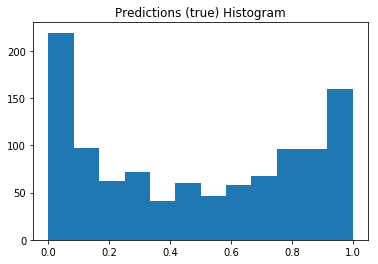

67th percentile:  0.7458695983886718




F1 score is  : 0.7734806629834253
Accuracy is  : 0.795
metrics partial [0.7734806629834253, 0.795]


In [261]:
predictions_raw=model.predict([x4_valid, x5_valid, x6_valid, x7_valid, x8_valid, x9_valid, x10_valid, transformed_features_v]) 
#predictions_raw=model.predict([valid_inputs_cont, x4_valid]) 

print('The shape of the raw predictions is : ' + str(predictions_raw.shape))

#histogram = np.histogram(predictions, bins=[0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
plt.hist(predictions_raw, bins='auto')
plt.title('Predictions (true) Histogram')
plt.show()

percentile_67 = np.percentile(predictions_raw, 67)
print("67th percentile: ", str(percentile_67))
print("\n")
print("\n")
predictions = np.where(predictions_raw > 0.5, 1, 0)

#plt.hist(predictions, bins='auto')
#plt.title('Predictions (final) Histogram')
#plt.show()

# Apply minor tweaks to match the required dimension for submission. 
predictions = predictions.astype("int")
#print('The shape of the final predictions is : ' + str(predictions.shape))
#print('The data type of the final predictions is : ' + str(predictions.dtype))

metrics_partial = challenge.evaluate(predictions, 'partial')
print("metrics partial", metrics_partial)

In [ ]:
#challenge.submit(predictions)